In [2]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.8 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import mean_absolute_percentage_error
import optuna
from optuna.integration import XGBoostPruningCallback
#import xgboost as xgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import mlab
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from google.colab import drive
drive.mount('/content/drive')
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/godaddy-microbusiness-density-forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sample_submission = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/sample_submission.csv')
test = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/test.csv')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Mounted at /content/drive
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/sample_submission.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/census_starter.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/test.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/epcoh1000.data-00000-of-00001
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/checkpoint
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/train.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/prepared_train_data.csv
/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/submission.csv


In [4]:
!pip uninstall xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.8/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (Y/n)? y
  Successfully uninstalled xgboost-0.90


In [5]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.7 MB/s eta 0:00:00


In [6]:
import xgboost as xgb
xgb.__version__

'0.90'

In [8]:
#Train Data
train = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/train.csv')
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
#extract date from row_id
date = train['row_id'].str.split('_').apply(lambda x:x[1])
year = date.str.split('-').apply(lambda x:x[0])
train['year'] = year
train['year'] = train['year'].astype(int)
#give order to each cfipgs by it's sequence
train['order'] = train.groupby(['cfips'])['row_id'].cumcount()
#Calculate microbusiness_density(Rate of Change) -> price(time n) / price(time n-1)
train['last_month_density'] = train.groupby('cfips')['microbusiness_density'].shift(1)
train.loc[train[train['order']!=38].index, 'last_month_density'].fillna(1, inplace=True)
train.loc[train[train['order']!=38].index, 'last_month_density'].replace(0,1, inplace=True)
train.loc[train[(train['microbusiness_density']!=0)&(train['last_month_density']==0)&(train['order']!=38)].index, 'last_month_density'] = 1
train['target'] =  train['microbusiness_density'] / train['last_month_density']
train = train.reset_index(drop=True)
train.loc[train[(train['order']!=38)&(train['target'].isnull())].index,'target'] = 1
train.loc[train.target.isnull(), 'target'] = 1
train['state'] = train['state'].astype('category')
train['county'] = train['county'].astype('category')
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,year,order,last_month_density,target
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,0,NaN,1.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,1,3.007682,0.959167
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,2,2.884870,1.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,3,3.055843,0.979511
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,4,2.993233,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2022,34,1.803249,1.000000
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2022,35,1.803249,1.000000
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2022,36,1.803249,0.990099
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,2022,37,1.785395,1.000000


In [ ]:
#Census data from Census Bureau's American Community Survey (ACS)
#Suspended!
census_starter = pd.read_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/census_starter.csv')
census_starter_data = pd.DataFrame(columns=['cfips','year'])
for subject in ['pct_bb','pct_college','pct_foreign_born','pct_it_workers','median_hh_inc']:
    subject_list = [i for i in census_starter.columns if(subject in i)]
    subject_list.insert(0,'cfips')
    subject_tb = census_starter[subject_list].melt(id_vars=["cfips"], var_name="type", value_name=subject)
    subject_tb['year'] = subject_tb['type'].str.split('_').apply(lambda x :x[-1])
    subject_tb = subject_tb[['cfips', 'year', subject]]
    census_starter_data = census_starter_data.merge(subject_tb, on=['cfips', 'year'], how='outer')
#last year census starter mapped to current year of train data
census_starter_data['year'] = (census_starter_data['year'].astype(int)+1)
#Calculate customized rate of change(ROC) for each column in census_starter
def census_diff_func(data, column_lst):
  for column in column_lst:
    column_lag = data.groupby('cfips')[column].shift(1)
    data[f'{column}_diff'] = abs(data[column] - column_lag)/(data[column] + column_lag)
  return data
census_lst = ['pct_bb', 'pct_college', 'pct_foreign_born','pct_it_workers', 'median_hh_inc']
census_starter_data = census_diff_func(census_starter_data, census_lst)
#train = train.merge(census_starter_data, on=['cfips', 'year'], how='left')
print('census_starter:',census_starter_data.year.min())
print('census_starter:',census_starter_data.year.max())

census_starter: 2018
census_starter: 2022


In [9]:
#Moving Average of the features : SMA/CMA/EMA
#from time t to (t - num)
def mv_avg(data, column, num):
  for lag_num in range(1,6):
    data[f'microbusiness_density_log_lag_{lag_num}'] = np.log(data.groupby('cfips')['microbusiness_density'].shift(lag_num)+1)
  for lag_num in range(1,3):
    data[f'{column}_lag_{lag_num}'] = data.groupby('cfips')[column].shift(lag_num)
  for lag_num in range(2,3):
    data[f'{column}_diff_{lag_num-1}'] = abs(data[f'{column}_lag_{lag_num-1}'] - data[f'{column}_lag_{lag_num}'])/ \
                                            (data[f'{column}_lag_{lag_num-1}'] + data[f'{column}_lag_{lag_num}'])

  column_ema = data.groupby('cfips')[column].ewm(span=num).mean()
  data[f'{column}_EMA'] = column_ema.rename(f'{column}_EMA').reset_index(level=0)[f'{column}_EMA']
  data[f'{column}_EMA_lag'] = data.groupby('cfips')[f'{column}_EMA'].shift(1)
  data[f'{column}_EMA_diff'] = abs(data[f'{column}_lag_1'] - data[f'{column}_EMA_lag'])/(data[f'{column}_lag_1'] + data[f'{column}_EMA_lag'])
  return data
num = 5
train = mv_avg(train, 'target', num)

In [14]:
#First Step cleansing
#Overwrite target values over lower and upper bounds with corresponding EMA target values(time t-1)
lower_bound_percentile = .0125
lower_bound = train['target'].quantile([lower_bound_percentile])[lower_bound_percentile]
upper_bound_percentile = .9875
upper_bound = train['target'].quantile([upper_bound_percentile])[upper_bound_percentile]

outlier = train[(train['target']>upper_bound)|(train['target']<lower_bound)]['cfips'].unique()
drop_lst = []
for cfips in outlier:
  cfips_data = train[train['cfips']==cfips][['target', 'target_EMA_lag']]
  idx_lst = cfips_data[(cfips_data['target']>upper_bound)|(cfips_data['target']<lower_bound)].index
  for idx in list(idx_lst)[::-1]:
    if idx == cfips_data.index[0]:
      train.drop(idx, inplace=True)
      drop_lst.append(idx)
      target = train.loc[idx, 'target']
      ma = cfips_data.loc[idx-1, 'target_EMA_lag']
      if ma > upper_bound:
        ma = upper_bound
      elif ma < lower_bound:
        ma = lower_bound
      train.loc[idx, 'target'] = ma

In [15]:
def plot_cfips(cfips = None):
    plt.figure(figsize = (15,4))
    plot_df = train[train['cfips'] == cfips]
    plt.plot(plot_df['first_day_of_month'], plot_df['target'], '-o', label = 'train data')
    plt.title('Microbussiness Trend Analysis CFIPS: ' + str(cfips), size = 12)
    plt.xlabel('Date',size = 5)
    plt.ylabel('Microbusiness Density',size = 12)
    plt.legend()
    plt.grid(alpha = 0.5)
    plt.show()
    return None

In [17]:
#cfips在target_diff總和仍過2，進第二輪清理
def second_step_cleansing(data, lower_bound, upper_bound):
  target_diff_sum = data.groupby('cfips')['target_diff_1'].sum().rename('target_diff_sum').reset_index()
  target_diff_sum = target_diff_sum.loc[target_diff_sum.target_diff_sum>2, 'cfips'].tolist()
  check = data[(data['cfips'].isin(target_diff_sum))&(data['target']>=lower_bound)&(data['target']<=upper_bound)]
  mean = check.groupby('cfips')['target'].mean().rename('target_mean').reset_index()
  check = check.merge(mean)
  idx = (check['cfips'].value_counts()>=16)
  cleansed_list = list(idx[idx].index)
  conditioned_train = data[(data['cfips'].isin(cleansed_list))&(data['order']!=38)]
  conditioned_train = conditioned_train[(conditioned_train['target']>upper_bound)|(conditioned_train['target']<lower_bound)]
  original_idx = conditioned_train.index
  merged_train_mean = conditioned_train.merge(mean, how='left')
  merged_train_mean.index = original_idx
  data.loc[original_idx, 'target'] = merged_train_mean['target_mean']
  return data, target_diff_sum
train, target_diff_sum = second_step_cleansing(train, 0.99, 1.01)

In [20]:
def smape(y_true, y_pred):
    zero_idx = (y_true==0) & (y_pred==0)
    y_true[zero_idx] = 1
    y_pred[zero_idx] = 1
    score = 1 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)) * 100)
    return score

In [21]:
feature = ['target_diff_1','microbusiness_density_log_lag_1','microbusiness_density_log_lag_2', 'microbusiness_density_log_lag_3']
val = train.query("first_day_of_month == '2022-10-01'")
val_x, val_y = val[feature], val['target']

In [22]:
from optuna.integration import LightGBMPruningCallback
import lightgbm as lgb

In [46]:
def objective(trial, data, val_x, val_y, val, feature):
  params = {
        'n_iter': trial.suggest_int('n_iter', 1000, 2000, 50),
        'verbosity': -1,
        'objective': 'mape',
        'random_state': 42,
        'extra_trees': True,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 8, 1024),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 250),}
    # LGBM建模
  train_data = data[~data['order'].isin([0,1,2,3,4,38])]   
  train_data = train_data[train_data['order']!=38]
  model = lgb.LGBMRegressor(**params)
  model.fit(
        train_data[feature],
        train_data['target'],
        eval_set=[(val_x, val_y)],
        eval_metric="mape",
        early_stopping_rounds=10,
        callbacks=[
            LightGBMPruningCallback(trial, "mape")
        ],
    )
    # 模型预测
  pred = model.predict(val_x)
  val = val.assign(pred=pred)
    #
  val = val.assign(pred_density=lambda df: df.pred*df.last_month_density.to_numpy())
    #val = val.assign(pred_density=lambda df: df.apply(lambda x: x.pred*x.last_month_density.to_numpy()))
    # print(mean_absolute_percentage_error(val['microbusiness_density'], val['pred_density']))
  score = smape(val['microbusiness_density'], val['pred_density'])

  return score

In [47]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, train, val_x, val_y, val,feature)
study.optimize(func, n_trials=1000)

[I 2023-02-10 15:50:36,511] A new study created in memory with name: LGBM Regressor


[1]	valid_0's mape: 0.0105089
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010505
[3]	valid_0's mape: 0.0105017
[4]	valid_0's mape: 0.0105013
[5]	valid_0's mape: 0.0104978
[6]	valid_0's mape: 0.010495
[7]	valid_0's mape: 0.0104909
[8]	valid_0's mape: 0.0104909
[9]	valid_0's mape: 0.0104879
[10]	valid_0's mape: 0.0104851
[11]	valid_0's mape: 0.0104824
[12]	valid_0's mape: 0.0104823
[13]	valid_0's mape: 0.0104794
[14]	valid_0's mape: 0.0104769
[15]	valid_0's mape: 0.0104746
[16]	valid_0's mape: 0.0104746
[17]	valid_0's mape: 0.0104721
[18]	valid_0's mape: 0.0104701
[19]	valid_0's mape: 0.0104681
[20]	valid_0's mape: 0.0104681
[21]	valid_0's mape: 0.0104665
[22]	valid_0's mape: 0.0104647
[23]	valid_0's mape: 0.010463
[24]	valid_0's mape: 0.010463
[25]	valid_0's mape: 0.0104617
[26]	valid_0's mape: 0.0104603
[27]	valid_0's mape: 0.0104589
[28]	valid_0's mape: 0.0104589
[29]	valid_0's mape: 0.0104574
[30]	valid_0's mape: 0.0104563
[31]	valid_0's mape: 

<ipython-input-20-379ca982565c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true[zero_idx] = 1
<ipython-input-20-379ca982565c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred[zero_idx] = 1
[I 2023-02-10 15:50:44,323] Trial 0 finished with value: 1.091532350204454 and parameters: {'n_iter': 1650, 'colsample_bytree': 0.3361623311878659, 'colsample_bynode': 0.9781750031703957, 'max_depth': 4, 'learning_rate': 0.03693923837515496, 'lambda_l1': 1.0349145429445892, 'lambda_l2': 2.7068595439487586, 'num_leaves': 199, 'min_data_in_leaf': 147}. Best is trial 0 with value: 1.091532350204454.


[1]	valid_0's mape: 0.010505
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104986
[3]	valid_0's mape: 0.0104915
[4]	valid_0's mape: 0.0104899
[5]	valid_0's mape: 0.0104839
[6]	valid_0's mape: 0.0104784
[7]	valid_0's mape: 0.0104731
[8]	valid_0's mape: 0.010472
[9]	valid_0's mape: 0.0104671
[10]	valid_0's mape: 0.010463
[11]	valid_0's mape: 0.0104594
[12]	valid_0's mape: 0.0104591
[13]	valid_0's mape: 0.0104554
[14]	valid_0's mape: 0.0104525
[15]	valid_0's mape: 0.0104494
[16]	valid_0's mape: 0.0104492
[17]	valid_0's mape: 0.0104462
[18]	valid_0's mape: 0.0104432
[19]	valid_0's mape: 0.0104406
[20]	valid_0's mape: 0.01044
[21]	valid_0's mape: 0.0104377
[22]	valid_0's mape: 0.0104355
[23]	valid_0's mape: 0.0104336
[24]	valid_0's mape: 0.0104331
[25]	valid_0's mape: 0.0104312
[26]	valid_0's mape: 0.0104294
[27]	valid_0's mape: 0.0104282
[28]	valid_0's mape: 0.0104284
[29]	valid_0's mape: 0.0104267
[30]	valid_0's mape: 0.0104256
[31]	valid_0's mape: 0

[I 2023-02-10 15:50:46,100] Trial 1 finished with value: 1.0903843382959935 and parameters: {'n_iter': 1850, 'colsample_bytree': 0.4310181533644466, 'colsample_bynode': 0.9642598826090063, 'max_depth': 7, 'learning_rate': 0.06796385946769913, 'lambda_l1': 4.819546696038488, 'lambda_l2': 4.631512317059268, 'num_leaves': 426, 'min_data_in_leaf': 78}. Best is trial 1 with value: 1.0903843382959935.


[80]	valid_0's mape: 0.0104084
[81]	valid_0's mape: 0.0104084
[82]	valid_0's mape: 0.0104084
[83]	valid_0's mape: 0.0104084
[84]	valid_0's mape: 0.0104087
Early stopping, best iteration is:
[74]	valid_0's mape: 0.0104082
[1]	valid_0's mape: 0.0105105
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0105084
[3]	valid_0's mape: 0.0105057
[4]	valid_0's mape: 0.0105038
[5]	valid_0's mape: 0.0105018
[6]	valid_0's mape: 0.0104999
[7]	valid_0's mape: 0.0104981
[8]	valid_0's mape: 0.0104964
[9]	valid_0's mape: 0.0104947
[10]	valid_0's mape: 0.0104926
[11]	valid_0's mape: 0.010491
[12]	valid_0's mape: 0.0104894
[13]	valid_0's mape: 0.0104878
[14]	valid_0's mape: 0.0104862
[15]	valid_0's mape: 0.0104847
[16]	valid_0's mape: 0.0104834
[17]	valid_0's mape: 0.0104816
[18]	valid_0's mape: 0.0104808
[19]	valid_0's mape: 0.0104792
[20]	valid_0's mape: 0.0104784
[21]	valid_0's mape: 0.0104769
[22]	valid_0's mape: 0.010476
[23]	valid_0's mape: 0.0104746
[24]	valid_0's 

[I 2023-02-10 15:50:49,027] Trial 2 finished with value: 1.0936112286316086 and parameters: {'n_iter': 1250, 'colsample_bytree': 0.6358934908204306, 'colsample_bynode': 0.6520348582421241, 'max_depth': 3, 'learning_rate': 0.023909500309880677, 'lambda_l1': 2.5484585954412275, 'lambda_l2': 8.122697346277414, 'num_leaves': 281, 'min_data_in_leaf': 118}. Best is trial 1 with value: 1.0903843382959935.


[124]	valid_0's mape: 0.0104398
Early stopping, best iteration is:
[114]	valid_0's mape: 0.0104398
[1]	valid_0's mape: 0.0105104
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0105082
[3]	valid_0's mape: 0.010506
[4]	valid_0's mape: 0.0105037
[5]	valid_0's mape: 0.0105015
[6]	valid_0's mape: 0.0104994
[7]	valid_0's mape: 0.0104966
[8]	valid_0's mape: 0.0104945
[9]	valid_0's mape: 0.0104923
[10]	valid_0's mape: 0.0104904
[11]	valid_0's mape: 0.0104884
[12]	valid_0's mape: 0.0104864
[13]	valid_0's mape: 0.0104848
[14]	valid_0's mape: 0.0104831
[15]	valid_0's mape: 0.0104816
[16]	valid_0's mape: 0.0104796
[17]	valid_0's mape: 0.0104774
[18]	valid_0's mape: 0.010476
[19]	valid_0's mape: 0.0104745
[20]	valid_0's mape: 0.0104731
[21]	valid_0's mape: 0.0104713
[22]	valid_0's mape: 0.0104698
[23]	valid_0's mape: 0.0104682
[24]	valid_0's mape: 0.0104668
[25]	valid_0's mape: 0.0104654
[26]	valid_0's mape: 0.0104642
[27]	valid_0's mape: 0.0104629
[28]	valid_0'

[I 2023-02-10 15:50:56,216] Trial 3 finished with value: 1.090903047543261 and parameters: {'n_iter': 1250, 'colsample_bytree': 0.8899113981560743, 'colsample_bynode': 0.40020743406478343, 'max_depth': 9, 'learning_rate': 0.022879307116109616, 'lambda_l1': 5.667438015295321, 'lambda_l2': 5.37213709494655, 'num_leaves': 388, 'min_data_in_leaf': 132}. Best is trial 1 with value: 1.0903843382959935.


[1]	valid_0's mape: 0.0105119
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0105104
[3]	valid_0's mape: 0.0105089
[4]	valid_0's mape: 0.0105085
[5]	valid_0's mape: 0.010507
[6]	valid_0's mape: 0.0105055
[7]	valid_0's mape: 0.0105041
[8]	valid_0's mape: 0.0105036
[9]	valid_0's mape: 0.0105021
[10]	valid_0's mape: 0.0105007
[11]	valid_0's mape: 0.0104994
[12]	valid_0's mape: 0.010499
[13]	valid_0's mape: 0.0104976
[14]	valid_0's mape: 0.0104962
[15]	valid_0's mape: 0.010495
[16]	valid_0's mape: 0.0104948
[17]	valid_0's mape: 0.0104934
[18]	valid_0's mape: 0.0104922
[19]	valid_0's mape: 0.0104909
[20]	valid_0's mape: 0.0104907
[21]	valid_0's mape: 0.0104895
[22]	valid_0's mape: 0.0104883
[23]	valid_0's mape: 0.010487
[24]	valid_0's mape: 0.0104869
[25]	valid_0's mape: 0.0104857
[26]	valid_0's mape: 0.0104846
[27]	valid_0's mape: 0.0104834
[28]	valid_0's mape: 0.0104832
[29]	valid_0's mape: 0.010482
[30]	valid_0's mape: 0.010481
[31]	valid_0's mape: 0.

[I 2023-02-10 15:51:09,679] Trial 4 finished with value: 1.0904287832919466 and parameters: {'n_iter': 1000, 'colsample_bytree': 0.4767583273875198, 'colsample_bynode': 0.13105677064072385, 'max_depth': 8, 'learning_rate': 0.013287156469583207, 'lambda_l1': 6.072296479820704, 'lambda_l2': 1.5578978835721846, 'num_leaves': 433, 'min_data_in_leaf': 181}. Best is trial 1 with value: 1.0903843382959935.
[I 2023-02-10 15:51:09,820] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:09,946] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:10,079] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:10,226] Trial 8 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010506
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0105012
[3]	valid_0's mape: 0.0104948
[4]	valid_0's mape: 0.0104903
[5]	valid_0's mape: 0.0104846
[6]	valid_0's mape: 0.01048
[7]	valid_0's mape: 0.0104752
[8]	valid_0's mape: 0.0104712
[9]	valid_0's mape: 0.0104674
[10]	valid_0's mape: 0.0104643
[11]	valid_0's mape: 0.0104608
[12]	valid_0's mape: 0.0104582
[13]	valid_0's mape: 0.0104547
[14]	valid_0's mape: 0.0104519
[15]	valid_0's mape: 0.0104485
[16]	valid_0's mape: 0.0104458
[17]	valid_0's mape: 0.0104432
[18]	valid_0's mape: 0.0104415
[19]	valid_0's mape: 0.0104391
[20]	valid_0's mape: 0.0104382
[21]	valid_0's mape: 0.0104357
[22]	valid_0's mape: 0.0104345
[23]	valid_0's mape: 0.0104326
[24]	valid_0's mape: 0.0104314
[25]	valid_0's mape: 0.01043
[26]	valid_0's mape: 0.010429
[27]	valid_0's mape: 0.0104278
[28]	valid_0's mape: 0.0104269
[29]	valid_0's mape: 0.0104261
[30]	valid_0's mape: 0.0104257
[31]	valid_0's mape: 0.

[I 2023-02-10 15:51:12,296] Trial 9 finished with value: 1.0909113022453585 and parameters: {'n_iter': 1350, 'colsample_bytree': 0.7460977463131981, 'colsample_bynode': 0.42189486655442787, 'max_depth': 10, 'learning_rate': 0.05511573302455122, 'lambda_l1': 1.3454153595311433, 'lambda_l2': 4.315381012137736, 'num_leaves': 497, 'min_data_in_leaf': 209}. Best is trial 1 with value: 1.0903843382959935.


[1]	valid_0's mape: 0.0105027
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104951
[3]	valid_0's mape: 0.0104874
[4]	valid_0's mape: 0.0104812
[5]	valid_0's mape: 0.0104752
[6]	valid_0's mape: 0.0104722
[7]	valid_0's mape: 0.0104705
[8]	valid_0's mape: 0.0104651
[9]	valid_0's mape: 0.0104593
[10]	valid_0's mape: 0.0104542
[11]	valid_0's mape: 0.0104493
[12]	valid_0's mape: 0.0104451
[13]	valid_0's mape: 0.0104412
[14]	valid_0's mape: 0.0104379
[15]	valid_0's mape: 0.0104346
[16]	valid_0's mape: 0.0104317
[17]	valid_0's mape: 0.0104289
[18]	valid_0's mape: 0.0104266
[19]	valid_0's mape: 0.0104244
[20]	valid_0's mape: 0.0104225
[21]	valid_0's mape: 0.0104209
[22]	valid_0's mape: 0.0104195
[23]	valid_0's mape: 0.0104187
[24]	valid_0's mape: 0.0104177
[25]	valid_0's mape: 0.0104172
[26]	valid_0's mape: 0.0104165
[27]	valid_0's mape: 0.0104164
[28]	valid_0's mape: 0.0104158
[29]	valid_0's mape: 0.0104157
[30]	valid_0's mape: 0.0104152
[31]	valid_0's ma

[I 2023-02-10 15:51:13,676] Trial 10 finished with value: 1.0901786219763627 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.5742649272883886, 'colsample_bynode': 0.9455675369006756, 'max_depth': 5, 'learning_rate': 0.08948837439887554, 'lambda_l1': 3.442934756007615, 'lambda_l2': 0.12457638260730697, 'num_leaves': 17, 'min_data_in_leaf': 250}. Best is trial 10 with value: 1.0901786219763627.


[58]	valid_0's mape: 0.0104063
[59]	valid_0's mape: 0.0104063
[60]	valid_0's mape: 0.0104063
[61]	valid_0's mape: 0.0104063
[62]	valid_0's mape: 0.0104062
Early stopping, best iteration is:
[52]	valid_0's mape: 0.0104061
[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104931
[3]	valid_0's mape: 0.0104845
[4]	valid_0's mape: 0.0104783
[5]	valid_0's mape: 0.0104719
[6]	valid_0's mape: 0.0104686
[7]	valid_0's mape: 0.0104642
[8]	valid_0's mape: 0.0104626
[9]	valid_0's mape: 0.0104587
[10]	valid_0's mape: 0.0104582
[11]	valid_0's mape: 0.0104573
[12]	valid_0's mape: 0.0104566
[13]	valid_0's mape: 0.0104566
[14]	valid_0's mape: 0.0104558
[15]	valid_0's mape: 0.0104558
[16]	valid_0's mape: 0.0104551
[17]	valid_0's mape: 0.0104551
[18]	valid_0's mape: 0.0104528
[19]	valid_0's mape: 0.0104521
[20]	valid_0's mape: 0.0104501
[21]	valid_0's mape: 0.0104499
[22]	valid_0's mape: 0.0104497
[23]	valid_0's mape: 0.0104454
[24]	valid_0'

[I 2023-02-10 15:51:14,815] Trial 11 finished with value: 1.0919495869852438 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.5740821537478121, 'colsample_bynode': 0.9840435428038523, 'max_depth': 5, 'learning_rate': 0.099711605864958, 'lambda_l1': 3.626125892543519, 'lambda_l2': 0.22065578288515397, 'num_leaves': 10, 'min_data_in_leaf': 233}. Best is trial 10 with value: 1.0901786219763627.


[41]	valid_0's mape: 0.0104235
[42]	valid_0's mape: 0.0104235
[43]	valid_0's mape: 0.0104235
[44]	valid_0's mape: 0.0104235
Early stopping, best iteration is:
[34]	valid_0's mape: 0.0104235
[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104827
[4]	valid_0's mape: 0.0104809
[5]	valid_0's mape: 0.0104738
[6]	valid_0's mape: 0.0104682
[7]	valid_0's mape: 0.0104623
[8]	valid_0's mape: 0.0104615
[9]	valid_0's mape: 0.0104562
[10]	valid_0's mape: 0.0104525
[11]	valid_0's mape: 0.0104495
[12]	valid_0's mape: 0.010449
[13]	valid_0's mape: 0.0104447
[14]	valid_0's mape: 0.010441
[15]	valid_0's mape: 0.0104378
[16]	valid_0's mape: 0.010437
[17]	valid_0's mape: 0.0104353
[18]	valid_0's mape: 0.0104347
[19]	valid_0's mape: 0.0104321
[20]	valid_0's mape: 0.0104319
[21]	valid_0's mape: 0.0104306
[22]	valid_0's mape: 0.0104303
[23]	valid_0's mape: 0.0104285
[24]	valid_0's mape: 0.0104284
[25]	valid_0's m

[I 2023-02-10 15:51:19,929] Trial 12 finished with value: 1.0894459052394798 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.47107033499025813, 'colsample_bynode': 0.8152492993317679, 'max_depth': 6, 'learning_rate': 0.09830684071552356, 'lambda_l1': 3.6880527313783458, 'lambda_l2': 0.08076342867682373, 'num_leaves': 734, 'min_data_in_leaf': 65}. Best is trial 12 with value: 1.0894459052394798.


[92]	valid_0's mape: 0.0103993
[93]	valid_0's mape: 0.0103992
[94]	valid_0's mape: 0.0103993
[95]	valid_0's mape: 0.0103995
[96]	valid_0's mape: 0.0103995
[97]	valid_0's mape: 0.0103995
[98]	valid_0's mape: 0.0103995
[99]	valid_0's mape: 0.0103995
Early stopping, best iteration is:
[89]	valid_0's mape: 0.0103989
[1]	valid_0's mape: 0.0105033
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104961
[3]	valid_0's mape: 0.010489
[4]	valid_0's mape: 0.0104831
[5]	valid_0's mape: 0.0104771
[6]	valid_0's mape: 0.0104715
[7]	valid_0's mape: 0.0104662
[8]	valid_0's mape: 0.0104633
[9]	valid_0's mape: 0.0104577
[10]	valid_0's mape: 0.0104557
[11]	valid_0's mape: 0.0104524
[12]	valid_0's mape: 0.0104511
[13]	valid_0's mape: 0.0104504
[14]	valid_0's mape: 0.0104493
[15]	valid_0's mape: 0.0104486
[16]	valid_0's mape: 0.0104461
[17]	valid_0's mape: 0.0104456
[18]	valid_0's mape: 0.0104438
[19]	valid_0's mape: 0.0104434
[20]	valid_0's mape: 0.0104413
[21]	valid_0's

[I 2023-02-10 15:51:21,798] Trial 13 finished with value: 1.0898468161736417 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6702027164651531, 'colsample_bynode': 0.8086387140037703, 'max_depth': 5, 'learning_rate': 0.08308231371366552, 'lambda_l1': 0.06643869756270382, 'lambda_l2': 0.019003066176855724, 'num_leaves': 708, 'min_data_in_leaf': 172}. Best is trial 12 with value: 1.0894459052394798.


[75]	valid_0's mape: 0.0104034
[76]	valid_0's mape: 0.0104036
[77]	valid_0's mape: 0.0104036
[78]	valid_0's mape: 0.0104037
[79]	valid_0's mape: 0.0104037
[80]	valid_0's mape: 0.010404
[81]	valid_0's mape: 0.0104039
Early stopping, best iteration is:
[71]	valid_0's mape: 0.0104031


[I 2023-02-10 15:51:21,992] Trial 14 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104938
[3]	valid_0's mape: 0.0104866
[4]	valid_0's mape: 0.0104801
[5]	valid_0's mape: 0.0104736
[6]	valid_0's mape: 0.01047
[7]	valid_0's mape: 0.0104648
[8]	valid_0's mape: 0.0104632
[9]	valid_0's mape: 0.0104622
[10]	valid_0's mape: 0.0104584


[I 2023-02-10 15:51:22,525] Trial 15 pruned. Trial was pruned at iteration 16.


[11]	valid_0's mape: 0.0104578
[12]	valid_0's mape: 0.0104545
[13]	valid_0's mape: 0.0104545
[14]	valid_0's mape: 0.0104517
[15]	valid_0's mape: 0.0104517
[16]	valid_0's mape: 0.0104511


[I 2023-02-10 15:51:22,706] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:22,886] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:23,071] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:23,268] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:23,454] Trial 20 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105018
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104919
[3]	valid_0's mape: 0.0104837
[4]	valid_0's mape: 0.0104753
[5]	valid_0's mape: 0.0104693
[6]	valid_0's mape: 0.0104631
[7]	valid_0's mape: 0.0104584
[8]	valid_0's mape: 0.0104546
[9]	valid_0's mape: 0.0104512
[10]	valid_0's mape: 0.0104469
[11]	valid_0's mape: 0.0104442
[12]	valid_0's mape: 0.0104406
[13]	valid_0's mape: 0.0104362
[14]	valid_0's mape: 0.0104335
[15]	valid_0's mape: 0.0104319
[16]	valid_0's mape: 0.0104312
[17]	valid_0's mape: 0.0104308
[18]	valid_0's mape: 0.0104292
[19]	valid_0's mape: 0.0104264
[20]	valid_0's mape: 0.0104249
[21]	valid_0's mape: 0.0104229
[22]	valid_0's mape: 0.0104212
[23]	valid_0's mape: 0.0104196
[24]	valid_0's mape: 0.0104182
[25]	valid_0's mape: 0.0104169
[26]	valid_0's mape: 0.0104169
[27]	valid_0's mape: 0.0104152
[28]	valid_0's mape: 0.010413
[29]	valid_0's mape: 0.0104121
[30]	valid_0's mape: 0.0104118
[31]	valid_0's map

[I 2023-02-10 15:51:25,569] Trial 21 finished with value: 1.0898560212318606 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.5592765895296724, 'colsample_bynode': 0.9121971660626443, 'max_depth': 5, 'learning_rate': 0.09782901783774813, 'lambda_l1': 3.273869348708706, 'lambda_l2': 0.41319174613790977, 'num_leaves': 26, 'min_data_in_leaf': 240}. Best is trial 12 with value: 1.0894459052394798.


[1]	valid_0's mape: 0.0105022
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104826
[4]	valid_0's mape: 0.0104748
[5]	valid_0's mape: 0.0104687
[6]	valid_0's mape: 0.0104628
[7]	valid_0's mape: 0.0104582
[8]	valid_0's mape: 0.0104546
[9]	valid_0's mape: 0.0104498
[10]	valid_0's mape: 0.0104464
[11]	valid_0's mape: 0.0104422
[12]	valid_0's mape: 0.0104403
[13]	valid_0's mape: 0.0104379
[14]	valid_0's mape: 0.0104354
[15]	valid_0's mape: 0.0104325
[16]	valid_0's mape: 0.0104301
[17]	valid_0's mape: 0.0104279
[18]	valid_0's mape: 0.010426
[19]	valid_0's mape: 0.010424
[20]	valid_0's mape: 0.010422
[21]	valid_0's mape: 0.0104203
[22]	valid_0's mape: 0.0104193
[23]	valid_0's mape: 0.0104174
[24]	valid_0's mape: 0.0104159
[25]	valid_0's mape: 0.010415
[26]	valid_0's mape: 0.0104146
[27]	valid_0's mape: 0.0104138
[28]	valid_0's mape: 0.0104141
[29]	valid_0's mape: 0.0104128
[30]	valid_0's mape: 0.0104131
[31]	valid_0's mape: 

[I 2023-02-10 15:51:27,531] Trial 22 finished with value: 1.0898272218020282 and parameters: {'n_iter': 1950, 'colsample_bytree': 0.5513470379921876, 'colsample_bynode': 0.7215109836968647, 'max_depth': 5, 'learning_rate': 0.09489422909029487, 'lambda_l1': 2.8706094578485892, 'lambda_l2': 0.7006728242910387, 'num_leaves': 583, 'min_data_in_leaf': 221}. Best is trial 12 with value: 1.0894459052394798.


[1]	valid_0's mape: 0.0105037
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104953
[3]	valid_0's mape: 0.0104872
[4]	valid_0's mape: 0.0104803
[5]	valid_0's mape: 0.0104742
[6]	valid_0's mape: 0.0104684
[7]	valid_0's mape: 0.0104626
[8]	valid_0's mape: 0.0104578
[9]	valid_0's mape: 0.0104536
[10]	valid_0's mape: 0.0104507
[11]	valid_0's mape: 0.0104478
[12]	valid_0's mape: 0.0104451
[13]	valid_0's mape: 0.0104414
[14]	valid_0's mape: 0.0104392
[15]	valid_0's mape: 0.0104363
[16]	valid_0's mape: 0.0104336
[17]	valid_0's mape: 0.0104311
[18]	valid_0's mape: 0.0104297
[19]	valid_0's mape: 0.010428
[20]	valid_0's mape: 0.0104264
[21]	valid_0's mape: 0.0104246
[22]	valid_0's mape: 0.0104239
[23]	valid_0's mape: 0.010422
[24]	valid_0's mape: 0.0104211
[25]	valid_0's mape: 0.0104195
[26]	valid_0's mape: 0.0104193
[27]	valid_0's mape: 0.0104183
[28]	valid_0's mape: 0.0104174
[29]	valid_0's mape: 0.0104164
[30]	valid_0's mape: 0.0104156
[31]	valid_0's mape

[I 2023-02-10 15:51:29,038] Trial 23 finished with value: 1.0902856979025017 and parameters: {'n_iter': 1900, 'colsample_bytree': 0.748235194119358, 'colsample_bynode': 0.7059175993815865, 'max_depth': 6, 'learning_rate': 0.07790973109131306, 'lambda_l1': 2.4059801677242687, 'lambda_l2': 2.1098689847363445, 'num_leaves': 559, 'min_data_in_leaf': 210}. Best is trial 12 with value: 1.0894459052394798.
[I 2023-02-10 15:51:29,216] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:29,405] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:29,592] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:29,820] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:30,215] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:30,690] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:31,335] Trial 30 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916
[3]	valid_0's mape: 0.0104833
[4]	valid_0's mape: 0.0104748
[5]	valid_0's mape: 0.0104688
[6]	valid_0's mape: 0.0104626
[7]	valid_0's mape: 0.010458
[8]	valid_0's mape: 0.0104542
[9]	valid_0's mape: 0.0104508
[10]	valid_0's mape: 0.0104465
[11]	valid_0's mape: 0.0104439
[12]	valid_0's mape: 0.0104405
[13]	valid_0's mape: 0.010436
[14]	valid_0's mape: 0.0104331
[15]	valid_0's mape: 0.0104315
[16]	valid_0's mape: 0.0104295
[17]	valid_0's mape: 0.0104267
[18]	valid_0's mape: 0.0104267
[19]	valid_0's mape: 0.0104244
[20]	valid_0's mape: 0.0104227
[21]	valid_0's mape: 0.0104208
[22]	valid_0's mape: 0.0104191
[23]	valid_0's mape: 0.0104175
[24]	valid_0's mape: 0.0104158
[25]	valid_0's mape: 0.0104146
[26]	valid_0's mape: 0.0104142
[27]	valid_0's mape: 0.0104138
[28]	valid_0's mape: 0.0104116
[29]	valid_0's mape: 0.010411
[30]	valid_0's mape: 0.0104107
[31]	valid_0's mape:

[I 2023-02-10 15:51:34,822] Trial 31 finished with value: 1.08977866533471 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.5521811213869731, 'colsample_bynode': 0.8180858072847613, 'max_depth': 5, 'learning_rate': 0.09940236875506518, 'lambda_l1': 3.1702144242299224, 'lambda_l2': 0.9165485169601023, 'num_leaves': 123, 'min_data_in_leaf': 243}. Best is trial 12 with value: 1.0894459052394798.


[66]	valid_0's mape: 0.0104032
[67]	valid_0's mape: 0.0104032
[68]	valid_0's mape: 0.0104033
[69]	valid_0's mape: 0.0104033
[70]	valid_0's mape: 0.010403
[71]	valid_0's mape: 0.0104025
[72]	valid_0's mape: 0.0104025
Early stopping, best iteration is:
[62]	valid_0's mape: 0.0104024


[I 2023-02-10 15:51:35,013] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:35,213] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:35,397] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:35,576] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:35,782] Trial 36 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104927
[3]	valid_0's mape: 0.0104824
[4]	valid_0's mape: 0.0104743
[5]	valid_0's mape: 0.010468
[6]	valid_0's mape: 0.0104621
[7]	valid_0's mape: 0.0104556
[8]	valid_0's mape: 0.010451
[9]	valid_0's mape: 0.0104461
[10]	valid_0's mape: 0.0104435
[11]	valid_0's mape: 0.0104395
[12]	valid_0's mape: 0.0104364
[13]	valid_0's mape: 0.0104338
[14]	valid_0's mape: 0.0104316
[15]	valid_0's mape: 0.0104295
[16]	valid_0's mape: 0.0104295
[17]	valid_0's mape: 0.010429
[18]	valid_0's mape: 0.0104268
[19]	valid_0's mape: 0.0104248
[20]	valid_0's mape: 0.0104245
[21]	valid_0's mape: 0.0104225
[22]	valid_0's mape: 0.0104203
[23]	valid_0's mape: 0.010419
[24]	valid_0's mape: 0.0104186
[25]	valid_0's mape: 0.0104171
[26]	valid_0's mape: 0.0104154
[27]	valid_0's mape: 0.0104154
[28]	valid_0's mape: 0.0104137
[29]	valid_0's mape: 0.0104137
[30]	valid_0's mape: 0.0104139
[31]	valid_0's mape: 

[I 2023-02-10 15:51:37,987] Trial 37 finished with value: 1.089878400102851 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6271511933232747, 'colsample_bynode': 0.6950262706481283, 'max_depth': 5, 'learning_rate': 0.09837529334133396, 'lambda_l1': 1.8603605946806292, 'lambda_l2': 2.7030568194888014, 'num_leaves': 572, 'min_data_in_leaf': 105}. Best is trial 12 with value: 1.0894459052394798.


[88]	valid_0's mape: 0.0104041
[89]	valid_0's mape: 0.0104041
Early stopping, best iteration is:
[79]	valid_0's mape: 0.0104037


[I 2023-02-10 15:51:38,196] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:38,393] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:38,571] Trial 40 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105018
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010492
[3]	valid_0's mape: 0.0104838
[4]	valid_0's mape: 0.0104756
[5]	valid_0's mape: 0.0104696
[6]	valid_0's mape: 0.0104633
[7]	valid_0's mape: 0.0104586
[8]	valid_0's mape: 0.0104556
[9]	valid_0's mape: 0.010452
[10]	valid_0's mape: 0.0104477
[11]	valid_0's mape: 0.010445
[12]	valid_0's mape: 0.010443
[13]	valid_0's mape: 0.0104393
[14]	valid_0's mape: 0.0104376
[15]	valid_0's mape: 0.0104346
[16]	valid_0's mape: 0.0104334
[17]	valid_0's mape: 0.0104306
[18]	valid_0's mape: 0.0104282
[19]	valid_0's mape: 0.0104258
[20]	valid_0's mape: 0.0104246
[21]	valid_0's mape: 0.0104227
[22]	valid_0's mape: 0.0104227
[23]	valid_0's mape: 0.0104211
[24]	valid_0's mape: 0.0104195
[25]	valid_0's mape: 0.0104193
[26]	valid_0's mape: 0.0104188
[27]	valid_0's mape: 0.0104186
[28]	valid_0's mape: 0.0104175
[29]	valid_0's mape: 0.0104162
[30]	valid_0's mape: 0.010415
[31]	valid_0's mape: 0

[I 2023-02-10 15:51:40,611] Trial 41 finished with value: 1.0899970491057256 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6039324332751337, 'colsample_bynode': 0.8934536441331427, 'max_depth': 5, 'learning_rate': 0.09773700333544358, 'lambda_l1': 3.18436854396913, 'lambda_l2': 0.5354951590332916, 'num_leaves': 212, 'min_data_in_leaf': 236}. Best is trial 12 with value: 1.0894459052394798.


[81]	valid_0's mape: 0.0104048
[82]	valid_0's mape: 0.0104051
[83]	valid_0's mape: 0.0104051
[84]	valid_0's mape: 0.0104053
Early stopping, best iteration is:
[74]	valid_0's mape: 0.0104045


[I 2023-02-10 15:51:40,808] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:41,008] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:41,196] Trial 44 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104913
[3]	valid_0's mape: 0.0104809
[4]	valid_0's mape: 0.0104728
[5]	valid_0's mape: 0.0104654
[6]	valid_0's mape: 0.0104588
[7]	valid_0's mape: 0.0104535
[8]	valid_0's mape: 0.0104495
[9]	valid_0's mape: 0.0104455
[10]	valid_0's mape: 0.0104443
[11]	valid_0's mape: 0.0104396
[12]	valid_0's mape: 0.0104363
[13]	valid_0's mape: 0.0104343
[14]	valid_0's mape: 0.0104327
[15]	valid_0's mape: 0.0104303
[16]	valid_0's mape: 0.0104289
[17]	valid_0's mape: 0.0104273
[18]	valid_0's mape: 0.0104249
[19]	valid_0's mape: 0.0104232
[20]	valid_0's mape: 0.0104215
[21]	valid_0's mape: 0.0104204
[22]	valid_0's mape: 0.010419
[23]	valid_0's mape: 0.0104181
[24]	valid_0's mape: 0.0104172
[25]	valid_0's mape: 0.0104162
[26]	valid_0's mape: 0.0104149
[27]	valid_0's mape: 0.0104145
[28]	valid_0's mape: 0.0104133
[29]	valid_0's mape: 0.0104128
[30]	valid_0's mape: 0.0104129
[31]	valid_0's map

[I 2023-02-10 15:51:42,354] Trial 45 finished with value: 1.0903808704452738 and parameters: {'n_iter': 1850, 'colsample_bytree': 0.6489052003480099, 'colsample_bynode': 0.895586680638947, 'max_depth': 7, 'learning_rate': 0.09812410255201988, 'lambda_l1': 3.695402272781697, 'lambda_l2': 2.0453238759958654, 'num_leaves': 77, 'min_data_in_leaf': 203}. Best is trial 12 with value: 1.0894459052394798.


[45]	valid_0's mape: 0.0104091
[46]	valid_0's mape: 0.0104095
[47]	valid_0's mape: 0.0104095
Early stopping, best iteration is:
[37]	valid_0's mape: 0.0104085


[I 2023-02-10 15:51:42,546] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:42,746] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:42,942] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:43,139] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:43,342] Trial 50 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104927
[3]	valid_0's mape: 0.0104825
[4]	valid_0's mape: 0.0104744
[5]	valid_0's mape: 0.0104681
[6]	valid_0's mape: 0.0104623
[7]	valid_0's mape: 0.0104559
[8]	valid_0's mape: 0.0104513
[9]	valid_0's mape: 0.0104466
[10]	valid_0's mape: 0.0104454
[11]	valid_0's mape: 0.0104411
[12]	valid_0's mape: 0.0104369
[13]	valid_0's mape: 0.0104347
[14]	valid_0's mape: 0.0104316
[15]	valid_0's mape: 0.0104284
[16]	valid_0's mape: 0.0104257
[17]	valid_0's mape: 0.010424
[18]	valid_0's mape: 0.010422
[19]	valid_0's mape: 0.0104201
[20]	valid_0's mape: 0.0104193
[21]	valid_0's mape: 0.0104177
[22]	valid_0's mape: 0.0104155
[23]	valid_0's mape: 0.010414
[24]	valid_0's mape: 0.0104133
[25]	valid_0's mape: 0.0104125
[26]	valid_0's mape: 0.010412
[27]	valid_0's mape: 0.0104113
[28]	valid_0's mape: 0.0104105
[29]	valid_0's mape: 0.0104095
[30]	valid_0's mape: 0.0104094
[31]	valid_0's mape: 

[I 2023-02-10 15:51:47,763] Trial 51 finished with value: 1.0899217602811084 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6261730034949856, 'colsample_bynode': 0.7005179901468145, 'max_depth': 5, 'learning_rate': 0.09800066686484576, 'lambda_l1': 1.9355387657129666, 'lambda_l2': 0.4212968909975435, 'num_leaves': 554, 'min_data_in_leaf': 107}. Best is trial 12 with value: 1.0894459052394798.


[61]	valid_0's mape: 0.0104042
[62]	valid_0's mape: 0.0104044
[63]	valid_0's mape: 0.0104041
Early stopping, best iteration is:
[53]	valid_0's mape: 0.0104039


[I 2023-02-10 15:51:48,078] Trial 52 pruned. Trial was pruned at iteration 6.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104933
[3]	valid_0's mape: 0.0104847
[4]	valid_0's mape: 0.0104779
[5]	valid_0's mape: 0.0104716
[6]	valid_0's mape: 0.0104684


[I 2023-02-10 15:51:48,270] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:48,470] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:48,685] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:48,888] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:49,076] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:49,295] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:49,485] Trial 59 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104928
[3]	valid_0's mape: 0.0104832
[4]	valid_0's mape: 0.0104751
[5]	valid_0's mape: 0.010469
[6]	valid_0's mape: 0.0104628
[7]	valid_0's mape: 0.0104576
[8]	valid_0's mape: 0.0104535
[9]	valid_0's mape: 0.0104484
[10]	valid_0's mape: 0.0104446
[11]	valid_0's mape: 0.0104401
[12]	valid_0's mape: 0.0104372
[13]	valid_0's mape: 0.0104337
[14]	valid_0's mape: 0.0104312
[15]	valid_0's mape: 0.0104296
[16]	valid_0's mape: 0.0104273
[17]	valid_0's mape: 0.0104255
[18]	valid_0's mape: 0.0104231
[19]	valid_0's mape: 0.0104202
[20]	valid_0's mape: 0.0104185
[21]	valid_0's mape: 0.0104165
[22]	valid_0's mape: 0.0104155
[23]	valid_0's mape: 0.0104144
[24]	valid_0's mape: 0.0104132
[25]	valid_0's mape: 0.0104119
[26]	valid_0's mape: 0.0104111
[27]	valid_0's mape: 0.0104103
[28]	valid_0's mape: 0.0104097
[29]	valid_0's mape: 0.0104091
[30]	valid_0's mape: 0.0104087
[31]	valid_0's map

[I 2023-02-10 15:51:51,369] Trial 60 finished with value: 1.0897132294907697 and parameters: {'n_iter': 1400, 'colsample_bytree': 0.6816182366653863, 'colsample_bynode': 0.8694966011316211, 'max_depth': 5, 'learning_rate': 0.09937257846262365, 'lambda_l1': 0.5353663235792959, 'lambda_l2': 0.8145676556208253, 'num_leaves': 859, 'min_data_in_leaf': 43}. Best is trial 12 with value: 1.0894459052394798.


[73]	valid_0's mape: 0.0104028
[74]	valid_0's mape: 0.0104027
[75]	valid_0's mape: 0.0104027
[76]	valid_0's mape: 0.0104022
[77]	valid_0's mape: 0.0104021
[78]	valid_0's mape: 0.0104021
Early stopping, best iteration is:
[68]	valid_0's mape: 0.0104018


[I 2023-02-10 15:51:51,579] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:51,794] Trial 62 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105017
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:51:52,027] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:52,225] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:52,416] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:52,638] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:52,859] Trial 67 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104909
[3]	valid_0's mape: 0.0104808
[4]	valid_0's mape: 0.0104725
[5]	valid_0's mape: 0.0104661
[6]	valid_0's mape: 0.0104604
[7]	valid_0's mape: 0.0104546
[8]	valid_0's mape: 0.0104513
[9]	valid_0's mape: 0.0104474
[10]	valid_0's mape: 0.010445
[11]	valid_0's mape: 0.0104422
[12]	valid_0's mape: 0.0104399
[13]	valid_0's mape: 0.0104375
[14]	valid_0's mape: 0.0104351
[15]	valid_0's mape: 0.0104317
[16]	valid_0's mape: 0.0104301
[17]	valid_0's mape: 0.0104289
[18]	valid_0's mape: 0.0104263
[19]	valid_0's mape: 0.0104243
[20]	valid_0's mape: 0.0104226
[21]	valid_0's mape: 0.010421
[22]	valid_0's mape: 0.0104195
[23]	valid_0's mape: 0.010418
[24]	valid_0's mape: 0.0104164
[25]	valid_0's mape: 0.0104151
[26]	valid_0's mape: 0.010414
[27]	valid_0's mape: 0.0104126
[28]	valid_0's mape: 0.0104128
[29]	valid_0's mape: 0.0104113
[30]	valid_0's mape: 0.0104108
[31]	valid_0's mape: 0

[I 2023-02-10 15:51:55,070] Trial 68 finished with value: 1.0898563998646746 and parameters: {'n_iter': 1400, 'colsample_bytree': 0.664420669172258, 'colsample_bynode': 0.8041792807927615, 'max_depth': 6, 'learning_rate': 0.09877512135270551, 'lambda_l1': 2.1781704532739226, 'lambda_l2': 1.549684512345008, 'num_leaves': 625, 'min_data_in_leaf': 241}. Best is trial 12 with value: 1.0894459052394798.


[87]	valid_0's mape: 0.0104048
[88]	valid_0's mape: 0.0104055
Early stopping, best iteration is:
[78]	valid_0's mape: 0.0104034


[I 2023-02-10 15:51:55,268] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:55,473] Trial 70 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104807
[4]	valid_0's mape: 0.010472
[5]	valid_0's mape: 0.0104646
[6]	valid_0's mape: 0.0104597
[7]	valid_0's mape: 0.010453
[8]	valid_0's mape: 0.0104471
[9]	valid_0's mape: 0.0104424
[10]	valid_0's mape: 0.0104378
[11]	valid_0's mape: 0.010434
[12]	valid_0's mape: 0.0104302
[13]	valid_0's mape: 0.0104273
[14]	valid_0's mape: 0.0104244
[15]	valid_0's mape: 0.0104219
[16]	valid_0's mape: 0.0104215
[17]	valid_0's mape: 0.0104201
[18]	valid_0's mape: 0.010418
[19]	valid_0's mape: 0.0104161
[20]	valid_0's mape: 0.0104148
[21]	valid_0's mape: 0.010414
[22]	valid_0's mape: 0.010413
[23]	valid_0's mape: 0.0104124
[24]	valid_0's mape: 0.0104114
[25]	valid_0's mape: 0.0104104
[26]	valid_0's mape: 0.0104104
[27]	valid_0's mape: 0.01041
[28]	valid_0's mape: 0.0104092
[29]	valid_0's mape: 0.0104087
[30]	valid_0's mape: 0.0104084
[31]	valid_0's mape: 0.010

[I 2023-02-10 15:51:56,788] Trial 71 finished with value: 1.0898339706055775 and parameters: {'n_iter': 1400, 'colsample_bytree': 0.6339313798454278, 'colsample_bynode': 0.79743353059284, 'max_depth': 6, 'learning_rate': 0.09988789663025709, 'lambda_l1': 3.2649851869622397, 'lambda_l2': 0.7067686106598129, 'num_leaves': 508, 'min_data_in_leaf': 233}. Best is trial 12 with value: 1.0894459052394798.
[I 2023-02-10 15:51:56,983] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:57,267] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:51:57,824] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:00,170] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:00,490] Trial 76 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104909
[3]	valid_0's mape: 0.0104801
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.010464
[6]	valid_0's mape: 0.0104574
[7]	valid_0's mape: 0.0104518
[8]	valid_0's mape: 0.0104482
[9]	valid_0's mape: 0.0104446
[10]	valid_0's mape: 0.0104413
[11]	valid_0's mape: 0.0104385
[12]	valid_0's mape: 0.0104355
[13]	valid_0's mape: 0.0104323
[14]	valid_0's mape: 0.0104315
[15]	valid_0's mape: 0.0104282
[16]	valid_0's mape: 0.0104264
[17]	valid_0's mape: 0.0104239
[18]	valid_0's mape: 0.0104225
[19]	valid_0's mape: 0.0104214
[20]	valid_0's mape: 0.0104202
[21]	valid_0's mape: 0.010419
[22]	valid_0's mape: 0.0104192
[23]	valid_0's mape: 0.0104175
[24]	valid_0's mape: 0.0104171
[25]	valid_0's mape: 0.0104167
[26]	valid_0's mape: 0.0104156
[27]	valid_0's mape: 0.0104155
[28]	valid_0's mape: 0.010415
[29]	valid_0's mape: 0.0104147
[30]	valid_0's mape: 0.0104142
[31]	valid_0's mape:

[I 2023-02-10 15:52:01,438] Trial 77 pruned. Trial was pruned at iteration 34.


[32]	valid_0's mape: 0.010414
[33]	valid_0's mape: 0.0104134
[34]	valid_0's mape: 0.010413


[I 2023-02-10 15:52:01,655] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:01,857] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:02,074] Trial 80 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105018
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104919
[3]	valid_0's mape: 0.0104817
[4]	valid_0's mape: 0.0104734
[5]	valid_0's mape: 0.0104674
[6]	valid_0's mape: 0.0104613
[7]	valid_0's mape: 0.0104566
[8]	valid_0's mape: 0.010454
[9]	valid_0's mape: 0.0104492
[10]	valid_0's mape: 0.0104449
[11]	valid_0's mape: 0.0104425


[I 2023-02-10 15:52:02,533] Trial 81 pruned. Trial was pruned at iteration 13.


[12]	valid_0's mape: 0.0104417
[13]	valid_0's mape: 0.0104394


[I 2023-02-10 15:52:02,745] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:02,935] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:03,151] Trial 84 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104922
[3]	valid_0's mape: 0.0104836
[4]	valid_0's mape: 0.0104752
[5]	valid_0's mape: 0.0104689
[6]	valid_0's mape: 0.0104622
[7]	valid_0's mape: 0.0104576
[8]	valid_0's mape: 0.0104522
[9]	valid_0's mape: 0.0104483
[10]	valid_0's mape: 0.0104442
[11]	valid_0's mape: 0.0104395
[12]	valid_0's mape: 0.0104377
[13]	valid_0's mape: 0.0104341
[14]	valid_0's mape: 0.0104318
[15]	valid_0's mape: 0.0104289
[16]	valid_0's mape: 0.0104281
[17]	valid_0's mape: 0.0104275
[18]	valid_0's mape: 0.0104254
[19]	valid_0's mape: 0.0104233
[20]	valid_0's mape: 0.0104222
[21]	valid_0's mape: 0.0104202
[22]	valid_0's mape: 0.0104196
[23]	valid_0's mape: 0.0104179
[24]	valid_0's mape: 0.0104177
[25]	valid_0's mape: 0.0104165
[26]	valid_0's mape: 0.0104162
[27]	valid_0's mape: 0.0104148
[28]	valid_0's mape: 0.010414
[29]	valid_0's mape: 0.0104129
[30]	valid_0's mape: 0.0104125
[31]	valid_0's mape

[I 2023-02-10 15:52:04,754] Trial 85 finished with value: 1.0897431675344107 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6894095876098933, 'colsample_bynode': 0.7806666186529924, 'max_depth': 5, 'learning_rate': 0.09998932615755968, 'lambda_l1': 3.254997856097943, 'lambda_l2': 0.35058744116576274, 'num_leaves': 685, 'min_data_in_leaf': 98}. Best is trial 12 with value: 1.0894459052394798.


[61]	valid_0's mape: 0.0104024
[62]	valid_0's mape: 0.0104025
[63]	valid_0's mape: 0.0104026
[64]	valid_0's mape: 0.010403
[65]	valid_0's mape: 0.0104027
[66]	valid_0's mape: 0.0104022
[67]	valid_0's mape: 0.0104022
Early stopping, best iteration is:
[57]	valid_0's mape: 0.010402


[I 2023-02-10 15:52:04,966] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:05,178] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:05,372] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:05,602] Trial 89 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104917
[3]	valid_0's mape: 0.0104813
[4]	valid_0's mape: 0.010473
[5]	valid_0's mape: 0.0104671
[6]	valid_0's mape: 0.010462
[7]	valid_0's mape: 0.0104576
[8]	valid_0's mape: 0.0104535
[9]	valid_0's mape: 0.01045
[10]	valid_0's mape: 0.0104459
[11]	valid_0's mape: 0.0104433
[12]	valid_0's mape: 0.01044
[13]	valid_0's mape: 0.010436
[14]	valid_0's mape: 0.0104337
[15]	valid_0's mape: 0.0104331
[16]	valid_0's mape: 0.0104311
[17]	valid_0's mape: 0.010428
[18]	valid_0's mape: 0.0104265
[19]	valid_0's mape: 0.010424
[20]	valid_0's mape: 0.0104229
[21]	valid_0's mape: 0.0104205
[22]	valid_0's mape: 0.0104179
[23]	valid_0's mape: 0.0104162
[24]	valid_0's mape: 0.0104138
[25]	valid_0's mape: 0.010412
[26]	valid_0's mape: 0.0104114
[27]	valid_0's mape: 0.0104101
[28]	valid_0's mape: 0.0104082
[29]	valid_0's mape: 0.010407
[30]	valid_0's mape: 0.0104065
[31]	valid_0's mape: 0.01040

[I 2023-02-10 15:52:07,075] Trial 90 finished with value: 1.089481872020433 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6608087734798376, 'colsample_bynode': 0.9141243163492414, 'max_depth': 5, 'learning_rate': 0.09954589986600987, 'lambda_l1': 3.84871663872586, 'lambda_l2': 0.9325711366252204, 'num_leaves': 611, 'min_data_in_leaf': 210}. Best is trial 12 with value: 1.0894459052394798.


[50]	valid_0's mape: 0.0103997
[51]	valid_0's mape: 0.0103996
[52]	valid_0's mape: 0.0103996
[53]	valid_0's mape: 0.0103995
[54]	valid_0's mape: 0.0103998
[55]	valid_0's mape: 0.0103999
[56]	valid_0's mape: 0.0103998
[57]	valid_0's mape: 0.0103995
Early stopping, best iteration is:
[47]	valid_0's mape: 0.0103994


[I 2023-02-10 15:52:07,290] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:07,482] Trial 92 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916
[3]	valid_0's mape: 0.0104813
[4]	valid_0's mape: 0.010473
[5]	valid_0's mape: 0.010467
[6]	valid_0's mape: 0.010462
[7]	valid_0's mape: 0.0104575
[8]	valid_0's mape: 0.0104535
[9]	valid_0's mape: 0.01045
[10]	valid_0's mape: 0.0104459
[11]	valid_0's mape: 0.0104433
[12]	valid_0's mape: 0.0104401
[13]	valid_0's mape: 0.0104364
[14]	valid_0's mape: 0.0104348
[15]	valid_0's mape: 0.0104318
[16]	valid_0's mape: 0.0104305
[17]	valid_0's mape: 0.010428
[18]	valid_0's mape: 0.010426
[19]	valid_0's mape: 0.0104235
[20]	valid_0's mape: 0.0104218
[21]	valid_0's mape: 0.0104196
[22]	valid_0's mape: 0.0104184
[23]	valid_0's mape: 0.010417
[24]	valid_0's mape: 0.010415
[25]	valid_0's mape: 0.0104143
[26]	valid_0's mape: 0.0104133
[27]	valid_0's mape: 0.0104123
[28]	valid_0's mape: 0.0104119
[29]	valid_0's mape: 0.010411
[30]	valid_0's mape: 0.0104107
[31]	valid_0's mape: 0.0104

[I 2023-02-10 15:52:09,027] Trial 93 finished with value: 1.09000575601922 and parameters: {'n_iter': 1950, 'colsample_bytree': 0.5872660595139335, 'colsample_bynode': 0.9493037578385306, 'max_depth': 5, 'learning_rate': 0.09970995913029067, 'lambda_l1': 3.3170621817414294, 'lambda_l2': 1.2025817042112807, 'num_leaves': 647, 'min_data_in_leaf': 214}. Best is trial 12 with value: 1.0894459052394798.


[65]	valid_0's mape: 0.0104051
Early stopping, best iteration is:
[55]	valid_0's mape: 0.0104046


[I 2023-02-10 15:52:09,262] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:09,468] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:09,671] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:09,874] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:10,067] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:10,286] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:10,604] Trial 100 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104926


[I 2023-02-10 15:52:11,182] Trial 101 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:12,029] Trial 102 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105008
Training until validation scores don't improve for 10 rounds.
[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.010474
[5]	valid_0's mape: 0.0104676
[6]	valid_0's mape: 0.0104613
[7]	valid_0's mape: 0.0104564


[I 2023-02-10 15:52:14,188] Trial 103 pruned. Trial was pruned at iteration 13.


[8]	valid_0's mape: 0.0104515
[9]	valid_0's mape: 0.0104478
[10]	valid_0's mape: 0.0104458
[11]	valid_0's mape: 0.0104418
[12]	valid_0's mape: 0.0104392
[13]	valid_0's mape: 0.0104385


[I 2023-02-10 15:52:14,415] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:14,644] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:14,851] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:15,052] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:15,259] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:15,470] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:15,681] Trial 110 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104926
[3]	valid_0's mape: 0.0104824
[4]	valid_0's mape: 0.0104742
[5]	valid_0's mape: 0.0104664
[6]	valid_0's mape: 0.010461
[7]	valid_0's mape: 0.0104562
[8]	valid_0's mape: 0.0104506
[9]	valid_0's mape: 0.0104453
[10]	valid_0's mape: 0.0104418
[11]	valid_0's mape: 0.0104379
[12]	valid_0's mape: 0.0104353
[13]	valid_0's mape: 0.0104317
[14]	valid_0's mape: 0.0104291
[15]	valid_0's mape: 0.0104267
[16]	valid_0's mape: 0.0104248
[17]	valid_0's mape: 0.0104228
[18]	valid_0's mape: 0.0104218
[19]	valid_0's mape: 0.0104203
[20]	valid_0's mape: 0.0104191
[21]	valid_0's mape: 0.0104179
[22]	valid_0's mape: 0.0104173
[23]	valid_0's mape: 0.0104162
[24]	valid_0's mape: 0.0104157
[25]	valid_0's mape: 0.010415
[26]	valid_0's mape: 0.0104146
[27]	valid_0's mape: 0.0104137
[28]	valid_0's mape: 0.0104117
[29]	valid_0's mape: 0.010411
[30]	valid_0's mape: 0.0104106
[31]	valid_0's mape:

[I 2023-02-10 15:52:17,578] Trial 111 finished with value: 1.0897221583340948 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6266229419695533, 'colsample_bynode': 0.7052581331267511, 'max_depth': 5, 'learning_rate': 0.09953888265033982, 'lambda_l1': 1.358898762880976, 'lambda_l2': 0.41833357280832717, 'num_leaves': 550, 'min_data_in_leaf': 81}. Best is trial 12 with value: 1.0894459052394798.


[73]	valid_0's mape: 0.0104025
[74]	valid_0's mape: 0.0104022
[75]	valid_0's mape: 0.0104024
[76]	valid_0's mape: 0.0104025
[77]	valid_0's mape: 0.0104022
[78]	valid_0's mape: 0.0104022
[79]	valid_0's mape: 0.0104026
Early stopping, best iteration is:
[69]	valid_0's mape: 0.0104018


[I 2023-02-10 15:52:17,802] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:18,036] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:18,253] Trial 114 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104926
[3]	valid_0's mape: 0.0104825
[4]	valid_0's mape: 0.0104744
[5]	valid_0's mape: 0.0104666
[6]	valid_0's mape: 0.0104611
[7]	valid_0's mape: 0.0104564
[8]	valid_0's mape: 0.0104513
[9]	valid_0's mape: 0.0104459
[10]	valid_0's mape: 0.0104423
[11]	valid_0's mape: 0.0104394
[12]	valid_0's mape: 0.0104373
[13]	valid_0's mape: 0.0104339
[14]	valid_0's mape: 0.0104329
[15]	valid_0's mape: 0.0104299
[16]	valid_0's mape: 0.0104278
[17]	valid_0's mape: 0.010425
[18]	valid_0's mape: 0.0104236
[19]	valid_0's mape: 0.0104217
[20]	valid_0's mape: 0.0104195
[21]	valid_0's mape: 0.0104177
[22]	valid_0's mape: 0.0104162
[23]	valid_0's mape: 0.0104156
[24]	valid_0's mape: 0.0104136
[25]	valid_0's mape: 0.0104123
[26]	valid_0's mape: 0.0104122
[27]	valid_0's mape: 0.0104112
[28]	valid_0's mape: 0.0104096
[29]	valid_0's mape: 0.0104098
[30]	valid_0's mape: 0.0104088
[31]	valid_0's map

[I 2023-02-10 15:52:19,397] Trial 115 pruned. Trial was pruned at iteration 44.


[42]	valid_0's mape: 0.0104068
[43]	valid_0's mape: 0.0104066
[44]	valid_0's mape: 0.0104073


[I 2023-02-10 15:52:19,636] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:19,866] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:20,071] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:20,286] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:20,488] Trial 120 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104926
[3]	valid_0's mape: 0.0104817
[4]	valid_0's mape: 0.0104736
[5]	valid_0's mape: 0.0104658
[6]	valid_0's mape: 0.0104597
[7]	valid_0's mape: 0.0104538
[8]	valid_0's mape: 0.0104487
[9]	valid_0's mape: 0.010445
[10]	valid_0's mape: 0.0104413
[11]	valid_0's mape: 0.0104374
[12]	valid_0's mape: 0.0104342
[13]	valid_0's mape: 0.0104319
[14]	valid_0's mape: 0.0104312
[15]	valid_0's mape: 0.010429
[16]	valid_0's mape: 0.0104276
[17]	valid_0's mape: 0.010425
[18]	valid_0's mape: 0.0104239
[19]	valid_0's mape: 0.0104222
[20]	valid_0's mape: 0.0104211
[21]	valid_0's mape: 0.010419
[22]	valid_0's mape: 0.010417
[23]	valid_0's mape: 0.0104158
[24]	valid_0's mape: 0.0104151
[25]	valid_0's mape: 0.0104147
[26]	valid_0's mape: 0.0104133
[27]	valid_0's mape: 0.0104127
[28]	valid_0's mape: 0.010412
[29]	valid_0's mape: 0.0104115
[30]	valid_0's mape: 0.0104112
[31]	valid_0's mape: 0.

[I 2023-02-10 15:52:22,616] Trial 121 finished with value: 1.089595938218727 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6749349314973554, 'colsample_bynode': 0.6979281422529331, 'max_depth': 5, 'learning_rate': 0.09887418891607284, 'lambda_l1': 1.623054454898047, 'lambda_l2': 0.39892743490936866, 'num_leaves': 551, 'min_data_in_leaf': 106}. Best is trial 12 with value: 1.0894459052394798.


[84]	valid_0's mape: 0.0104011
[85]	valid_0's mape: 0.0104012
[86]	valid_0's mape: 0.0104014
[87]	valid_0's mape: 0.0104013
[88]	valid_0's mape: 0.0104012
[89]	valid_0's mape: 0.0104014
[90]	valid_0's mape: 0.0104013
[91]	valid_0's mape: 0.0104013
Early stopping, best iteration is:
[81]	valid_0's mape: 0.0104008
[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104816
[4]	valid_0's mape: 0.0104735
[5]	valid_0's mape: 0.0104671
[6]	valid_0's mape: 0.0104613
[7]	valid_0's mape: 0.0104548
[8]	valid_0's mape: 0.0104503
[9]	valid_0's mape: 0.0104453
[10]	valid_0's mape: 0.0104426
[11]	valid_0's mape: 0.0104387
[12]	valid_0's mape: 0.0104377
[13]	valid_0's mape: 0.0104344
[14]	valid_0's mape: 0.0104331
[15]	valid_0's mape: 0.0104308
[16]	valid_0's mape: 0.0104289
[17]	valid_0's mape: 0.0104266
[18]	valid_0's mape: 0.010426
[19]	valid_0's mape: 0.0104242
[20]	valid_0's mape: 0.0104229
[21]	valid_0's

[I 2023-02-10 15:52:23,404] Trial 122 pruned. Trial was pruned at iteration 21.
[I 2023-02-10 15:52:23,626] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:23,874] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:24,099] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:24,438] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:25,054] Trial 127 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104807
[4]	valid_0's mape: 0.0104725
[5]	valid_0's mape: 0.010465
[6]	valid_0's mape: 0.0104593
[7]	valid_0's mape: 0.0104521
[8]	valid_0's mape: 0.0104495
[9]	valid_0's mape: 0.0104455
[10]	valid_0's mape: 0.0104407
[11]	valid_0's mape: 0.0104364
[12]	valid_0's mape: 0.0104337
[13]	valid_0's mape: 0.0104314
[14]	valid_0's mape: 0.0104294
[15]	valid_0's mape: 0.0104266
[16]	valid_0's mape: 0.0104252
[17]	valid_0's mape: 0.0104232
[18]	valid_0's mape: 0.0104226
[19]	valid_0's mape: 0.0104208
[20]	valid_0's mape: 0.0104201
[21]	valid_0's mape: 0.0104186
[22]	valid_0's mape: 0.0104176
[23]	valid_0's mape: 0.0104175
[24]	valid_0's mape: 0.0104167
[25]	valid_0's mape: 0.0104161
[26]	valid_0's mape: 0.0104153
[27]	valid_0's mape: 0.0104146


[I 2023-02-10 15:52:28,057] Trial 128 pruned. Trial was pruned at iteration 27.
[I 2023-02-10 15:52:28,274] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:28,488] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:28,705] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:28,939] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:29,177] Trial 133 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:52:29,387] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:29,607] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:29,844] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:30,065] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:30,283] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:30,486] Trial 139 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:30,716] Trial 140 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:52:30,940] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:31,143] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:31,353] Trial 143 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916
[3]	valid_0's mape: 0.0104832
[4]	valid_0's mape: 0.0104747
[5]	valid_0's mape: 0.0104686
[6]	valid_0's mape: 0.0104624
[7]	valid_0's mape: 0.0104579
[8]	valid_0's mape: 0.0104541
[9]	valid_0's mape: 0.0104506
[10]	valid_0's mape: 0.0104463


[I 2023-02-10 15:52:31,811] Trial 144 pruned. Trial was pruned at iteration 11.


[11]	valid_0's mape: 0.0104436


[I 2023-02-10 15:52:32,055] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:32,282] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:32,490] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:32,708] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:32,929] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:33,185] Trial 150 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:52:33,411] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:33,622] Trial 152 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:33,849] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:34,090] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:34,302] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:34,520] Trial 156 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104909
[3]	valid_0's mape: 0.0104812
[4]	valid_0's mape: 0.0104725
[5]	valid_0's mape: 0.0104651
[6]	valid_0's mape: 0.0104609
[7]	valid_0's mape: 0.0104548
[8]	valid_0's mape: 0.0104495
[9]	valid_0's mape: 0.010444
[10]	valid_0's mape: 0.010441
[11]	valid_0's mape: 0.0104374
[12]	valid_0's mape: 0.010434
[13]	valid_0's mape: 0.0104307
[14]	valid_0's mape: 0.0104278
[15]	valid_0's mape: 0.0104262
[16]	valid_0's mape: 0.0104245
[17]	valid_0's mape: 0.0104227
[18]	valid_0's mape: 0.0104213
[19]	valid_0's mape: 0.0104203
[20]	valid_0's mape: 0.0104188
[21]	valid_0's mape: 0.0104172
[22]	valid_0's mape: 0.0104167
[23]	valid_0's mape: 0.0104152
[24]	valid_0's mape: 0.0104141
[25]	valid_0's mape: 0.0104129
[26]	valid_0's mape: 0.0104114
[27]	valid_0's mape: 0.0104107
[28]	valid_0's mape: 0.0104108
[29]	valid_0's mape: 0.01041
[30]	valid_0's mape: 0.0104098
[31]	valid_0's mape: 0

[I 2023-02-10 15:52:35,890] Trial 157 pruned. Trial was pruned at iteration 54.


[54]	valid_0's mape: 0.0104053


[I 2023-02-10 15:52:36,162] Trial 158 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.0104741
[5]	valid_0's mape: 0.0104663
[6]	valid_0's mape: 0.0104602
[7]	valid_0's mape: 0.0104543
[8]	valid_0's mape: 0.0104492
[9]	valid_0's mape: 0.0104445
[10]	valid_0's mape: 0.0104412
[11]	valid_0's mape: 0.0104371
[12]	valid_0's mape: 0.0104348
[13]	valid_0's mape: 0.0104324
[14]	valid_0's mape: 0.0104317
[15]	valid_0's mape: 0.0104292
[16]	valid_0's mape: 0.010427
[17]	valid_0's mape: 0.0104252
[18]	valid_0's mape: 0.010424
[19]	valid_0's mape: 0.0104223
[20]	valid_0's mape: 0.0104214
[21]	valid_0's mape: 0.0104201


[I 2023-02-10 15:52:36,942] Trial 159 pruned. Trial was pruned at iteration 27.


[22]	valid_0's mape: 0.0104187
[23]	valid_0's mape: 0.010417
[24]	valid_0's mape: 0.0104161
[25]	valid_0's mape: 0.0104155
[26]	valid_0's mape: 0.0104154
[27]	valid_0's mape: 0.0104142


[I 2023-02-10 15:52:37,194] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:37,409] Trial 161 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:37,628] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:37,871] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:39,212] Trial 164 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104831
[4]	valid_0's mape: 0.0104747
[5]	valid_0's mape: 0.0104686
[6]	valid_0's mape: 0.0104624
[7]	valid_0's mape: 0.0104579
[8]	valid_0's mape: 0.0104527
[9]	valid_0's mape: 0.010447
[10]	valid_0's mape: 0.0104431
[11]	valid_0's mape: 0.0104405
[12]	valid_0's mape: 0.0104384
[13]	valid_0's mape: 0.0104352
[14]	valid_0's mape: 0.0104336
[15]	valid_0's mape: 0.0104305
[16]	valid_0's mape: 0.0104279
[17]	valid_0's mape: 0.0104253
[18]	valid_0's mape: 0.0104233
[19]	valid_0's mape: 0.0104215
[20]	valid_0's mape: 0.0104192
[21]	valid_0's mape: 0.0104173
[22]	valid_0's mape: 0.0104159
[23]	valid_0's mape: 0.0104148
[24]	valid_0's mape: 0.0104148
[25]	valid_0's mape: 0.0104137
[26]	valid_0's mape: 0.0104128
[27]	valid_0's mape: 0.0104119
[28]	valid_0's mape: 0.0104113
[29]	valid_0's mape: 0.0104105
[30]	valid_0's mape: 0.0104106
[31]	valid_0's map

[I 2023-02-10 15:52:42,737] Trial 165 finished with value: 1.0895032647740146 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.531510435443344, 'colsample_bynode': 0.8980866119513555, 'max_depth': 5, 'learning_rate': 0.09988304860799141, 'lambda_l1': 3.566823980570879, 'lambda_l2': 0.3291313385554148, 'num_leaves': 720, 'min_data_in_leaf': 244}. Best is trial 12 with value: 1.0894459052394798.
[I 2023-02-10 15:52:42,969] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:43,190] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:43,420] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:43,668] Trial 169 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104922


[I 2023-02-10 15:52:43,905] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:44,117] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:44,341] Trial 172 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:44,574] Trial 173 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916
[3]	valid_0's mape: 0.0104832
[4]	valid_0's mape: 0.0104747
[5]	valid_0's mape: 0.0104687
[6]	valid_0's mape: 0.0104624
[7]	valid_0's mape: 0.0104579
[8]	valid_0's mape: 0.0104541
[9]	valid_0's mape: 0.0104507
[10]	valid_0's mape: 0.0104464
[11]	valid_0's mape: 0.0104438


[I 2023-02-10 15:52:45,028] Trial 174 pruned. Trial was pruned at iteration 11.
[I 2023-02-10 15:52:45,242] Trial 175 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:45,477] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:45,702] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:45,918] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:46,135] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:46,349] Trial 180 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:46,580] Trial 181 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:46,810] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:47,045] Trial 183 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104808
[4]	valid_0's mape: 0.0104722
[5]	valid_0's mape: 0.0104648
[6]	valid_0's mape: 0.0104588
[7]	valid_0's mape: 0.0104526
[8]	valid_0's mape: 0.0104491
[9]	valid_0's mape: 0.0104445
[10]	valid_0's mape: 0.0104403
[11]	valid_0's mape: 0.0104364
[12]	valid_0's mape: 0.0104333
[13]	valid_0's mape: 0.0104301
[14]	valid_0's mape: 0.0104276
[15]	valid_0's mape: 0.010425
[16]	valid_0's mape: 0.0104234
[17]	valid_0's mape: 0.0104219
[18]	valid_0's mape: 0.0104202
[19]	valid_0's mape: 0.0104188
[20]	valid_0's mape: 0.0104165
[21]	valid_0's mape: 0.0104152
[22]	valid_0's mape: 0.0104133
[23]	valid_0's mape: 0.0104129
[24]	valid_0's mape: 0.0104131
[25]	valid_0's mape: 0.0104117
[26]	valid_0's mape: 0.0104114
[27]	valid_0's mape: 0.0104113
[28]	valid_0's mape: 0.0104107
[29]	valid_0's mape: 0.0104107
[30]	valid_0's mape: 0.0104106
[31]	valid_0's mape

[I 2023-02-10 15:52:48,151] Trial 184 pruned. Trial was pruned at iteration 43.
[I 2023-02-10 15:52:48,373] Trial 185 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:48,628] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:48,870] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:49,090] Trial 188 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104809
[4]	valid_0's mape: 0.0104724
[5]	valid_0's mape: 0.0104648
[6]	valid_0's mape: 0.01046
[7]	valid_0's mape: 0.0104553
[8]	valid_0's mape: 0.0104515
[9]	valid_0's mape: 0.0104477
[10]	valid_0's mape: 0.0104452


[I 2023-02-10 15:52:49,561] Trial 189 pruned. Trial was pruned at iteration 12.


[11]	valid_0's mape: 0.0104422
[12]	valid_0's mape: 0.0104397


[I 2023-02-10 15:52:49,813] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:50,041] Trial 191 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104903
[3]	valid_0's mape: 0.0104806
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.0104644
[6]	valid_0's mape: 0.0104586
[7]	valid_0's mape: 0.0104536
[8]	valid_0's mape: 0.0104491
[9]	valid_0's mape: 0.0104451
[10]	valid_0's mape: 0.0104416
[11]	valid_0's mape: 0.0104376
[12]	valid_0's mape: 0.0104347
[13]	valid_0's mape: 0.0104326
[14]	valid_0's mape: 0.0104313
[15]	valid_0's mape: 0.0104285
[16]	valid_0's mape: 0.0104266
[17]	valid_0's mape: 0.0104249
[18]	valid_0's mape: 0.0104246
[19]	valid_0's mape: 0.0104228
[20]	valid_0's mape: 0.0104219


[I 2023-02-10 15:52:50,727] Trial 192 pruned. Trial was pruned at iteration 22.


[21]	valid_0's mape: 0.01042
[22]	valid_0's mape: 0.0104193


[I 2023-02-10 15:52:51,009] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:51,267] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:53,852] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:54,364] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:54,695] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:54,943] Trial 198 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.0104741
[5]	valid_0's mape: 0.0104677
[6]	valid_0's mape: 0.0104618
[7]	valid_0's mape: 0.0104553
[8]	valid_0's mape: 0.0104502
[9]	valid_0's mape: 0.0104462
[10]	valid_0's mape: 0.0104426
[11]	valid_0's mape: 0.0104386
[12]	valid_0's mape: 0.0104356
[13]	valid_0's mape: 0.0104323
[14]	valid_0's mape: 0.0104313
[15]	valid_0's mape: 0.0104287
[16]	valid_0's mape: 0.0104269
[17]	valid_0's mape: 0.0104251
[18]	valid_0's mape: 0.0104249
[19]	valid_0's mape: 0.0104227
[20]	valid_0's mape: 0.010421
[21]	valid_0's mape: 0.0104192
[22]	valid_0's mape: 0.0104178
[23]	valid_0's mape: 0.0104163
[24]	valid_0's mape: 0.0104154
[25]	valid_0's mape: 0.0104143
[26]	valid_0's mape: 0.0104136
[27]	valid_0's mape: 0.0104127
[28]	valid_0's mape: 0.0104123
[29]	valid_0's mape: 0.0104113
[30]	valid_0's mape: 0.0104108
[31]	valid_0's map

[I 2023-02-10 15:52:55,881] Trial 199 pruned. Trial was pruned at iteration 34.


[32]	valid_0's mape: 0.0104111
[33]	valid_0's mape: 0.0104105
[34]	valid_0's mape: 0.0104102


[I 2023-02-10 15:52:56,111] Trial 200 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:56,340] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:56,617] Trial 202 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104918
[3]	valid_0's mape: 0.0104824


[I 2023-02-10 15:52:56,865] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:57,105] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:57,363] Trial 205 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:52:57,590] Trial 206 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.0104741
[5]	valid_0's mape: 0.0104661
[6]	valid_0's mape: 0.0104605
[7]	valid_0's mape: 0.0104545
[8]	valid_0's mape: 0.0104504


[I 2023-02-10 15:52:58,146] Trial 207 pruned. Trial was pruned at iteration 12.


[9]	valid_0's mape: 0.0104456
[10]	valid_0's mape: 0.010444
[11]	valid_0's mape: 0.0104408
[12]	valid_0's mape: 0.0104401


[I 2023-02-10 15:52:58,374] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:58,591] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:58,824] Trial 210 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:59,055] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:59,310] Trial 212 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:59,539] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:52:59,776] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:00,019] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:00,257] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:00,482] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:00,700] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:00,931] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:01,171] Trial 220 pruned. Trial 

[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:53:03,853] Trial 231 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0104999
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104921


[I 2023-02-10 15:53:04,123] Trial 232 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:04,350] Trial 233 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:04,582] Trial 234 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:04,976] Trial 235 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924


[I 2023-02-10 15:53:06,749] Trial 236 pruned. Trial was pruned at iteration 2.
[I 2023-02-10 15:53:07,219] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:07,892] Trial 238 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:08,436] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:08,669] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:08,973] Trial 241 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010492
[3]	valid_0's mape: 0.0104825


[I 2023-02-10 15:53:09,202] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:09,454] Trial 243 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:09,676] Trial 244 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:09,917] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:10,156] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:10,395] Trial 247 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:10,628] Trial 248 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:10,872] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:11,163] Trial 250 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:53:11,405] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:11,637] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:11,883] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:12,127] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:12,380] Trial 255 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:12,612] Trial 256 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:12,862] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:13,095] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:13,344] Trial 259 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:13,587] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:13,816] Trial 261 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104831
[4]	valid_0's mape: 0.0104748
[5]	valid_0's mape: 0.0104686
[6]	valid_0's mape: 0.0104624
[7]	valid_0's mape: 0.0104578
[8]	valid_0's mape: 0.0104541
[9]	valid_0's mape: 0.0104507
[10]	valid_0's mape: 0.0104464
[11]	valid_0's mape: 0.0104438


[I 2023-02-10 15:53:14,273] Trial 262 pruned. Trial was pruned at iteration 11.
[I 2023-02-10 15:53:14,535] Trial 263 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:14,765] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:15,020] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:15,263] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:15,505] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:15,752] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:15,996] Trial 269 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:16,227] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:16,474] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:16,721] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:16,968] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:17,209] Trial 274 pruned. Trial

[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104832
[4]	valid_0's mape: 0.0104749
[5]	valid_0's mape: 0.0104672
[6]	valid_0's mape: 0.0104622
[7]	valid_0's mape: 0.0104573


[I 2023-02-10 15:53:18,095] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:18,333] Trial 278 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:18,776] Trial 279 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105005
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:53:20,755] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:21,290] Trial 281 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:22,062] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:22,311] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:22,548] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:22,787] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:23,039] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:23,289] Trial 287 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.010474
[5]	valid_0's mape: 0.0104677
[6]	valid_0's mape: 0.0104614
[7]	valid_0's mape: 0.0104563
[8]	valid_0's mape: 0.010451
[9]	valid_0's mape: 0.0104474
[10]	valid_0's mape: 0.0104456


[I 2023-02-10 15:53:23,812] Trial 288 pruned. Trial was pruned at iteration 12.


[11]	valid_0's mape: 0.0104416
[12]	valid_0's mape: 0.010439


[I 2023-02-10 15:53:24,081] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:24,318] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:24,545] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:24,815] Trial 292 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:25,049] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:25,290] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:25,546] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:25,802] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:26,103] Trial 297 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924


[I 2023-02-10 15:53:26,346] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:26,595] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:26,859] Trial 300 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:27,110] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:27,347] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:27,578] Trial 303 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:27,836] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:28,091] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:28,339] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:28,592] Trial 307 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:53:28,839] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:29,095] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:29,332] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:29,584] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:29,833] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:30,127] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:30,361] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:30,601] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:30,854] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:31,114] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:31,344] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:31,581] Trial 319 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104904
[3]	valid_0's mape: 0.0104806
[4]	valid_0's mape: 0.0104727
[5]	valid_0's mape: 0.0104651
[6]	valid_0's mape: 0.0104607
[7]	valid_0's mape: 0.0104556
[8]	valid_0's mape: 0.0104524
[9]	valid_0's mape: 0.0104472
[10]	valid_0's mape: 0.0104443
[11]	valid_0's mape: 0.0104402
[12]	valid_0's mape: 0.0104376
[13]	valid_0's mape: 0.0104342
[14]	valid_0's mape: 0.0104322
[15]	valid_0's mape: 0.0104295
[16]	valid_0's mape: 0.0104281
[17]	valid_0's mape: 0.0104258
[18]	valid_0's mape: 0.0104245


[I 2023-02-10 15:53:33,686] Trial 320 pruned. Trial was pruned at iteration 20.


[19]	valid_0's mape: 0.0104226
[20]	valid_0's mape: 0.0104226


[I 2023-02-10 15:53:34,885] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:35,595] Trial 322 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925


[I 2023-02-10 15:53:35,854] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:36,096] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:36,368] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:36,604] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:36,851] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:37,105] Trial 328 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:37,353] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:37,592] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:37,844] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:38,079] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:38,352] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:38,601] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:38,873] Trial 335 pruned. Trial 

[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104815
[4]	valid_0's mape: 0.0104733
[5]	valid_0's mape: 0.0104655
[6]	valid_0's mape: 0.0104594
[7]	valid_0's mape: 0.0104534
[8]	valid_0's mape: 0.0104484
[9]	valid_0's mape: 0.0104444
[10]	valid_0's mape: 0.0104408
[11]	valid_0's mape: 0.0104366
[12]	valid_0's mape: 0.0104336
[13]	valid_0's mape: 0.0104305
[14]	valid_0's mape: 0.0104287
[15]	valid_0's mape: 0.0104263
[16]	valid_0's mape: 0.0104257
[17]	valid_0's mape: 0.0104242
[18]	valid_0's mape: 0.0104226
[19]	valid_0's mape: 0.0104206
[20]	valid_0's mape: 0.0104197
[21]	valid_0's mape: 0.0104183
[22]	valid_0's mape: 0.0104178
[23]	valid_0's mape: 0.0104162
[24]	valid_0's mape: 0.0104156
[25]	valid_0's mape: 0.0104144
[26]	valid_0's mape: 0.0104139
[27]	valid_0's mape: 0.0104128
[28]	valid_0's mape: 0.0104123
[29]	valid_0's mape: 0.0104117
[30]	valid_0's mape: 0.010411
[31]	valid_0's map

[I 2023-02-10 15:53:44,307] Trial 340 finished with value: 1.0890654940682518 and parameters: {'n_iter': 1900, 'colsample_bytree': 0.6215546834772154, 'colsample_bynode': 0.23239662667518524, 'max_depth': 5, 'learning_rate': 0.09976342368898171, 'lambda_l1': 1.815505646656365, 'lambda_l2': 1.0602975835829564, 'num_leaves': 631, 'min_data_in_leaf': 98}. Best is trial 340 with value: 1.0890654940682518.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104814
[4]	valid_0's mape: 0.0104733
[5]	valid_0's mape: 0.0104655
[6]	valid_0's mape: 0.0104594
[7]	valid_0's mape: 0.0104534
[8]	valid_0's mape: 0.0104483
[9]	valid_0's mape: 0.0104445
[10]	valid_0's mape: 0.0104408
[11]	valid_0's mape: 0.0104366
[12]	valid_0's mape: 0.0104336
[13]	valid_0's mape: 0.0104305
[14]	valid_0's mape: 0.010429
[15]	valid_0's mape: 0.0104264
[16]	valid_0's mape: 0.0104245
[17]	valid_0's mape: 0.0104229
[18]	valid_0's mape: 0.0104217
[19]	valid_0's mape: 0.0104208
[20]	valid_0's mape: 0.0104203
[21]	valid_0's mape: 0.010419
[22]	valid_0's mape: 0.0104185
[23]	valid_0's mape: 0.0104174
[24]	valid_0's mape: 0.0104167
[25]	valid_0's mape: 0.0104159
[26]	valid_0's mape: 0.0104138
[27]	valid_0's mape: 0.0104126
[28]	valid_0's mape: 0.0104117
[29]	valid_0's mape: 0.010411
[30]	valid_0's mape: 0.0104099
[31]	valid_0's mape:

[I 2023-02-10 15:53:49,230] Trial 341 finished with value: 1.0896591627402692 and parameters: {'n_iter': 1950, 'colsample_bytree': 0.6183913364293715, 'colsample_bynode': 0.18804908614011312, 'max_depth': 5, 'learning_rate': 0.09983066943388404, 'lambda_l1': 1.7841393972453221, 'lambda_l2': 1.1685687045526276, 'num_leaves': 620, 'min_data_in_leaf': 97}. Best is trial 340 with value: 1.0890654940682518.


[76]	valid_0's mape: 0.0104018
[77]	valid_0's mape: 0.0104018
[78]	valid_0's mape: 0.0104019
Early stopping, best iteration is:
[68]	valid_0's mape: 0.0104012
[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104816
[4]	valid_0's mape: 0.0104735
[5]	valid_0's mape: 0.0104657
[6]	valid_0's mape: 0.0104596
[7]	valid_0's mape: 0.0104536
[8]	valid_0's mape: 0.0104486
[9]	valid_0's mape: 0.0104446
[10]	valid_0's mape: 0.010441
[11]	valid_0's mape: 0.0104368
[12]	valid_0's mape: 0.0104338
[13]	valid_0's mape: 0.0104307
[14]	valid_0's mape: 0.0104291
[15]	valid_0's mape: 0.0104267
[16]	valid_0's mape: 0.0104239
[17]	valid_0's mape: 0.0104226
[18]	valid_0's mape: 0.0104214
[19]	valid_0's mape: 0.0104194
[20]	valid_0's mape: 0.0104186
[21]	valid_0's mape: 0.010417
[22]	valid_0's mape: 0.0104165
[23]	valid_0's mape: 0.0104149
[24]	valid_0's mape: 0.010414
[25]	valid_0's mape: 0.0104128
[26]	valid_0's m

[I 2023-02-10 15:53:51,699] Trial 342 finished with value: 1.0894953226191686 and parameters: {'n_iter': 1900, 'colsample_bytree': 0.6250021444492302, 'colsample_bynode': 0.18382792824772148, 'max_depth': 5, 'learning_rate': 0.09941236917636816, 'lambda_l1': 1.7978106542108232, 'lambda_l2': 0.9628189689769369, 'num_leaves': 631, 'min_data_in_leaf': 98}. Best is trial 340 with value: 1.0890654940682518.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.010482
[4]	valid_0's mape: 0.0104739
[5]	valid_0's mape: 0.0104675
[6]	valid_0's mape: 0.0104616
[7]	valid_0's mape: 0.010455
[8]	valid_0's mape: 0.0104498
[9]	valid_0's mape: 0.0104459
[10]	valid_0's mape: 0.0104423
[11]	valid_0's mape: 0.0104383
[12]	valid_0's mape: 0.0104353
[13]	valid_0's mape: 0.0104319
[14]	valid_0's mape: 0.010431
[15]	valid_0's mape: 0.0104287
[16]	valid_0's mape: 0.0104272
[17]	valid_0's mape: 0.0104252
[18]	valid_0's mape: 0.0104249
[19]	valid_0's mape: 0.010423
[20]	valid_0's mape: 0.0104218
[21]	valid_0's mape: 0.0104197


[I 2023-02-10 15:53:52,383] Trial 343 pruned. Trial was pruned at iteration 21.
[I 2023-02-10 15:53:52,634] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:52,879] Trial 345 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.010482
[4]	valid_0's mape: 0.0104739
[5]	valid_0's mape: 0.0104675
[6]	valid_0's mape: 0.0104616
[7]	valid_0's mape: 0.010455
[8]	valid_0's mape: 0.0104499
[9]	valid_0's mape: 0.010446
[10]	valid_0's mape: 0.0104423
[11]	valid_0's mape: 0.0104384


[I 2023-02-10 15:53:53,549] Trial 346 pruned. Trial was pruned at iteration 21.


[12]	valid_0's mape: 0.0104354
[13]	valid_0's mape: 0.010432
[14]	valid_0's mape: 0.0104311
[15]	valid_0's mape: 0.0104287
[16]	valid_0's mape: 0.0104273
[17]	valid_0's mape: 0.0104254
[18]	valid_0's mape: 0.0104248
[19]	valid_0's mape: 0.0104228
[20]	valid_0's mape: 0.0104221
[21]	valid_0's mape: 0.0104199


[I 2023-02-10 15:53:53,829] Trial 347 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.010474
[5]	valid_0's mape: 0.0104662
[6]	valid_0's mape: 0.0104602
[7]	valid_0's mape: 0.0104541
[8]	valid_0's mape: 0.0104489
[9]	valid_0's mape: 0.010445
[10]	valid_0's mape: 0.0104423
[11]	valid_0's mape: 0.0104379
[12]	valid_0's mape: 0.0104347
[13]	valid_0's mape: 0.010431
[14]	valid_0's mape: 0.0104292
[15]	valid_0's mape: 0.0104275
[16]	valid_0's mape: 0.0104249
[17]	valid_0's mape: 0.0104234
[18]	valid_0's mape: 0.0104228
[19]	valid_0's mape: 0.0104206
[20]	valid_0's mape: 0.0104204
[21]	valid_0's mape: 0.0104186
[22]	valid_0's mape: 0.0104173
[23]	valid_0's mape: 0.0104162
[24]	valid_0's mape: 0.0104144
[25]	valid_0's mape: 0.0104129
[26]	valid_0's mape: 0.0104131
[27]	valid_0's mape: 0.0104133
[28]	valid_0's mape: 0.0104127
[29]	valid_0's mape: 0.0104115
[30]	valid_0's mape: 0.0104119
[31]	valid_0's mape:

[I 2023-02-10 15:53:54,762] Trial 348 pruned. Trial was pruned at iteration 33.


[33]	valid_0's mape: 0.0104102


[I 2023-02-10 15:53:55,034] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:55,292] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:55,535] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:55,776] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:56,061] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:56,305] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:56,547] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:56,793] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:57,082] Trial 357 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924


[I 2023-02-10 15:53:57,331] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:53:57,577] Trial 359 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104806
[4]	valid_0's mape: 0.0104739
[5]	valid_0's mape: 0.0104678
[6]	valid_0's mape: 0.0104622
[7]	valid_0's mape: 0.0104574
[8]	valid_0's mape: 0.0104519
[9]	valid_0's mape: 0.0104471
[10]	valid_0's mape: 0.010444
[11]	valid_0's mape: 0.0104399
[12]	valid_0's mape: 0.0104362
[13]	valid_0's mape: 0.0104341
[14]	valid_0's mape: 0.0104315
[15]	valid_0's mape: 0.0104298
[16]	valid_0's mape: 0.0104268
[17]	valid_0's mape: 0.0104255
[18]	valid_0's mape: 0.010423
[19]	valid_0's mape: 0.010422
[20]	valid_0's mape: 0.0104198
[21]	valid_0's mape: 0.0104181
[22]	valid_0's mape: 0.0104162
[23]	valid_0's mape: 0.0104142
[24]	valid_0's mape: 0.0104129
[25]	valid_0's mape: 0.0104119
[26]	valid_0's mape: 0.0104107
[27]	valid_0's mape: 0.01041
[28]	valid_0's mape: 0.0104094
[29]	valid_0's mape: 0.0104089
[30]	valid_0's mape: 0.0104085
[31]	valid_0's mape: 0

[I 2023-02-10 15:54:03,190] Trial 360 finished with value: 1.0894054921382836 and parameters: {'n_iter': 2000, 'colsample_bytree': 0.6011135298130261, 'colsample_bynode': 0.21631236067694898, 'max_depth': 5, 'learning_rate': 0.09988295740367073, 'lambda_l1': 7.413315159718651, 'lambda_l2': 0.01452828047475177, 'num_leaves': 557, 'min_data_in_leaf': 94}. Best is trial 340 with value: 1.0890654940682518.


[100]	valid_0's mape: 0.010399
[101]	valid_0's mape: 0.0103992
[102]	valid_0's mape: 0.0103994
[103]	valid_0's mape: 0.0103996
[104]	valid_0's mape: 0.0103996
[105]	valid_0's mape: 0.0103996
[106]	valid_0's mape: 0.0103996
Early stopping, best iteration is:
[96]	valid_0's mape: 0.0103989
[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104808
[4]	valid_0's mape: 0.0104726
[5]	valid_0's mape: 0.0104668
[6]	valid_0's mape: 0.0104611
[7]	valid_0's mape: 0.0104564
[8]	valid_0's mape: 0.0104505
[9]	valid_0's mape: 0.0104471
[10]	valid_0's mape: 0.0104435
[11]	valid_0's mape: 0.0104408
[12]	valid_0's mape: 0.0104384
[13]	valid_0's mape: 0.010435
[14]	valid_0's mape: 0.0104328
[15]	valid_0's mape: 0.0104296
[16]	valid_0's mape: 0.0104288
[17]	valid_0's mape: 0.0104265
[18]	valid_0's mape: 0.0104252
[19]	valid_0's mape: 0.010423
[20]	valid_0's mape: 0.0104223


[I 2023-02-10 15:54:04,074] Trial 361 pruned. Trial was pruned at iteration 30.


[21]	valid_0's mape: 0.0104201
[22]	valid_0's mape: 0.0104193
[23]	valid_0's mape: 0.0104174
[24]	valid_0's mape: 0.0104165
[25]	valid_0's mape: 0.0104151
[26]	valid_0's mape: 0.0104144
[27]	valid_0's mape: 0.0104137
[28]	valid_0's mape: 0.0104128
[29]	valid_0's mape: 0.0104122
[30]	valid_0's mape: 0.0104118


[I 2023-02-10 15:54:04,352] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:04,600] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:04,857] Trial 364 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104822
[4]	valid_0's mape: 0.0104741
[5]	valid_0's mape: 0.0104664
[6]	valid_0's mape: 0.0104603
[7]	valid_0's mape: 0.0104543
[8]	valid_0's mape: 0.0104493
[9]	valid_0's mape: 0.0104448
[10]	valid_0's mape: 0.0104416
[11]	valid_0's mape: 0.0104376
[12]	valid_0's mape: 0.010435
[13]	valid_0's mape: 0.0104331
[14]	valid_0's mape: 0.0104308
[15]	valid_0's mape: 0.0104283
[16]	valid_0's mape: 0.0104263
[17]	valid_0's mape: 0.0104239
[18]	valid_0's mape: 0.0104227
[19]	valid_0's mape: 0.0104209
[20]	valid_0's mape: 0.0104189
[21]	valid_0's mape: 0.0104173
[22]	valid_0's mape: 0.0104164
[23]	valid_0's mape: 0.0104155
[24]	valid_0's mape: 0.0104142
[25]	valid_0's mape: 0.0104137
[26]	valid_0's mape: 0.0104126
[27]	valid_0's mape: 0.0104124
[28]	valid_0's mape: 0.0104112
[29]	valid_0's mape: 0.0104107
[30]	valid_0's mape: 0.0104107


[I 2023-02-10 15:54:05,862] Trial 365 pruned. Trial was pruned at iteration 35.


[31]	valid_0's mape: 0.0104102
[32]	valid_0's mape: 0.0104096
[33]	valid_0's mape: 0.0104096
[34]	valid_0's mape: 0.0104092
[35]	valid_0's mape: 0.0104091


[I 2023-02-10 15:54:06,137] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:06,395] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:06,638] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:06,954] Trial 369 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104918
[3]	valid_0's mape: 0.0104824


[I 2023-02-10 15:54:07,233] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:07,473] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:07,736] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:08,030] Trial 373 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104922


[I 2023-02-10 15:54:08,311] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:08,580] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:08,826] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:09,094] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:09,348] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:09,581] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:09,877] Trial 380 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:10,155] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:10,411] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:10,701] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:10,962] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:11,247] Trial 385 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:11,501] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:11,752] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:12,024] Trial 388 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:54:12,301] Trial 389 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:13,102] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:13,589] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:14,639] Trial 392 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:54:15,965] Trial 393 pruned. Trial was pruned at iteration 2.


[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:16,216] Trial 394 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:16,469] Trial 395 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:16,733] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:16,989] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:17,250] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:17,493] Trial 399 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:17,760] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:18,003] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:18,290] Trial 402 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104922


[I 2023-02-10 15:54:18,553] Trial 403 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:18,834] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:19,090] Trial 405 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:19,355] Trial 406 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:19,615] Trial 407 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:19,880] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:20,129] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:20,376] Trial 410 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:20,676] Trial 411 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:20,954] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:21,204] Trial 413 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:21,468] Trial 414 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:21,724] Trial 415 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104903
[3]	valid_0's mape: 0.0104805
[4]	valid_0's mape: 0.010472
[5]	valid_0's mape: 0.0104643
[6]	valid_0's mape: 0.0104592
[7]	valid_0's mape: 0.0104533
[8]	valid_0's mape: 0.0104497
[9]	valid_0's mape: 0.0104452
[10]	valid_0's mape: 0.0104417
[11]	valid_0's mape: 0.0104379
[12]	valid_0's mape: 0.010437
[13]	valid_0's mape: 0.0104337
[14]	valid_0's mape: 0.0104319
[15]	valid_0's mape: 0.0104291
[16]	valid_0's mape: 0.0104282
[17]	valid_0's mape: 0.0104259
[18]	valid_0's mape: 0.0104239
[19]	valid_0's mape: 0.010423
[20]	valid_0's mape: 0.0104222
[21]	valid_0's mape: 0.0104208


[I 2023-02-10 15:54:22,457] Trial 416 pruned. Trial was pruned at iteration 21.
[I 2023-02-10 15:54:22,712] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:22,993] Trial 418 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:23,247] Trial 419 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:23,495] Trial 420 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:23,745] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:24,022] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:24,274] Trial 423 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:24,525] Trial 424 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:24,772] Trial 425 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:25,053] Trial 426 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:25,369] Trial 427 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.010482


[I 2023-02-10 15:54:25,637] Trial 428 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:25,901] Trial 429 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:26,398] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:27,031] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:27,578] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:29,172] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:29,605] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:29,930] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:30,203] Trial 436 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:30,456] Trial 437 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:30,713] Trial 438 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:30,981] Trial 439 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:31,251] Trial 440 pruned. Trial 

[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104904
[3]	valid_0's mape: 0.0104806
[4]	valid_0's mape: 0.0104729
[5]	valid_0's mape: 0.0104653
[6]	valid_0's mape: 0.010461
[7]	valid_0's mape: 0.0104561
[8]	valid_0's mape: 0.010453
[9]	valid_0's mape: 0.0104485
[10]	valid_0's mape: 0.0104447
[11]	valid_0's mape: 0.0104404
[12]	valid_0's mape: 0.0104376
[13]	valid_0's mape: 0.010434
[14]	valid_0's mape: 0.0104321
[15]	valid_0's mape: 0.0104296
[16]	valid_0's mape: 0.0104277
[17]	valid_0's mape: 0.0104243
[18]	valid_0's mape: 0.0104222
[19]	valid_0's mape: 0.0104212
[20]	valid_0's mape: 0.0104201
[21]	valid_0's mape: 0.0104186


[I 2023-02-10 15:54:35,984] Trial 456 pruned. Trial was pruned at iteration 23.


[22]	valid_0's mape: 0.0104181
[23]	valid_0's mape: 0.0104173


[I 2023-02-10 15:54:36,275] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:36,558] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:36,910] Trial 459 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104819


[I 2023-02-10 15:54:37,192] Trial 460 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:37,460] Trial 461 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:37,714] Trial 462 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:37,989] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:38,277] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:38,542] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:38,804] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:39,071] Trial 467 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:39,354] Trial 468 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:39,625] Trial 469 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:40,139] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:40,807] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:41,416] Trial 472 pruned. Trial 

[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:54:45,536] Trial 482 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:45,792] Trial 483 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:46,045] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:46,352] Trial 485 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:46,630] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:46,912] Trial 487 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:47,177] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:47,442] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:47,709] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:47,983] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:48,246] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:48,555] Trial 493 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:48,826] Trial 494 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:49,098] Trial 495 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:49,367] Trial 496 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:49,673] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:49,949] Trial 498 pruned. Trial 

[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104914
[3]	valid_0's mape: 0.0104821
[4]	valid_0's mape: 0.0104741
[5]	valid_0's mape: 0.0104667
[6]	valid_0's mape: 0.0104608
[7]	valid_0's mape: 0.010455
[8]	valid_0's mape: 0.010451
[9]	valid_0's mape: 0.0104467
[10]	valid_0's mape: 0.0104445
[11]	valid_0's mape: 0.0104417


[I 2023-02-10 15:54:50,749] Trial 500 pruned. Trial was pruned at iteration 13.


[12]	valid_0's mape: 0.0104396
[13]	valid_0's mape: 0.0104361


[I 2023-02-10 15:54:51,063] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:51,338] Trial 502 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:51,608] Trial 503 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:51,935] Trial 504 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923
[3]	valid_0's mape: 0.0104824


[I 2023-02-10 15:54:52,241] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:52,497] Trial 506 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:52,777] Trial 507 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:53,041] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:53,307] Trial 509 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:53,575] Trial 510 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:54:54,921] Trial 511 pruned. Trial was pruned at iteration 2.
[I 2023-02-10 15:54:56,625] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:57,056] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:57,319] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:57,570] Trial 515 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:57,834] Trial 516 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:58,198] Trial 517 pruned. Trial was pruned at iteration 4.


[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104919
[3]	valid_0's mape: 0.0104827
[4]	valid_0's mape: 0.0104748


[I 2023-02-10 15:54:58,468] Trial 518 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:58,740] Trial 519 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:59,022] Trial 520 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:59,323] Trial 521 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:59,589] Trial 522 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:54:59,868] Trial 523 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:00,144] Trial 524 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:00,421] Trial 525 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:00,683] Trial 526 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:00,950] Trial 527 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:01,243] Trial 528 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:01,637] Trial 529 pruned. Trial was pruned at iteration 7.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104831
[4]	valid_0's mape: 0.0104748
[5]	valid_0's mape: 0.0104686
[6]	valid_0's mape: 0.0104624
[7]	valid_0's mape: 0.0104578


[I 2023-02-10 15:55:01,941] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:02,219] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:02,481] Trial 532 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:02,767] Trial 533 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:03,076] Trial 534 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:03,356] Trial 535 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:03,622] Trial 536 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:03,910] Trial 537 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:04,176] Trial 538 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:04,447] Trial 539 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104808
[4]	valid_0's mape: 0.0104726
[5]	valid_0's mape: 0.010465
[6]	valid_0's mape: 0.0104601
[7]	valid_0's mape: 0.0104542
[8]	valid_0's mape: 0.0104501
[9]	valid_0's mape: 0.0104464
[10]	valid_0's mape: 0.010443
[11]	valid_0's mape: 0.0104401
[12]	valid_0's mape: 0.0104377
[13]	valid_0's mape: 0.0104344
[14]	valid_0's mape: 0.0104331
[15]	valid_0's mape: 0.0104303
[16]	valid_0's mape: 0.010427
[17]	valid_0's mape: 0.010424
[18]	valid_0's mape: 0.0104221
[19]	valid_0's mape: 0.0104203
[20]	valid_0's mape: 0.0104188
[21]	valid_0's mape: 0.0104178
[22]	valid_0's mape: 0.0104168


[I 2023-02-10 15:55:05,218] Trial 540 pruned. Trial was pruned at iteration 25.


[23]	valid_0's mape: 0.010416
[24]	valid_0's mape: 0.0104167
[25]	valid_0's mape: 0.0104164


[I 2023-02-10 15:55:05,530] Trial 541 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:05,791] Trial 542 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:06,055] Trial 543 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:06,340] Trial 544 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:06,618] Trial 545 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:06,888] Trial 546 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:07,261] Trial 547 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:08,046] Trial 548 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:08,781] Trial 549 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:09,385] Trial 550 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:10,072] Trial 551 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:10,747] Trial 552 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:11,153] Trial 553 pruned. Trial 

[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104918
[3]	valid_0's mape: 0.0104826
[4]	valid_0's mape: 0.0104743


[I 2023-02-10 15:55:12,133] Trial 556 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:55:12,428] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:12,699] Trial 558 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:12,983] Trial 559 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:13,265] Trial 560 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:13,559] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:13,826] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:14,107] Trial 563 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:14,385] Trial 564 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:14,668] Trial 565 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:14,949] Trial 566 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:15,216] Trial 567 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:15,496] Trial 568 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:15,787] Trial 569 pruned. Trial 

[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010491
[3]	valid_0's mape: 0.0104826
[4]	valid_0's mape: 0.0104745
[5]	valid_0's mape: 0.0104683
[6]	valid_0's mape: 0.0104621
[7]	valid_0's mape: 0.0104575


[I 2023-02-10 15:55:16,492] Trial 571 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:16,791] Trial 572 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:17,062] Trial 573 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:17,333] Trial 574 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:17,613] Trial 575 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104812
[4]	valid_0's mape: 0.0104728
[5]	valid_0's mape: 0.0104668
[6]	valid_0's mape: 0.0104606
[7]	valid_0's mape: 0.0104561
[8]	valid_0's mape: 0.0104508
[9]	valid_0's mape: 0.0104461
[10]	valid_0's mape: 0.010443
[11]	valid_0's mape: 0.0104406


[I 2023-02-10 15:55:18,140] Trial 576 pruned. Trial was pruned at iteration 12.


[12]	valid_0's mape: 0.0104375


[I 2023-02-10 15:55:18,427] Trial 577 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:18,711] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:19,006] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:19,289] Trial 580 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105006
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104898
[3]	valid_0's mape: 0.0104799
[4]	valid_0's mape: 0.0104717
[5]	valid_0's mape: 0.0104641
[6]	valid_0's mape: 0.0104586
[7]	valid_0's mape: 0.0104541
[8]	valid_0's mape: 0.0104492
[9]	valid_0's mape: 0.0104448
[10]	valid_0's mape: 0.0104415
[11]	valid_0's mape: 0.0104377
[12]	valid_0's mape: 0.0104363
[13]	valid_0's mape: 0.0104333
[14]	valid_0's mape: 0.0104306
[15]	valid_0's mape: 0.0104281
[16]	valid_0's mape: 0.0104265
[17]	valid_0's mape: 0.0104242
[18]	valid_0's mape: 0.0104233
[19]	valid_0's mape: 0.0104227
[20]	valid_0's mape: 0.0104206
[21]	valid_0's mape: 0.0104189
[22]	valid_0's mape: 0.0104171
[23]	valid_0's mape: 0.010416
[24]	valid_0's mape: 0.0104145
[25]	valid_0's mape: 0.0104132
[26]	valid_0's mape: 0.0104128
[27]	valid_0's mape: 0.0104118
[28]	valid_0's mape: 0.0104115
[29]	valid_0's mape: 0.0104115
[30]	valid_0's mape: 0.010411
[31]	valid_0's mape

[I 2023-02-10 15:55:20,216] Trial 581 pruned. Trial was pruned at iteration 31.
[I 2023-02-10 15:55:20,499] Trial 582 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:20,781] Trial 583 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:21,067] Trial 584 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:21,552] Trial 585 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:22,070] Trial 586 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:22,606] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:23,132] Trial 588 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:24,990] Trial 589 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:26,533] Trial 590 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104918
[3]	valid_0's mape: 0.0104825


[I 2023-02-10 15:55:28,199] Trial 591 pruned. Trial was pruned at iteration 4.


[4]	valid_0's mape: 0.0104744


[I 2023-02-10 15:55:28,485] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:28,784] Trial 593 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:29,076] Trial 594 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:29,362] Trial 595 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:29,637] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:29,914] Trial 597 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:30,197] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:30,469] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:30,817] Trial 600 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104821


[I 2023-02-10 15:55:31,137] Trial 601 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:31,409] Trial 602 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:31,682] Trial 603 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:31,968] Trial 604 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:32,251] Trial 605 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:32,554] Trial 606 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:32,866] Trial 607 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:33,156] Trial 608 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:33,429] Trial 609 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:33,700] Trial 610 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:33,978] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:34,261] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:34,539] Trial 613 pruned. Trial 

[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010491
[3]	valid_0's mape: 0.0104811
[4]	valid_0's mape: 0.0104732
[5]	valid_0's mape: 0.010466
[6]	valid_0's mape: 0.0104606
[7]	valid_0's mape: 0.0104549
[8]	valid_0's mape: 0.0104513
[9]	valid_0's mape: 0.0104475
[10]	valid_0's mape: 0.0104443
[11]	valid_0's mape: 0.0104398
[12]	valid_0's mape: 0.0104373
[13]	valid_0's mape: 0.0104347
[14]	valid_0's mape: 0.0104322
[15]	valid_0's mape: 0.0104297
[16]	valid_0's mape: 0.0104264
[17]	valid_0's mape: 0.0104236
[18]	valid_0's mape: 0.0104228
[19]	valid_0's mape: 0.0104211
[20]	valid_0's mape: 0.0104194
[21]	valid_0's mape: 0.0104181
[22]	valid_0's mape: 0.0104171
[23]	valid_0's mape: 0.0104163
[24]	valid_0's mape: 0.0104162
[25]	valid_0's mape: 0.0104154
[26]	valid_0's mape: 0.0104142
[27]	valid_0's mape: 0.0104137

[I 2023-02-10 15:55:40,969] Trial 624 pruned. Trial was pruned at iteration 27.


[I 2023-02-10 15:55:41,270] Trial 625 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:41,562] Trial 626 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:41,849] Trial 627 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:42,132] Trial 628 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:42,410] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:42,699] Trial 630 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:43,004] Trial 631 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:43,288] Trial 632 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:43,573] Trial 633 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:43,989] Trial 634 pruned. Trial was pruned at iteration 7.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010491
[3]	valid_0's mape: 0.0104826
[4]	valid_0's mape: 0.0104745
[5]	valid_0's mape: 0.0104683
[6]	valid_0's mape: 0.0104621
[7]	valid_0's mape: 0.0104575


[I 2023-02-10 15:55:44,287] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:44,575] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:44,860] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:45,156] Trial 638 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:45,439] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:45,743] Trial 640 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:46,042] Trial 641 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:46,329] Trial 642 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:46,609] Trial 643 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916
[3]	valid_0's mape: 0.0104813
[4]	valid_0's mape: 0.0104729
[5]	valid_0's mape: 0.010467
[6]	valid_0's mape: 0.0104616
[7]	valid_0's mape: 0.0104569
[8]	valid_0's mape: 0.010453
[9]	valid_0's mape: 0.0104497


[I 2023-02-10 15:55:47,108] Trial 644 pruned. Trial was pruned at iteration 9.
[I 2023-02-10 15:55:47,394] Trial 645 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:47,679] Trial 646 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:47,985] Trial 647 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:48,266] Trial 648 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:48,535] Trial 649 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:48,835] Trial 650 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:49,107] Trial 651 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:49,411] Trial 652 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:49,861] Trial 653 pruned. Trial was pruned at iteration 7.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104812
[4]	valid_0's mape: 0.0104725
[5]	valid_0's mape: 0.0104665
[6]	valid_0's mape: 0.0104614
[7]	valid_0's mape: 0.0104566


[I 2023-02-10 15:55:50,170] Trial 654 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:50,448] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:51,371] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:51,887] Trial 657 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:52,855] Trial 658 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:53,535] Trial 659 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:54,040] Trial 660 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:54,561] Trial 661 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:54,858] Trial 662 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:55,191] Trial 663 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105014
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924


[I 2023-02-10 15:55:55,504] Trial 664 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:55,803] Trial 665 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:56,107] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:56,397] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:56,683] Trial 668 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:56,982] Trial 669 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:57,298] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:57,579] Trial 671 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:57,947] Trial 672 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104916


[I 2023-02-10 15:55:58,252] Trial 673 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:58,532] Trial 674 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:58,821] Trial 675 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:59,122] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:59,420] Trial 677 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:55:59,704] Trial 678 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:00,018] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:00,346] Trial 680 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924


[I 2023-02-10 15:56:00,636] Trial 681 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:00,932] Trial 682 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:01,279] Trial 683 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:01,566] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:01,864] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:02,172] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:02,465] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:02,756] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:03,059] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:03,369] Trial 690 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:03,647] Trial 691 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:03,946] Trial 692 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:04,283] Trial 693 pruned. Trial 

[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:56:04,607] Trial 694 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:06,086] Trial 695 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:07,717] Trial 696 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:08,151] Trial 697 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:08,444] Trial 698 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:08,742] Trial 699 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:09,040] Trial 700 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:09,351] Trial 701 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:09,634] Trial 702 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:09,952] Trial 703 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:10,243] Trial 704 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:10,566] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:10,859] Trial 706 pruned. Trial 

[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010491
[3]	valid_0's mape: 0.0104827
[4]	valid_0's mape: 0.0104744
[5]	valid_0's mape: 0.0104682
[6]	valid_0's mape: 0.010462
[7]	valid_0's mape: 0.0104574
[8]	valid_0's mape: 0.0104535
[9]	valid_0's mape: 0.0104482
[10]	valid_0's mape: 0.010444
[11]	valid_0's mape: 0.0104399
[12]	valid_0's mape: 0.0104378
[13]	valid_0's mape: 0.0104347
[14]	valid_0's mape: 0.0104321
[15]	valid_0's mape: 0.0104295
[16]	valid_0's mape: 0.0104282
[17]	valid_0's mape: 0.0104255
[18]	valid_0's mape: 0.0104242
[19]	valid_0's mape: 0.0104216
[20]	valid_0's mape: 0.0104209
[21]	valid_0's mape: 0.0104193
[22]	valid_0's mape: 0.0104185
[23]	valid_0's mape: 0.0104175
[24]	valid_0's mape: 0.0104161
[25]	valid_0's mape: 0.0104148
[26]	valid_0's mape: 0.0104142
[27]	valid_0's mape: 0.0104129
[28]	valid_0's mape: 0

[I 2023-02-10 15:56:21,423] Trial 728 pruned. Trial was pruned at iteration 44.


[44]	valid_0's mape: 0.010406


[I 2023-02-10 15:56:21,817] Trial 729 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:22,129] Trial 730 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:22,427] Trial 731 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:22,741] Trial 732 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:23,056] Trial 733 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:23,354] Trial 734 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:23,646] Trial 735 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:23,951] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:24,255] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:24,550] Trial 738 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:24,884] Trial 739 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:25,182] Trial 740 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105016
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915
[3]	valid_0's mape: 0.0104811
[4]	valid_0's mape: 0.0104731
[5]	valid_0's mape: 0.0104669
[6]	valid_0's mape: 0.010461
[7]	valid_0's mape: 0.0104562
[8]	valid_0's mape: 0.0104526
[9]	valid_0's mape: 0.0104477
[10]	valid_0's mape: 0.0104448
[11]	valid_0's mape: 0.010442


[I 2023-02-10 15:56:25,805] Trial 741 pruned. Trial was pruned at iteration 16.


[12]	valid_0's mape: 0.0104391
[13]	valid_0's mape: 0.0104355
[14]	valid_0's mape: 0.0104326
[15]	valid_0's mape: 0.0104309
[16]	valid_0's mape: 0.0104288


[I 2023-02-10 15:56:26,114] Trial 742 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:26,411] Trial 743 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:26,718] Trial 744 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:27,042] Trial 745 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:27,341] Trial 746 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:27,636] Trial 747 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:27,959] Trial 748 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:28,257] Trial 749 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:28,591] Trial 750 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:28,914] Trial 751 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:29,213] Trial 752 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:29,534] Trial 753 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:56:29,841] Trial 754 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:30,160] Trial 755 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:30,454] Trial 756 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:30,751] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:31,066] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:31,372] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:31,706] Trial 760 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:32,364] Trial 761 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:56:34,456] Trial 762 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:35,258] Trial 763 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:35,559] Trial 764 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:35,868] Trial 765 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:36,327] Trial 766 pruned. Trial was pruned at iteration 7.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.010491
[3]	valid_0's mape: 0.0104826
[4]	valid_0's mape: 0.0104745
[5]	valid_0's mape: 0.0104683
[6]	valid_0's mape: 0.0104621
[7]	valid_0's mape: 0.0104575


[I 2023-02-10 15:56:36,630] Trial 767 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:36,939] Trial 768 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:37,265] Trial 769 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:37,568] Trial 770 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:37,873] Trial 771 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:38,197] Trial 772 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:38,523] Trial 773 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:38,837] Trial 774 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:39,195] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:39,496] Trial 776 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:39,797] Trial 777 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:40,119] Trial 778 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:40,436] Trial 779 pruned. Trial 

[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104919


[I 2023-02-10 15:56:42,684] Trial 786 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:42,987] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:43,305] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:43,612] Trial 789 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:43,940] Trial 790 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:56:44,294] Trial 791 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:56:44,619] Trial 792 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:44,930] Trial 793 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:45,254] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:45,910] Trial 795 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:46,419] Trial 796 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:48,136] Trial 797 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:48,636] Trial 798 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:49,180] Trial 799 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:49,486] Trial 800 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:49,843] Trial 801 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:50,161] Trial 802 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:50,460] Trial 803 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:50,771] Trial 804 pruned. Trial 

[1]	valid_0's mape: 0.0105006
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104897
[3]	valid_0's mape: 0.0104799
[4]	valid_0's mape: 0.0104714
[5]	valid_0's mape: 0.0104638
[6]	valid_0's mape: 0.0104589
[7]	valid_0's mape: 0.010453
[8]	valid_0's mape: 0.0104482
[9]	valid_0's mape: 0.0104439
[10]	valid_0's mape: 0.0104396
[11]	valid_0's mape: 0.0104359
[12]	valid_0's mape: 0.0104338
[13]	valid_0's mape: 0.0104296
[14]	valid_0's mape: 0.0104269
[15]	valid_0's mape: 0.0104243
[16]	valid_0's mape: 0.0104219
[17]	valid_0's mape: 0.01042
[18]	valid_0's mape: 0.0104177
[19]	valid_0's mape: 0.010417
[20]	valid_0's mape: 0.0104167
[21]	valid_0's mape: 0.010416
[22]	valid_0's mape: 0.0104145
[23]	valid_0's mape: 0.0104136
[24]	valid_0's mape: 0.0104127
[25]	valid_0's mape: 0.0104117
[26]	valid_0's mape: 0.0104106
[27]	valid_0's mape: 0.0104095
[28]	valid_0's mape: 0.0104096
[29]	valid_0's mape: 0.0104096
[30]	valid_0's mape: 0.0104101
[31]	valid_0's mape: 0

[I 2023-02-10 15:56:53,063] Trial 808 pruned. Trial was pruned at iteration 40.


[40]	valid_0's mape: 0.0104072


[I 2023-02-10 15:56:53,390] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:53,704] Trial 810 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:54,020] Trial 811 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:54,342] Trial 812 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:54,641] Trial 813 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:54,976] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:55,289] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:55,600] Trial 816 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:55,933] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:56,253] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:56,551] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:56,873] Trial 820 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105006
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104898
[3]	valid_0's mape: 0.01048
[4]	valid_0's mape: 0.0104714
[5]	valid_0's mape: 0.0104639
[6]	valid_0's mape: 0.0104587
[7]	valid_0's mape: 0.010453
[8]	valid_0's mape: 0.0104494
[9]	valid_0's mape: 0.0104456
[10]	valid_0's mape: 0.0104415
[11]	valid_0's mape: 0.0104387
[12]	valid_0's mape: 0.0104359
[13]	valid_0's mape: 0.0104326
[14]	valid_0's mape: 0.0104303
[15]	valid_0's mape: 0.0104278
[16]	valid_0's mape: 0.0104259
[17]	valid_0's mape: 0.0104242
[18]	valid_0's mape: 0.010422
[19]	valid_0's mape: 0.0104203
[20]	valid_0's mape: 0.0104177
[21]	valid_0's mape: 0.0104164
[22]	valid_0's mape: 0.010417
[23]	valid_0's mape: 0.0104158


[I 2023-02-10 15:56:57,700] Trial 821 pruned. Trial was pruned at iteration 27.


[24]	valid_0's mape: 0.0104149
[25]	valid_0's mape: 0.010414
[26]	valid_0's mape: 0.0104136
[27]	valid_0's mape: 0.0104134


[I 2023-02-10 15:56:58,042] Trial 822 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:58,369] Trial 823 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:58,721] Trial 824 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925


[I 2023-02-10 15:56:59,072] Trial 825 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:56:59,551] Trial 826 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:01,414] Trial 827 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:02,093] Trial 828 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:02,858] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:03,181] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:03,491] Trial 831 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:03,799] Trial 832 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:04,133] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:04,443] Trial 834 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:04,756] Trial 835 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:05,155] Trial 836 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104925
[3]	valid_0's mape: 0.0104821


[I 2023-02-10 15:57:05,470] Trial 837 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:05,785] Trial 838 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:06,129] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:06,438] Trial 840 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:06,742] Trial 841 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:07,060] Trial 842 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:07,383] Trial 843 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:07,686] Trial 844 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:08,006] Trial 845 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:08,339] Trial 846 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:08,814] Trial 847 pruned. Trial was pruned at iteration 3.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104924
[3]	valid_0's mape: 0.0104827


[I 2023-02-10 15:57:09,168] Trial 848 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:09,519] Trial 849 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:09,857] Trial 850 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:10,191] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:10,513] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:10,827] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:11,147] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:11,466] Trial 855 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:11,779] Trial 856 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:12,116] Trial 857 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:12,447] Trial 858 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:12,768] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:14,386] Trial 860 pruned. Trial 

[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104923


[I 2023-02-10 15:57:16,632] Trial 863 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104904
[3]	valid_0's mape: 0.0104804
[4]	valid_0's mape: 0.010472
[5]	valid_0's mape: 0.0104646
[6]	valid_0's mape: 0.0104598
[7]	valid_0's mape: 0.0104537
[8]	valid_0's mape: 0.0104484
[9]	valid_0's mape: 0.0104437
[10]	valid_0's mape: 0.0104393
[11]	valid_0's mape: 0.0104354
[12]	valid_0's mape: 0.0104322
[13]	valid_0's mape: 0.0104291
[14]	valid_0's mape: 0.010426
[15]	valid_0's mape: 0.0104231
[16]	valid_0's mape: 0.0104215
[17]	valid_0's mape: 0.0104192
[18]	valid_0's mape: 0.0104174
[19]	valid_0's mape: 0.0104159
[20]	valid_0's mape: 0.0104135
[21]	valid_0's mape: 0.0104125
[22]	valid_0's mape: 0.0104129
[23]	valid_0's mape: 0.0104131
[24]	valid_0's mape: 0.0104119
[25]	valid_0's mape: 0.0104118
[26]	valid_0's mape: 0.0104108
[27]	valid_0's mape: 0.0104105
[28]	valid_0's mape: 0.0104107
[29]	valid_0's mape: 0.0104101
[30]	valid_0's mape: 0.0104092
[31]	valid_0's mape

[I 2023-02-10 15:57:17,790] Trial 864 pruned. Trial was pruned at iteration 38.


[32]	valid_0's mape: 0.0104083
[33]	valid_0's mape: 0.0104083
[34]	valid_0's mape: 0.0104084
[35]	valid_0's mape: 0.0104085
[36]	valid_0's mape: 0.0104084
[37]	valid_0's mape: 0.0104083
[38]	valid_0's mape: 0.0104086


[I 2023-02-10 15:57:18,131] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:18,465] Trial 866 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:18,778] Trial 867 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:19,097] Trial 868 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:19,428] Trial 869 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:19,775] Trial 870 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:20,129] Trial 871 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:20,443] Trial 872 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:20,799] Trial 873 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:57:21,125] Trial 874 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:21,440] Trial 875 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:21,773] Trial 876 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:22,109] Trial 877 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:22,432] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:22,774] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:23,101] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:23,418] Trial 881 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:23,767] Trial 882 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105006
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104896
[3]	valid_0's mape: 0.0104798
[4]	valid_0's mape: 0.0104715
[5]	valid_0's mape: 0.0104638
[6]	valid_0's mape: 0.0104582
[7]	valid_0's mape: 0.0104522
[8]	valid_0's mape: 0.0104465
[9]	valid_0's mape: 0.0104419
[10]	valid_0's mape: 0.0104377
[11]	valid_0's mape: 0.0104344
[12]	valid_0's mape: 0.0104311
[13]	valid_0's mape: 0.010429
[14]	valid_0's mape: 0.0104265
[15]	valid_0's mape: 0.010424
[16]	valid_0's mape: 0.0104234
[17]	valid_0's mape: 0.0104224
[18]	valid_0's mape: 0.0104207
[19]	valid_0's mape: 0.0104192
[20]	valid_0's mape: 0.0104188
[21]	valid_0's mape: 0.0104179
[22]	valid_0's mape: 0.0104176
[23]	valid_0's mape: 0.0104161
[24]	valid_0's mape: 0.010415
[25]	valid_0's mape: 0.010414
[26]	valid_0's mape: 0.010413
[27]	valid_0's mape: 0.0104123
[28]	valid_0's mape: 0.0104116
[29]	valid_0's mape: 0.0104111
[30]	valid_0's mape: 0.0104105
[31]	valid_0's mape: 0

[I 2023-02-10 15:57:24,787] Trial 883 pruned. Trial was pruned at iteration 33.
[I 2023-02-10 15:57:25,128] Trial 884 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:25,438] Trial 885 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:25,751] Trial 886 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:26,086] Trial 887 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:26,388] Trial 888 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:26,768] Trial 889 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:28,743] Trial 890 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:29,495] Trial 891 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:30,147] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:30,536] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:30,875] Trial 894 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:31,196] Trial 895 pruned. Trial

[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104808
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.0104645
[6]	valid_0's mape: 0.0104598
[7]	valid_0's mape: 0.0104531
[8]	valid_0's mape: 0.0104483
[9]	valid_0's mape: 0.0104438
[10]	valid_0's mape: 0.0104395
[11]	valid_0's mape: 0.0104358
[12]	valid_0's mape: 0.0104318
[13]	valid_0's mape: 0.0104289
[14]	valid_0's mape: 0.0104274
[15]	valid_0's mape: 0.0104245
[16]	valid_0's mape: 0.0104227
[17]	valid_0's mape: 0.0104201
[18]	valid_0's mape: 0.0104183
[19]	valid_0's mape: 0.0104169
[20]	valid_0's mape: 0.0104152
[21]	valid_0's mape: 0.0104143
[22]	valid_0's mape: 0.0104127
[23]	valid_0's mape: 0.0104126
[24]	valid_0's mape: 0.0104121
[25]	valid_0's mape: 0.0104111
[26]	valid_0's mape: 0.0104099
[27]	valid_0's mape: 0.0104096
[28]	valid_0's mape: 0.0104085
[29]	valid_0's mape: 0.0104077
[30]	valid_0's mape: 0.0104074
[31]	valid_0's map

[I 2023-02-10 15:57:35,978] Trial 906 finished with value: 1.089749900554719 and parameters: {'n_iter': 1950, 'colsample_bytree': 0.6682760688219656, 'colsample_bynode': 0.6706171096154636, 'max_depth': 6, 'learning_rate': 0.09984641131513934, 'lambda_l1': 2.8198809272202956, 'lambda_l2': 3.192239936643402, 'num_leaves': 603, 'min_data_in_leaf': 227}. Best is trial 340 with value: 1.0890654940682518.



[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104905
[3]	valid_0's mape: 0.0104807
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.0104644
[6]	valid_0's mape: 0.0104597
[7]	valid_0's mape: 0.010453
[8]	valid_0's mape: 0.0104482
[9]	valid_0's mape: 0.0104437
[10]	valid_0's mape: 0.0104394
[11]	valid_0's mape: 0.0104356
[12]	valid_0's mape: 0.0104317
[13]	valid_0's mape: 0.0104287
[14]	valid_0's mape: 0.0104272
[15]	valid_0's mape: 0.0104244
[16]	valid_0's mape: 0.0104227
[17]	valid_0's mape: 0.0104216
[18]	valid_0's mape: 0.0104204
[19]	valid_0's mape: 0.0104182
[20]	valid_0's mape: 0.0104166
[21]	valid_0's mape: 0.0104157
[22]	valid_0's mape: 0.0104152
[23]	valid_0's mape: 0.0104145
[24]	valid_0's mape: 0.0104129
[25]	valid_0's mape: 0.0104128
[26]	valid_0's mape: 0.0104114
[27]	valid_0's mape: 0.0104114
[28]	valid_0's mape: 0.0104108
[29]	valid_0's mape: 0.0104099
[30]	valid_0's mape: 0.0104094
[31]	valid_0's map

[I 2023-02-10 15:57:37,085] Trial 907 pruned. Trial was pruned at iteration 36.


[33]	valid_0's mape: 0.010409
[34]	valid_0's mape: 0.0104085
[35]	valid_0's mape: 0.0104085
[36]	valid_0's mape: 0.0104086


[I 2023-02-10 15:57:37,422] Trial 908 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.010501
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104805
[4]	valid_0's mape: 0.0104726
[5]	valid_0's mape: 0.0104662
[6]	valid_0's mape: 0.0104587
[7]	valid_0's mape: 0.0104542
[8]	valid_0's mape: 0.0104496
[9]	valid_0's mape: 0.0104453
[10]	valid_0's mape: 0.0104432
[11]	valid_0's mape: 0.0104388
[12]	valid_0's mape: 0.0104375
[13]	valid_0's mape: 0.0104352
[14]	valid_0's mape: 0.0104328
[15]	valid_0's mape: 0.01043
[16]	valid_0's mape: 0.0104275
[17]	valid_0's mape: 0.0104259
[18]	valid_0's mape: 0.0104245
[19]	valid_0's mape: 0.0104223
[20]	valid_0's mape: 0.0104209


[I 2023-02-10 15:57:38,317] Trial 909 pruned. Trial was pruned at iteration 27.


[21]	valid_0's mape: 0.01042
[22]	valid_0's mape: 0.0104177
[23]	valid_0's mape: 0.0104165
[24]	valid_0's mape: 0.010416
[25]	valid_0's mape: 0.0104151
[26]	valid_0's mape: 0.0104143
[27]	valid_0's mape: 0.0104135


[I 2023-02-10 15:57:38,644] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:38,974] Trial 911 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:39,306] Trial 912 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105007
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104907
[3]	valid_0's mape: 0.0104805
[4]	valid_0's mape: 0.0104717
[5]	valid_0's mape: 0.0104656
[6]	valid_0's mape: 0.0104601
[7]	valid_0's mape: 0.0104538
[8]	valid_0's mape: 0.0104496
[9]	valid_0's mape: 0.010444
[10]	valid_0's mape: 0.01044
[11]	valid_0's mape: 0.0104357
[12]	valid_0's mape: 0.0104333
[13]	valid_0's mape: 0.0104295
[14]	valid_0's mape: 0.010429
[15]	valid_0's mape: 0.0104272
[16]	valid_0's mape: 0.010426
[17]	valid_0's mape: 0.0104238
[18]	valid_0's mape: 0.0104228
[19]	valid_0's mape: 0.0104208
[20]	valid_0's mape: 0.0104204
[21]	valid_0's mape: 0.010419
[22]	valid_0's mape: 0.0104175
[23]	valid_0's mape: 0.0104162
[24]	valid_0's mape: 0.0104147
[25]	valid_0's mape: 0.0104134
[26]	valid_0's mape: 0.0104139
[27]	valid_0's mape: 0.0104128
[28]	valid_0's mape: 0.0104112
[29]	valid_0's mape: 0.0104104
[30]	valid_0's mape: 0.0104091
[31]	valid_0's mape: 0.

[I 2023-02-10 15:57:41,735] Trial 913 pruned. Trial was pruned at iteration 42.
[I 2023-02-10 15:57:42,657] Trial 914 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105008
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104907
[3]	valid_0's mape: 0.0104806
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.0104657
[6]	valid_0's mape: 0.01046
[7]	valid_0's mape: 0.0104542
[8]	valid_0's mape: 0.01045
[9]	valid_0's mape: 0.0104449
[10]	valid_0's mape: 0.010441
[11]	valid_0's mape: 0.0104366
[12]	valid_0's mape: 0.0104341
[13]	valid_0's mape: 0.0104311
[14]	valid_0's mape: 0.0104298
[15]	valid_0's mape: 0.0104263
[16]	valid_0's mape: 0.010425
[17]	valid_0's mape: 0.0104235
[18]	valid_0's mape: 0.0104216
[19]	valid_0's mape: 0.0104198
[20]	valid_0's mape: 0.0104189
[21]	valid_0's mape: 0.0104174
[22]	valid_0's mape: 0.0104175
[23]	valid_0's mape: 0.0104166
[24]	valid_0's mape: 0.0104164
[25]	valid_0's mape: 0.0104156
[26]	valid_0's mape: 0.0104146
[27]	valid_0's mape: 0.0104131
[28]	valid_0's mape: 0.010413
[29]	valid_0's mape: 0.0104124
[30]	valid_0's mape: 0.010412


[I 2023-02-10 15:57:44,644] Trial 915 pruned. Trial was pruned at iteration 30.
[I 2023-02-10 15:57:44,985] Trial 916 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:45,328] Trial 917 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:45,654] Trial 918 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:45,982] Trial 919 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:46,301] Trial 920 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:46,638] Trial 921 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:46,983] Trial 922 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105011
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:57:47,329] Trial 923 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:47,674] Trial 924 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:47,995] Trial 925 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:48,319] Trial 926 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:48,663] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:49,007] Trial 928 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:49,329] Trial 929 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:49,671] Trial 930 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:50,012] Trial 931 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:50,458] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:50,802] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:51,161] Trial 934 pruned. Trial was pruned at iteration 1.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.


[I 2023-02-10 15:57:51,536] Trial 935 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:51,868] Trial 936 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:52,218] Trial 937 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:52,554] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:52,900] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:53,228] Trial 940 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:53,563] Trial 941 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:53,904] Trial 942 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:55,370] Trial 943 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:56,098] Trial 944 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:57,149] Trial 945 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:57,647] Trial 946 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:57:57,990] Trial 947 pruned. Trial 

[1]	valid_0's mape: 0.0105009
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104901
[3]	valid_0's mape: 0.0104804
[4]	valid_0's mape: 0.0104718
[5]	valid_0's mape: 0.0104654
[6]	valid_0's mape: 0.0104597
[7]	valid_0's mape: 0.0104553
[8]	valid_0's mape: 0.0104518
[9]	valid_0's mape: 0.0104466
[10]	valid_0's mape: 0.0104444
[11]	valid_0's mape: 0.0104408
[12]	valid_0's mape: 0.0104378
[13]	valid_0's mape: 0.0104348
[14]	valid_0's mape: 0.0104332
[15]	valid_0's mape: 0.0104302
[16]	valid_0's mape: 0.0104283
[17]	valid_0's mape: 0.0104261
[18]	valid_0's mape: 0.0104243
[19]	valid_0's mape: 0.0104223
[20]	valid_0's mape: 0.0104199
[21]	valid_0's mape: 0.010418
[22]	valid_0's mape: 0.0104173


[I 2023-02-10 15:58:01,876] Trial 957 pruned. Trial was pruned at iteration 25.


[23]	valid_0's mape: 0.0104163
[24]	valid_0's mape: 0.0104162
[25]	valid_0's mape: 0.0104152


[I 2023-02-10 15:58:02,225] Trial 958 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104807
[4]	valid_0's mape: 0.0104726
[5]	valid_0's mape: 0.0104668
[6]	valid_0's mape: 0.0104611
[7]	valid_0's mape: 0.0104563
[8]	valid_0's mape: 0.0104506
[9]	valid_0's mape: 0.010447
[10]	valid_0's mape: 0.0104433


[I 2023-02-10 15:58:02,829] Trial 959 pruned. Trial was pruned at iteration 12.


[11]	valid_0's mape: 0.0104407
[12]	valid_0's mape: 0.0104387


[I 2023-02-10 15:58:03,170] Trial 960 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:03,499] Trial 961 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:03,847] Trial 962 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:04,182] Trial 963 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:04,517] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:04,844] Trial 965 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:05,190] Trial 966 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:05,507] Trial 967 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:05,892] Trial 968 pruned. Trial was pruned at iteration 2.


[1]	valid_0's mape: 0.0105012
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104915


[I 2023-02-10 15:58:06,255] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:06,580] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:06,918] Trial 971 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:07,273] Trial 972 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:07,600] Trial 973 pruned. Trial was pruned at iteration 0.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104807
[4]	valid_0's mape: 0.0104726
[5]	valid_0's mape: 0.0104667
[6]	valid_0's mape: 0.0104611
[7]	valid_0's mape: 0.0104564
[8]	valid_0's mape: 0.0104505
[9]	valid_0's mape: 0.010447
[10]	valid_0's mape: 0.0104434


[I 2023-02-10 15:58:11,049] Trial 974 pruned. Trial was pruned at iteration 12.


[11]	valid_0's mape: 0.010441
[12]	valid_0's mape: 0.0104385


[I 2023-02-10 15:58:11,399] Trial 975 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:11,726] Trial 976 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:12,059] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:12,413] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:12,768] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:13,113] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:13,453] Trial 981 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:13,774] Trial 982 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:14,104] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:14,464] Trial 984 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:14,794] Trial 985 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:15,138] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:15,532] Trial 987 pruned. Trial 

[1]	valid_0's mape: 0.0105015
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104908
[3]	valid_0's mape: 0.0104819


[I 2023-02-10 15:58:15,868] Trial 988 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:16,201] Trial 989 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:16,564] Trial 990 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:16,914] Trial 991 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:17,257] Trial 992 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:17,588] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:17,930] Trial 994 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:18,263] Trial 995 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:18,603] Trial 996 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:19,051] Trial 997 pruned. Trial was pruned at iteration 5.


[1]	valid_0's mape: 0.0105013
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's mape: 0.0104906
[3]	valid_0's mape: 0.0104804
[4]	valid_0's mape: 0.010474
[5]	valid_0's mape: 0.010468


[I 2023-02-10 15:58:19,410] Trial 998 pruned. Trial was pruned at iteration 0.
[I 2023-02-10 15:58:19,746] Trial 999 pruned. Trial was pruned at iteration 0.


In [48]:
print(f"\tBest value (smape): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (smape): 1.08907
	Best params:
		n_iter: 1900
		colsample_bytree: 0.6215546834772154
		colsample_bynode: 0.23239662667518524
		max_depth: 5
		learning_rate: 0.09976342368898171
		lambda_l1: 1.815505646656365
		lambda_l2: 1.0602975835829564
		num_leaves: 631
		min_data_in_leaf: 98


In [49]:
model  = lgb.LGBMRegressor(boosting='gbdt', objective='mape',
                           random_state=42, metric='mape',
                           **study.best_params)
model

LGBMRegressor(boosting='gbdt', colsample_bynode=0.23239662667518524,
              colsample_bytree=0.6215546834772154, lambda_l1=1.815505646656365,
              lambda_l2=1.0602975835829564, learning_rate=0.09976342368898171,
              max_depth=5, metric='mape', min_data_in_leaf=98, n_iter=1900,
              num_leaves=631, objective='mape', random_state=42)

In [28]:
#param = {'objective'           :'reg:pseudohubererror',         
#        'tree_method'          :'hist',
#        'n_estimators'         : 5000,
#        'learning_rate'        : 0.001,
#        'max_leaves'           : 32,
#        'subsample'            : 0.50,
#       'colsample_bytree'     : 0.50,
#        'max_bin'              : 4096,
#        'n_jobs'               : -1,
#        'eval_metric'          :'mae',
        #'early_stopping_rounds': 128
#        }
#model = xgb.XGBRegressor(**param, enable_categorical=True)
#model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=4096,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=32,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [33]:
feature = ['target_diff_1','microbusiness_density_log_lag_1','microbusiness_density_log_lag_2', 'microbusiness_density_log_lag_3']

In [50]:
def model_method(data, model, feature):
  train_data = data[~data['order'].isin([0,1,2,3,4])]
  model.fit(train_data[feature], train_data['target'], verbose=False)
  feature_importance = pd.DataFrame({'column':feature,'score':model.feature_importances_})
  return model, feature_importance, feature

In [51]:
model, feature_importance, feature = model_method(train, model, feature)

In [52]:
#Feature Importance
feature_importance

,column,score
0,target_diff_1,11464
1,microbusiness_density_log_lag_1,12219
2,microbusiness_density_log_lag_2,8839
3,microbusiness_density_log_lag_3,10424


#Submission

In [53]:
base = train[['cfips', 'order', 'target', 'target_lag_1','target_lag_2','microbusiness_density']+feature].copy()
base = base.reset_index(drop=True)
prediction = base[base['order']==38].reset_index(drop=True)
order = 39
prediction['microbusiness_density_log_lag_3'] = prediction['microbusiness_density_log_lag_2']
prediction['microbusiness_density_log_lag_2'] = prediction['microbusiness_density_log_lag_1']
prediction['microbusiness_density_log_lag_1'] = np.log(prediction['microbusiness_density']+1)
target_lag_2 = prediction['target_lag_1'].to_numpy()
target_lag_1 = prediction['target'].to_numpy()
target_diff_1 = abs(target_lag_1 - target_lag_2)/(target_lag_1 + target_lag_2)
prediction['target_diff_1'] = target_diff_1
prediction['order'] = order
target = model.predict(prediction[feature])
prediction['target'] = target
base = base.append(prediction)

,cfips,order,target,target_lag_1,target_lag_2,microbusiness_density,target_diff_1,microbusiness_density_log_lag_1,microbusiness_density_log_lag_2,microbusiness_density_log_lag_3
0,1001,38,1.006152,1.005498,0.995893,3.463856,0.004799,1.491257,1.487011,1.490197
1,1003,38,1.002170,0.982399,0.990399,8.359798,0.004055,2.234488,2.250360,2.258995
2,1005,38,1.020921,1.008439,0.983403,1.232074,0.012569,0.791556,0.786969,0.796122
3,1007,38,0.978633,1.017391,0.974576,1.287240,0.021494,0.839559,0.829800,0.844403
4,1009,38,0.989051,1.008589,1.002460,1.831783,0.003048,1.048042,1.042496,1.040906
...,...,...,...,...,...,...,...,...,...,...
3130,56037,38,1.004440,1.000000,0.991199,2.823801,0.004420,1.337976,1.337976,1.344504
3131,56039,38,1.007000,1.000200,1.005633,26.273220,0.002708,3.299186,3.298994,3.293585
3132,56041,38,1.003448,1.005199,0.998270,4.009369,0.003459,1.608556,1.604410,1.605794
3133,56043,38,0.974227,1.000000,0.994872,3.126551,0.002571,1.437288,1.437288,1.441210


In [54]:
for order in range(40, 47):
  target = model.predict(prediction[feature])
  prediction['target'] = target
  prediction['microbusiness_density_log_lag_3'] = prediction['microbusiness_density_log_lag_2']
  prediction['microbusiness_density_log_lag_2'] = prediction['microbusiness_density_log_lag_1']
  prediction['microbusiness_density_log_lag_1'] = np.log(prediction['microbusiness_density']+1)  
  prediction['microbusiness_density'] = target*np.array(prediction['microbusiness_density'])
  target_lag_2 = base[base['order']==(order-1)]['target_lag_1'].to_numpy()
  target_lag_1 = base[base['order']==(order-1)]['target'].to_numpy()
  target_diff_1 = abs(target_lag_1 - target_lag_2)/(target_lag_1 + target_lag_2)
  prediction['target_diff_1'] = target_diff_1
  prediction['order'] = order
  base = base.append(prediction)
  print('prediction \n', prediction)
base = base[base['order']>=39].reset_index(drop=True)
base['row_id'] = test['row_id']
base[['row_id', 'microbusiness_density']].to_csv(r'/content/drive/MyDrive/godaddy-microbusiness-density-forecasting/submission.csv', index=False)

prediction 
       cfips  order    target  target_lag_1  target_lag_2  \
0      1001     40  1.000075      1.005498      0.995893   
1      1003     40  1.003475      0.982399      0.990399   
2      1005     40  1.000590      1.008439      0.983403   
3      1007     40  1.000000      1.017391      0.974576   
4      1009     40  1.000000      1.008589      1.002460   
...     ...    ...       ...           ...           ...   
3130  56037     40  1.000000      1.000000      0.991199   
3131  56039     40  1.001893      1.000200      1.005633   
3132  56041     40  1.001766      1.005199      0.998270   
3133  56043     40  1.000000      1.000000      0.994872   
3134  56045     40  1.000000      1.000000      0.990099   

      microbusiness_density  target_diff_1  microbusiness_density_log_lag_1  \
0                  3.464114   2.704322e-03                         1.496013   
1                  8.388847   1.061267e-02                         2.236424   
2                  1.232802  

# EDA Chart

<ipython-input-158-a8e47d0c6f72>:2: RuntimeWarning: divide by zero encountered in log
  p = np.log(np.linspace(0,100,1000))


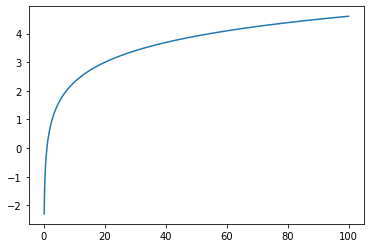

In [ ]:
d = np.linspace(0,100,1000)
p = np.linspace(0,100,1000)
p+=1
p = np.log(p)
plt.plot(d, p)

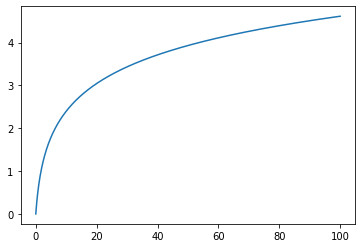

In [ ]:
d = np.linspace(0,100,1000)
p = np.linspace(0,100,1000)
p+=1
p = np.log(p)
plt.plot(d, p)

Text(0.5, 0, 'Quantile')

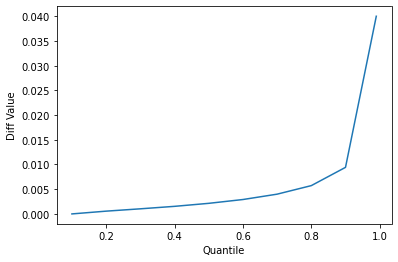

In [ ]:
# Percentile values
d = np.sort(train['microbusiness_density_mv_avg_diff_2'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))
p = np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])
plt.plot(p, d)
plt.ylabel('Diff Value')
plt.xlabel('Quantile')

Text(0.5, 0, 'Quantile')

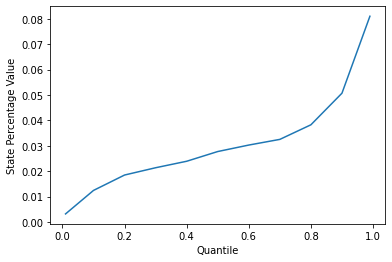

In [ ]:
# Percentile values
d = np.sort(train['state_percentage'].quantile([0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))
p = np.array([0.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])
plt.plot(p, d)
plt.ylabel('State Percentage Value')
plt.xlabel('Quantile')


Text(0.5, 0, 'Quantile')

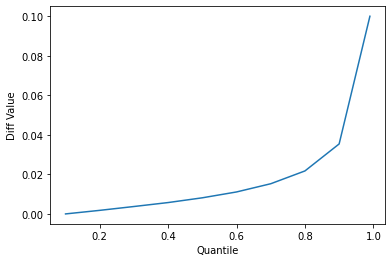

In [ ]:
# Percentile values
d = np.sort(train['density_ratio'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))
p = np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])
plt.plot(p, d)
plt.ylabel('Diff Value')
plt.xlabel('Quantile')

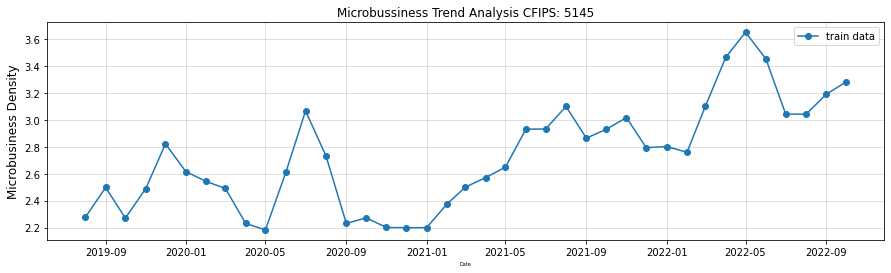

In [ ]:
plot_cfips(5145)

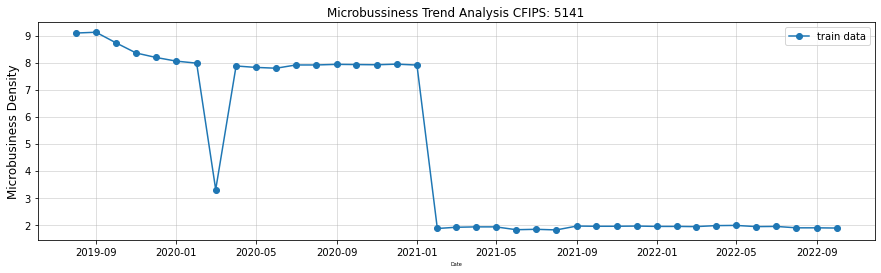

In [ ]:
plot_cfips(5141)

In [ ]:
#showcase 10 outliers
outliers = list(train.loc[train['microbusiness_density_diff']>=0.50, 'cfips'].unique())
print('Total outlier : ', len(outliers))
for i in range(0,10):
    plot_cfips(outliers[i])

Total outlier :  35


NameError: ignored

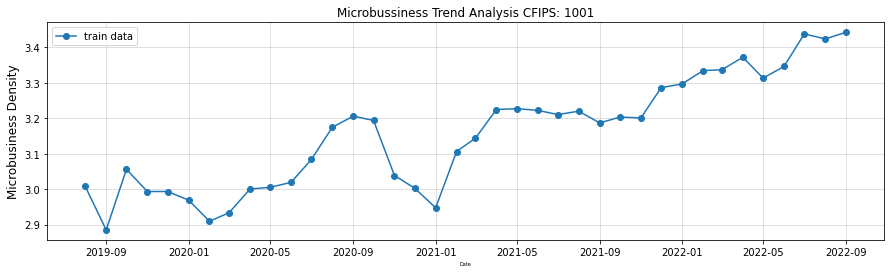

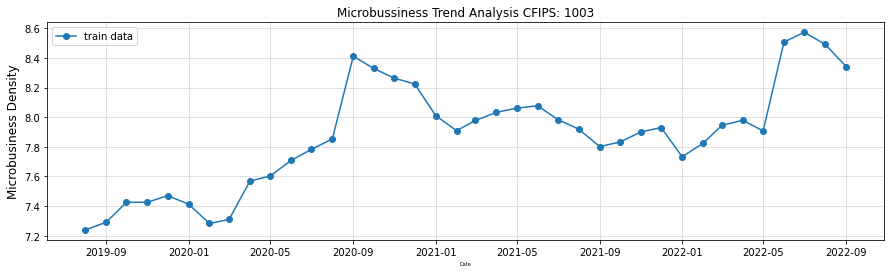

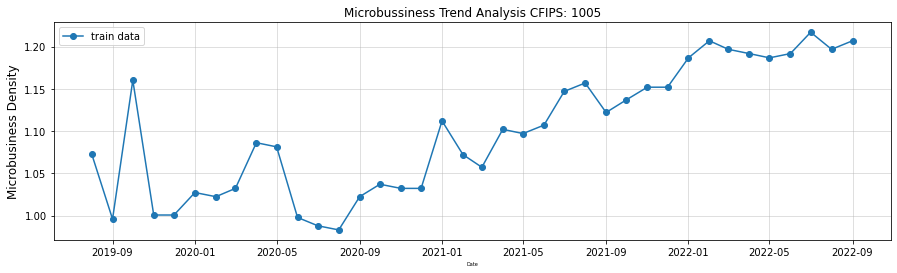

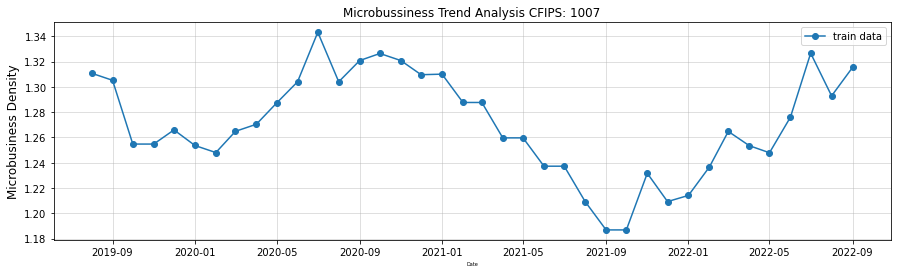

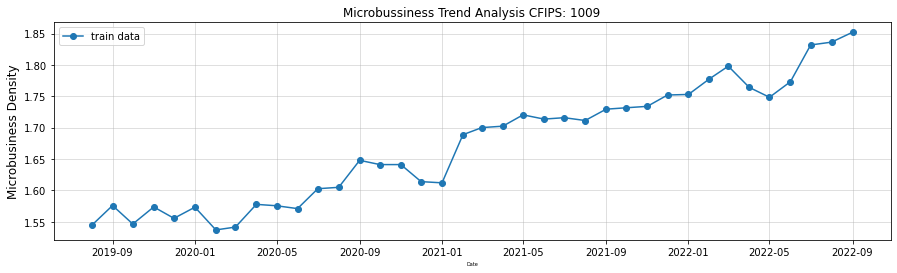

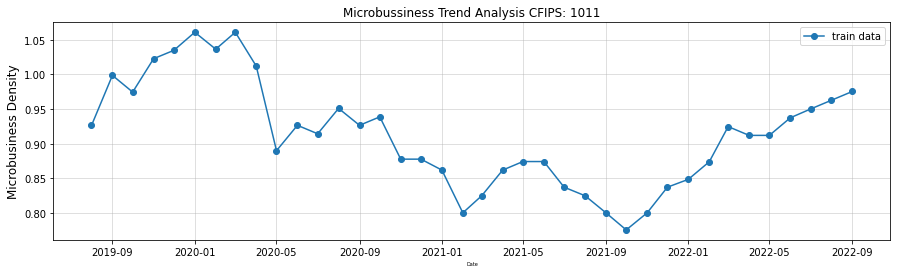

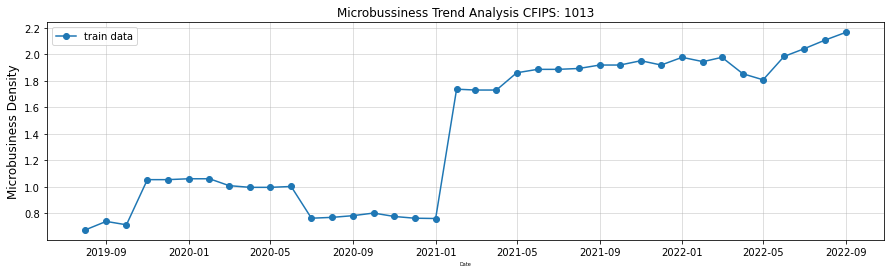

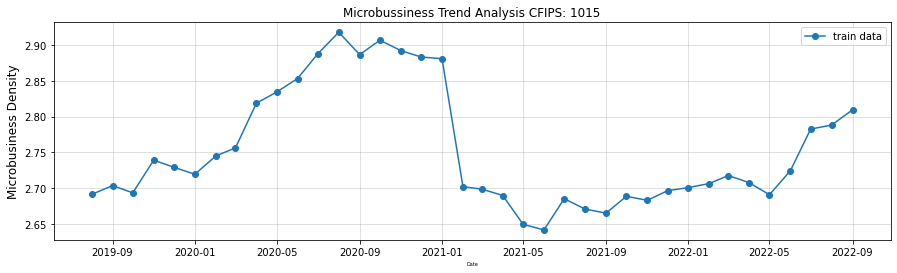

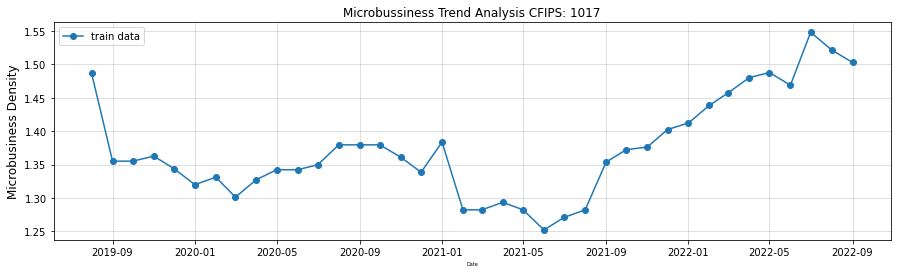

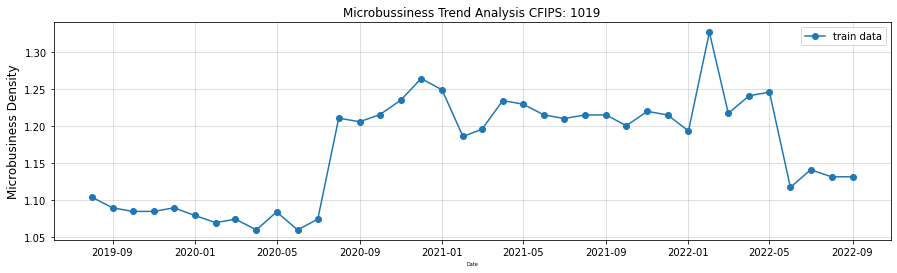

In [ ]:
#showcase 10 non outliers
count = 0
i=0
cfip = list(train['cfips'].unique())
while count < 10:
  if cfip[i] not in outliers:
    plot_cfips(cfip[i])
    i+=1
    count+=1

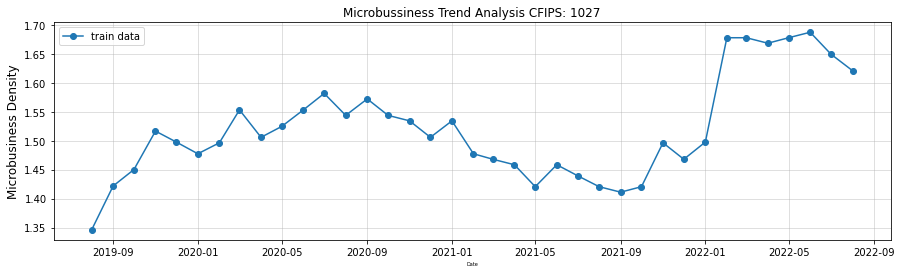

In [ ]:
plot_cfips(1027)

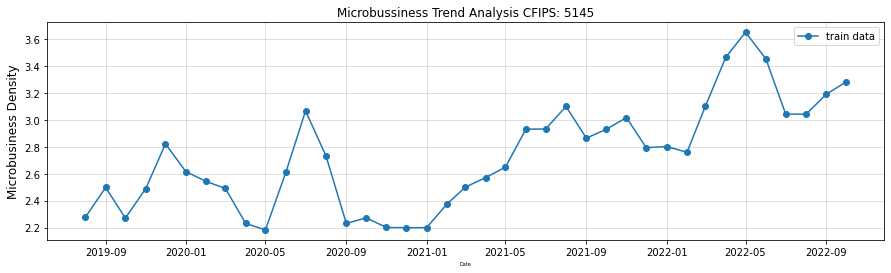

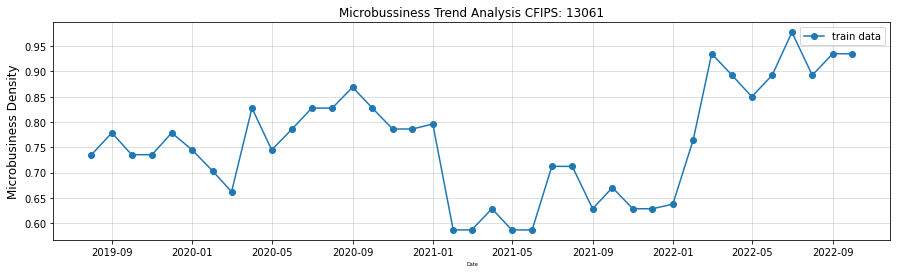

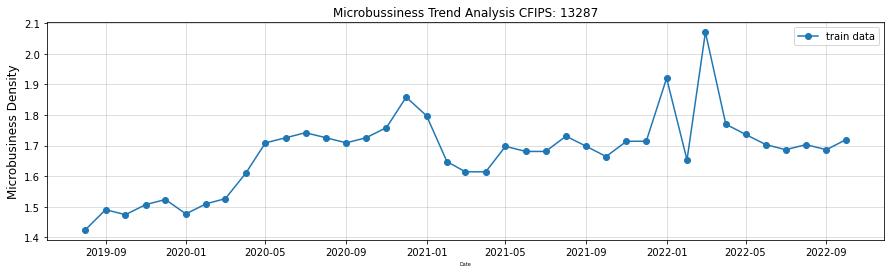

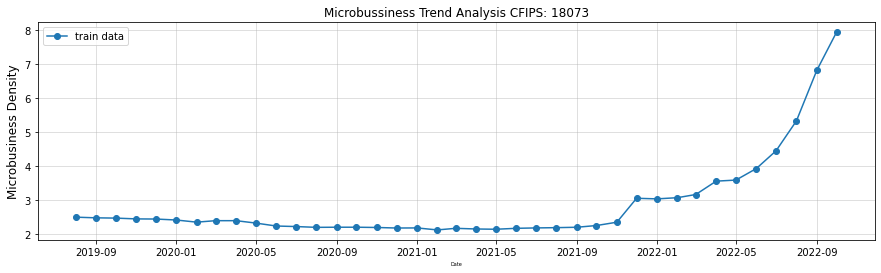

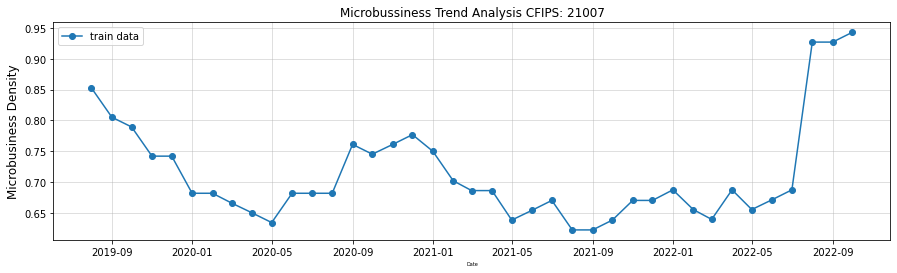

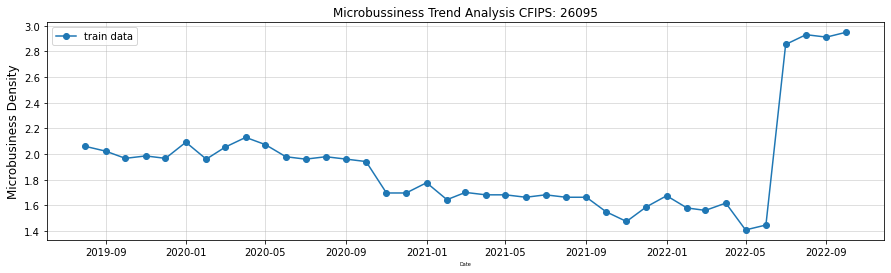

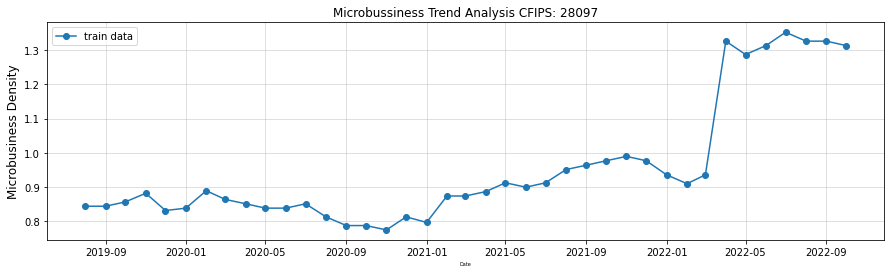

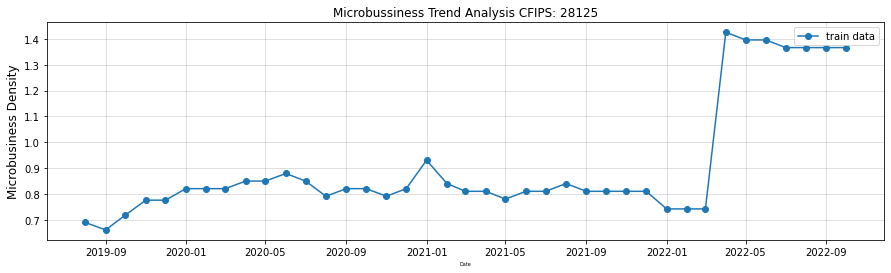

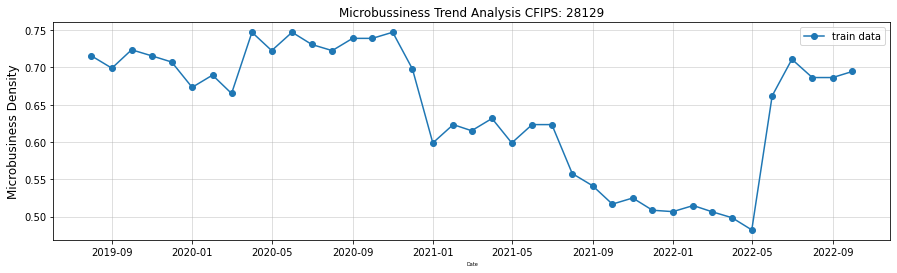

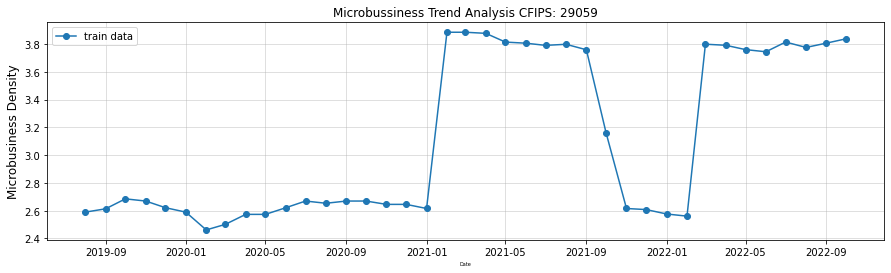

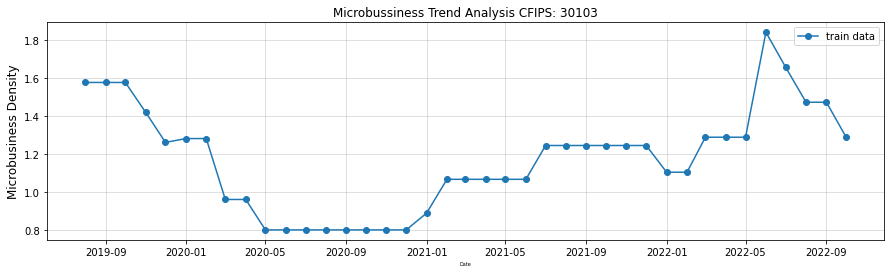

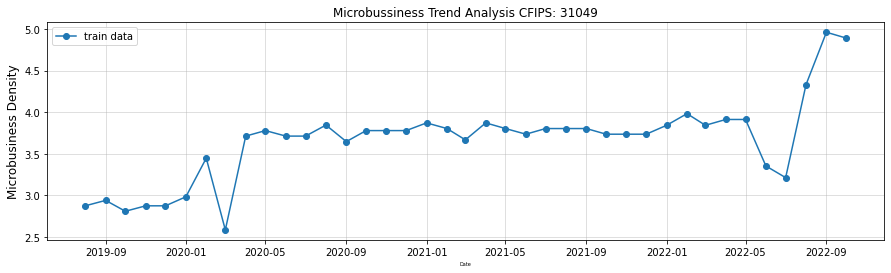

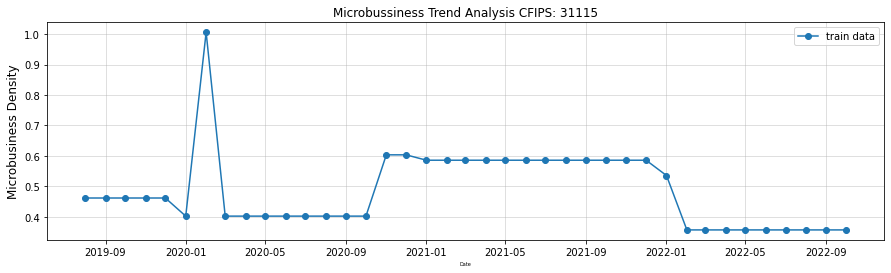

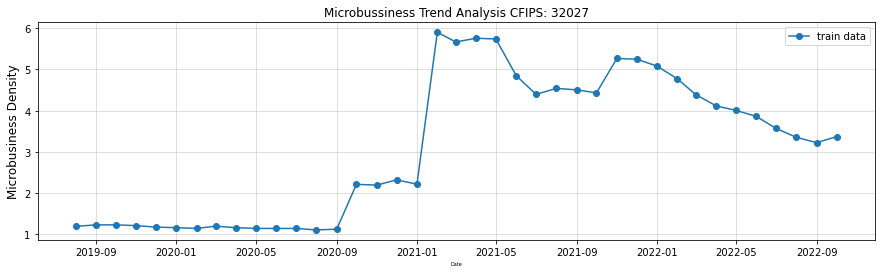

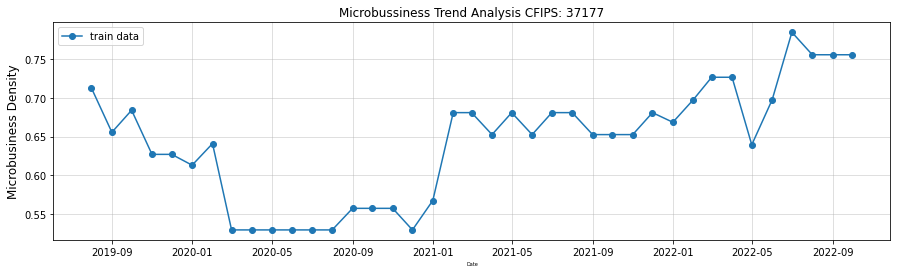

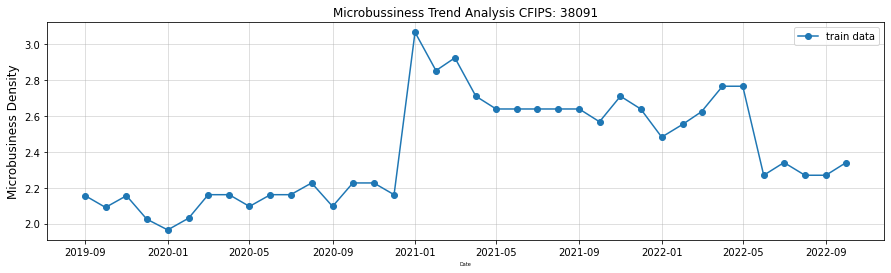

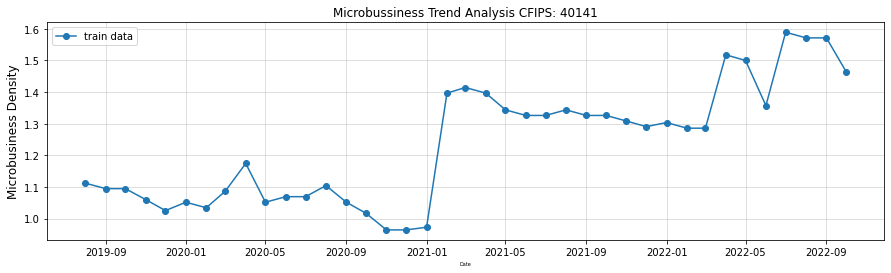

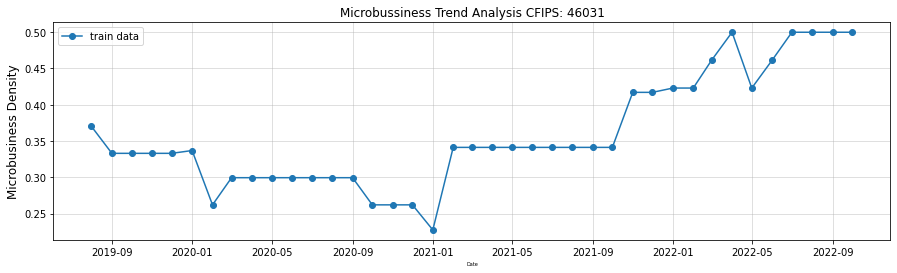

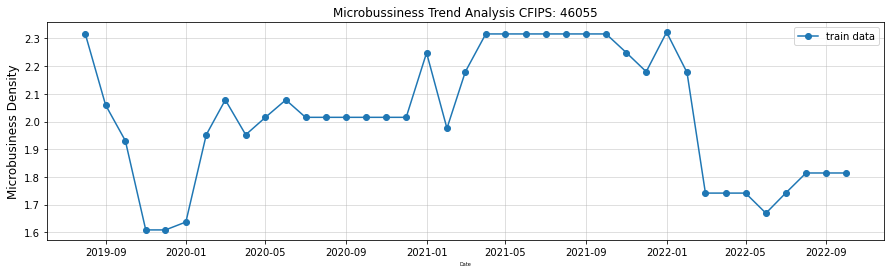

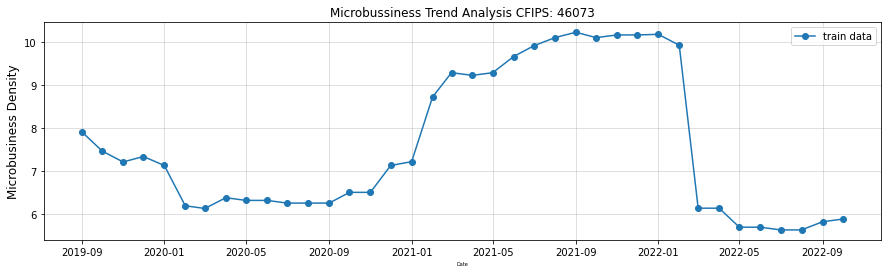

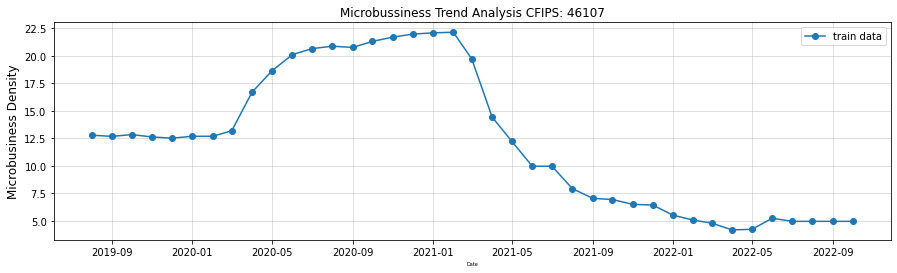

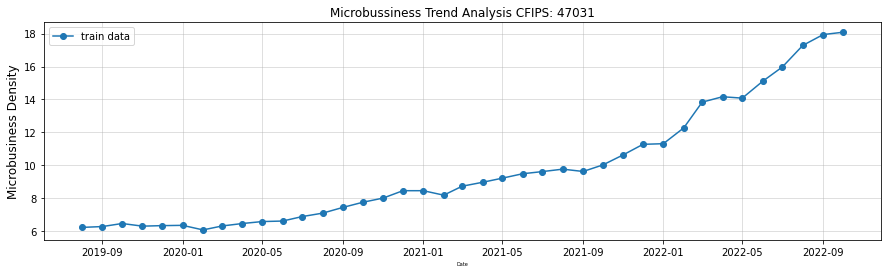

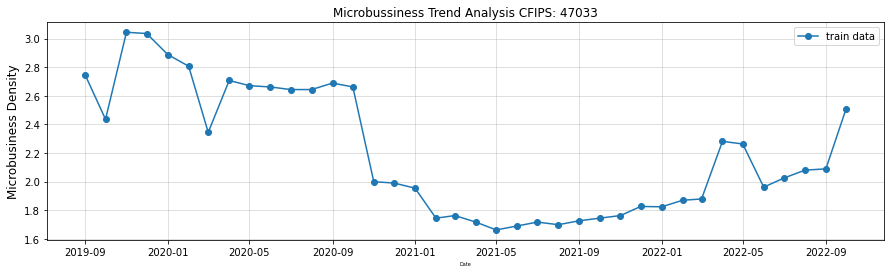

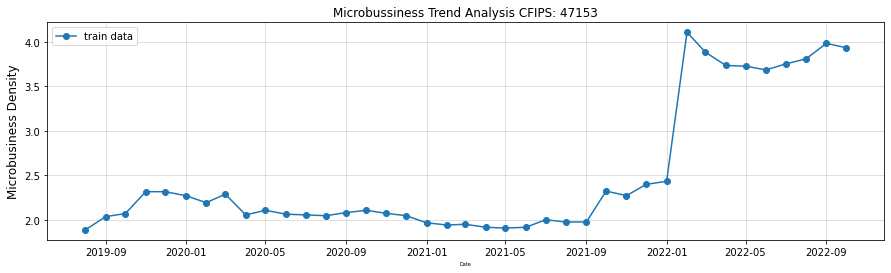

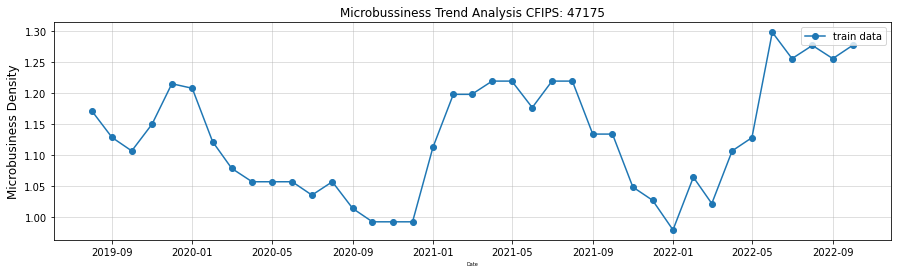

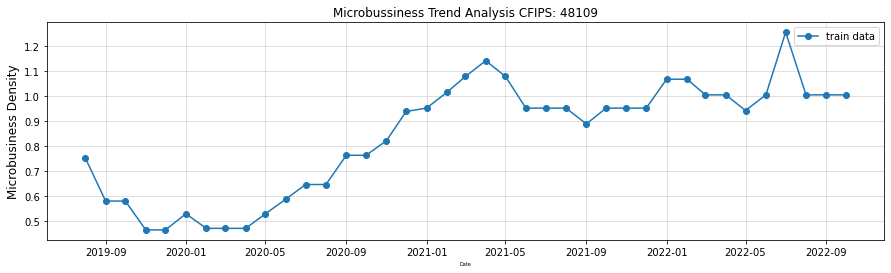

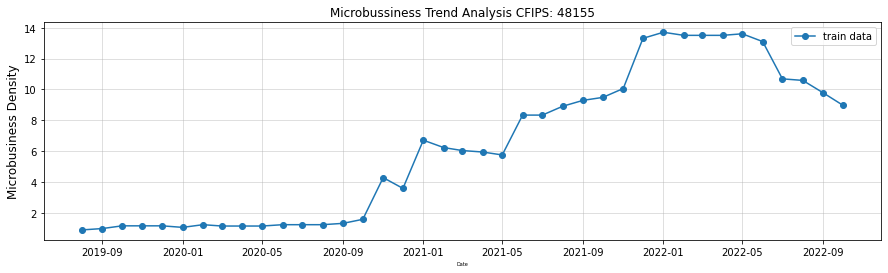

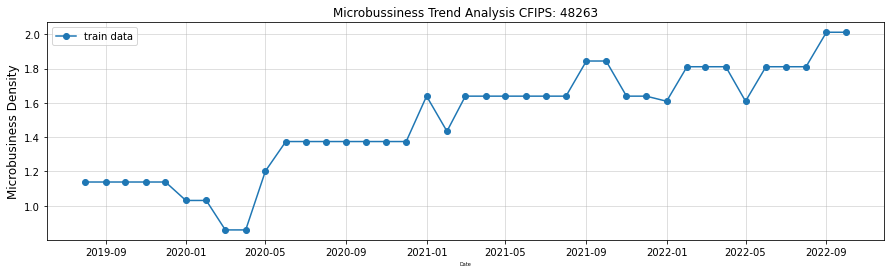

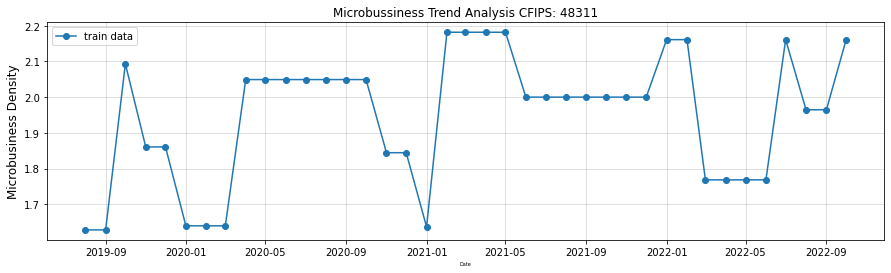

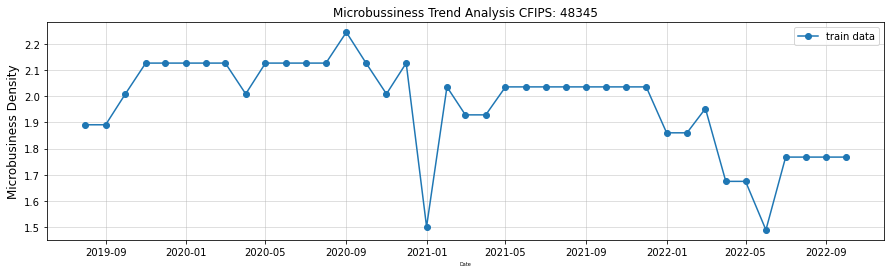

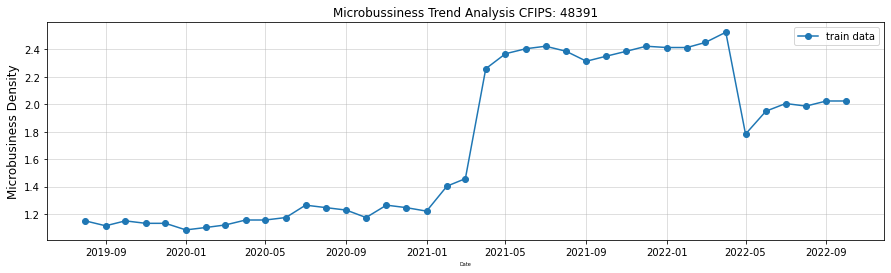

In [ ]:
for cfips in cfips_over5:
  plot_cfips(cfips)

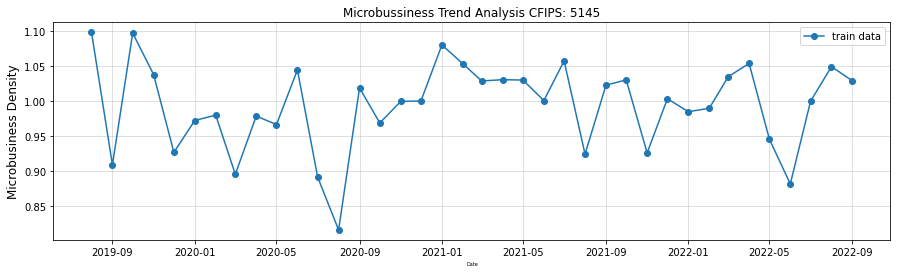

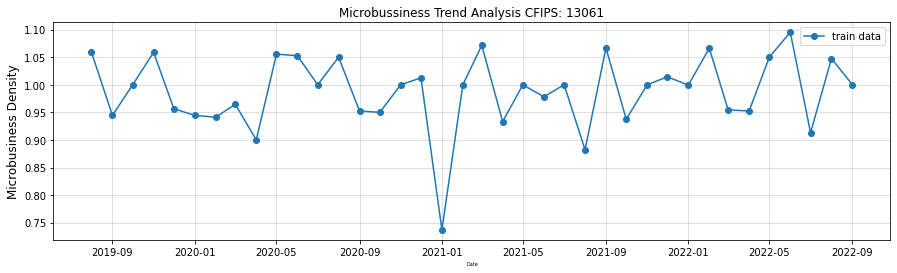

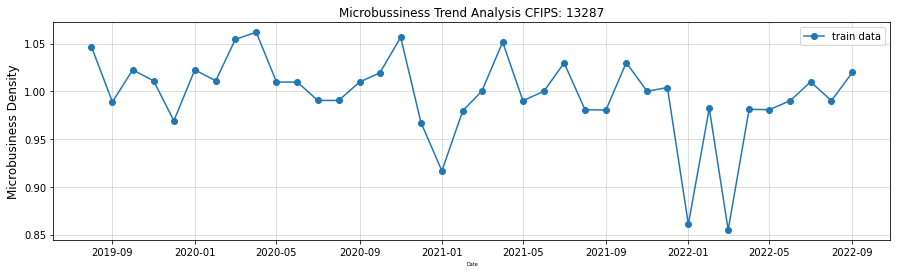

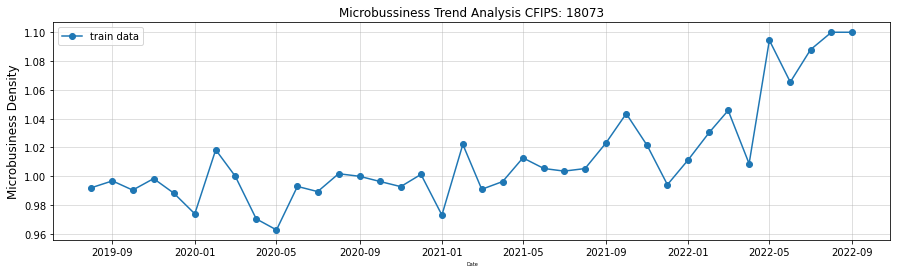

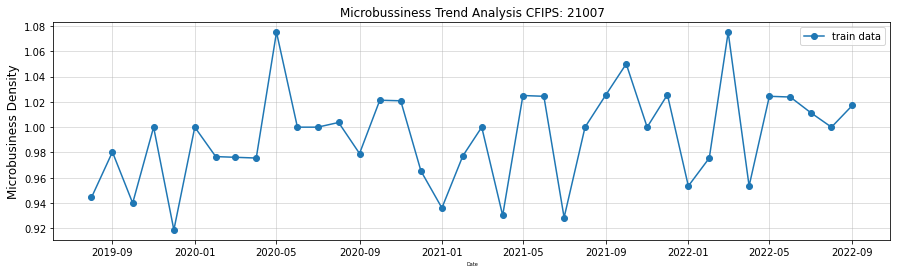

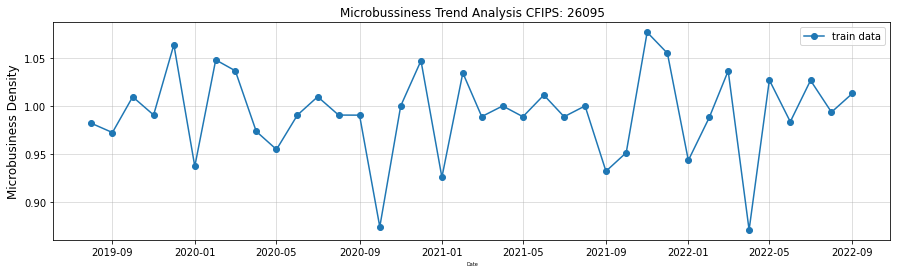

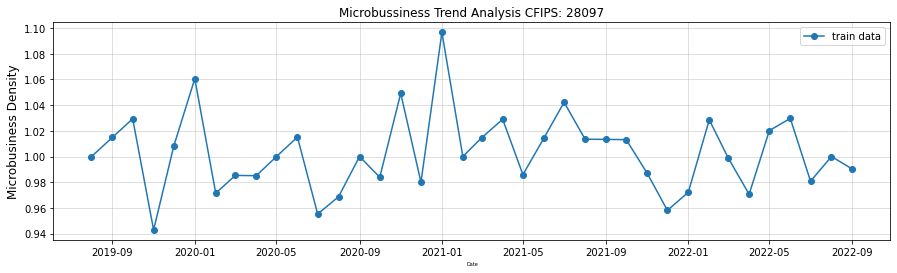

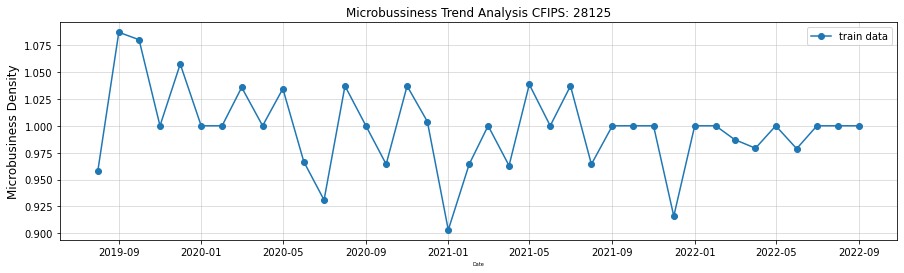

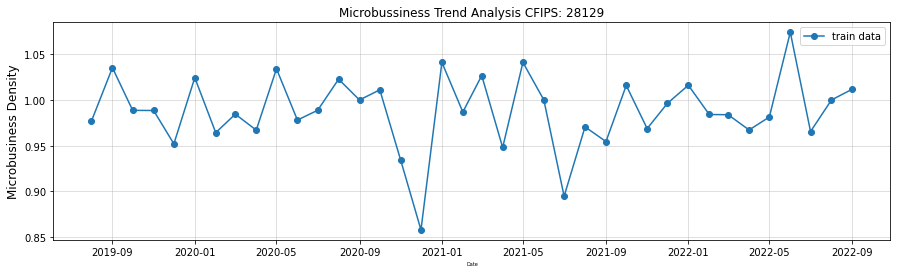

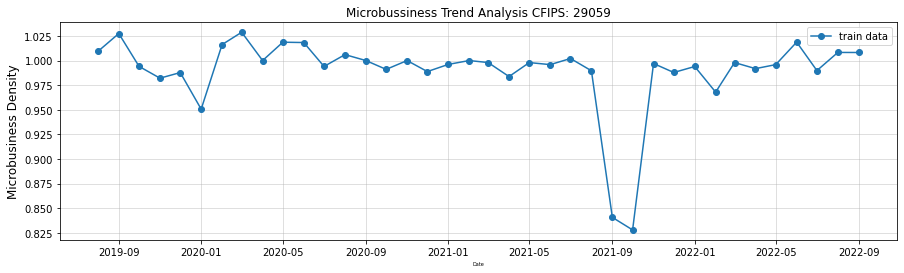

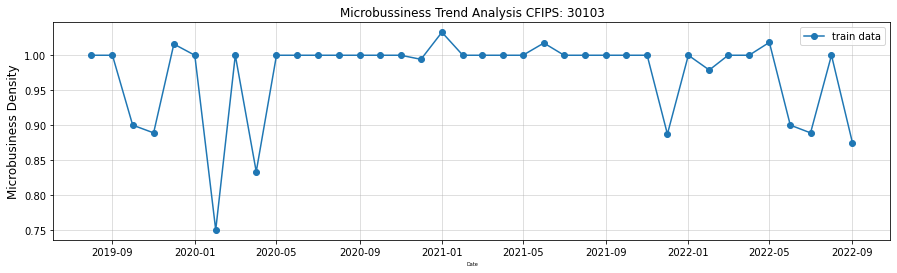

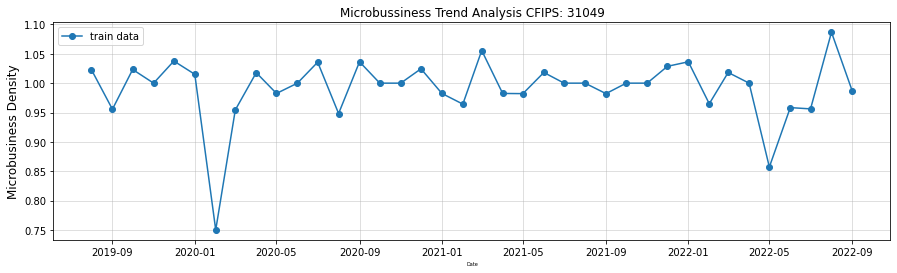

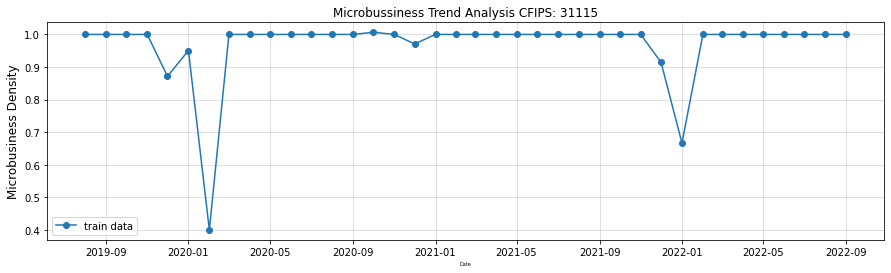

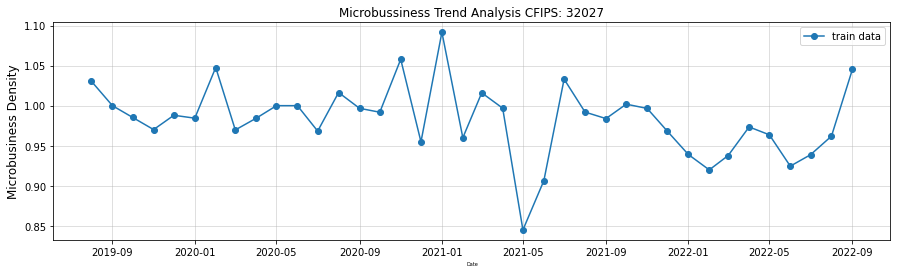

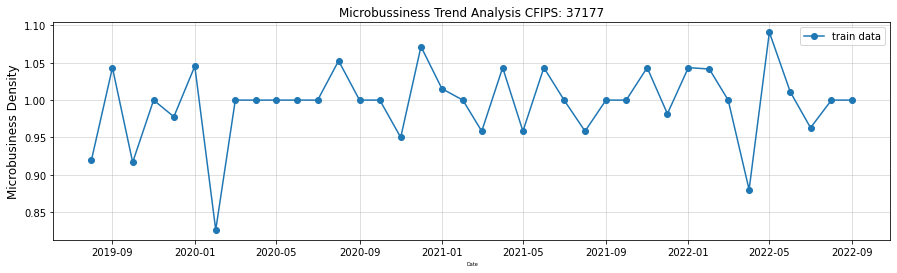

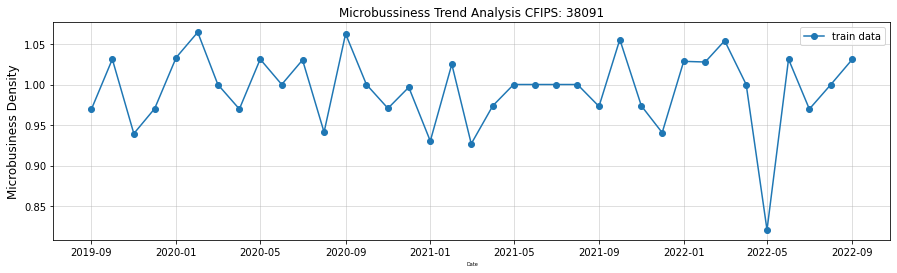

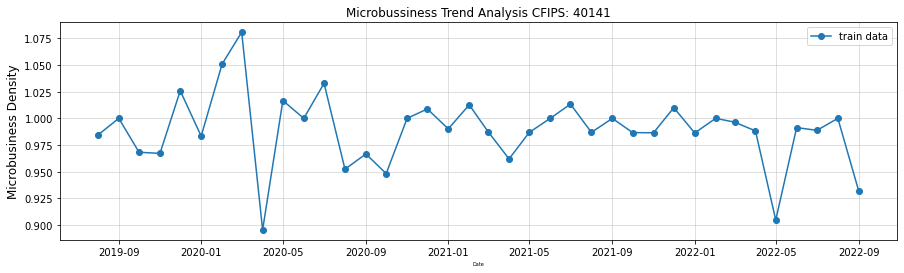

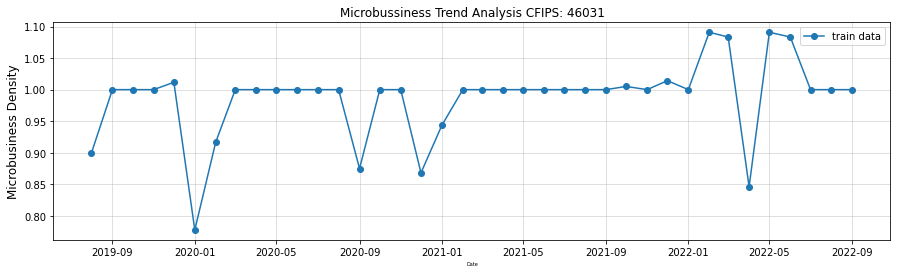

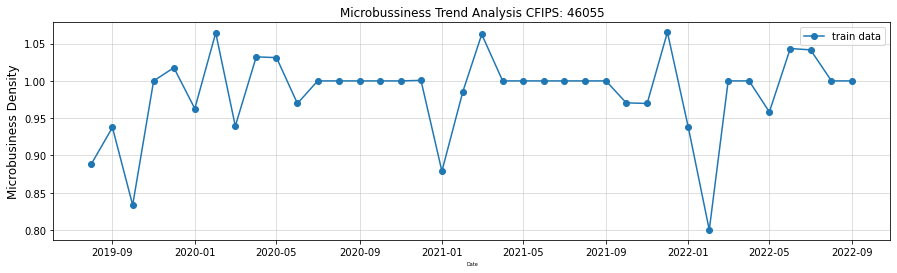

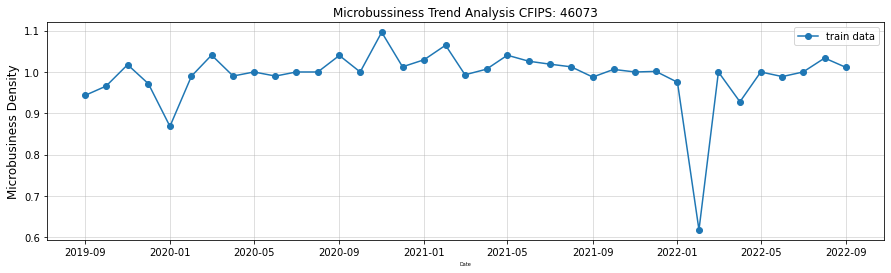

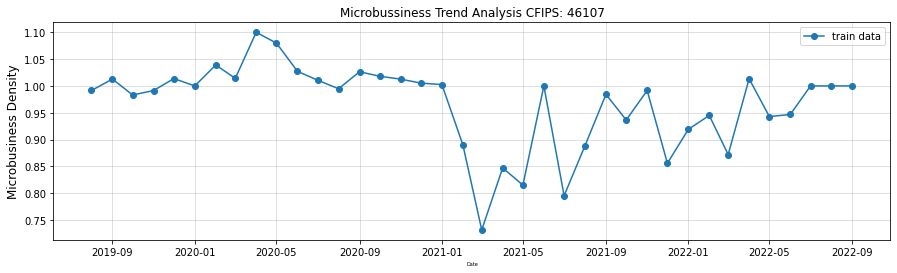

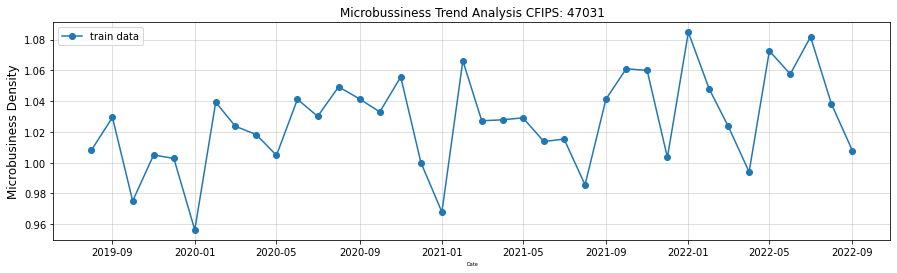

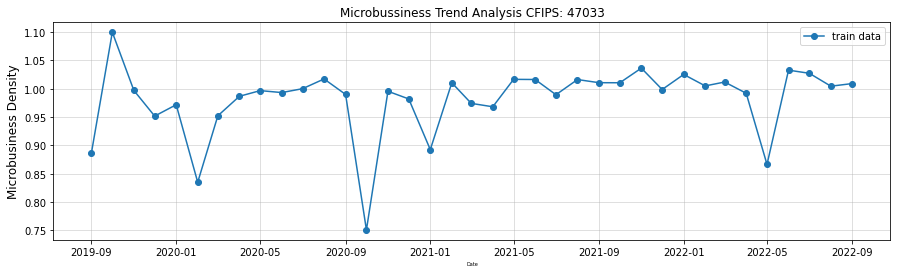

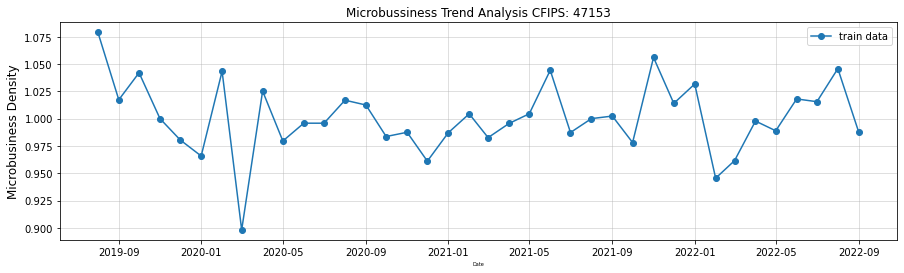

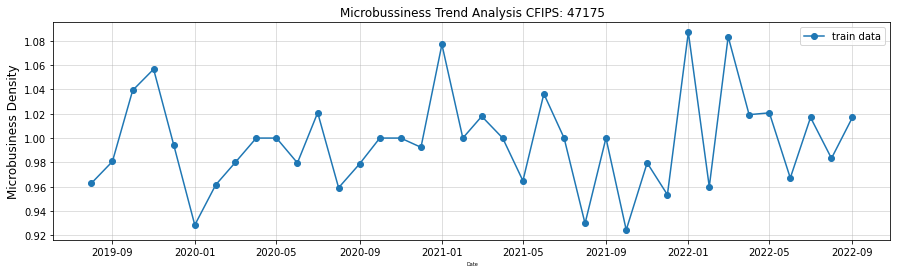

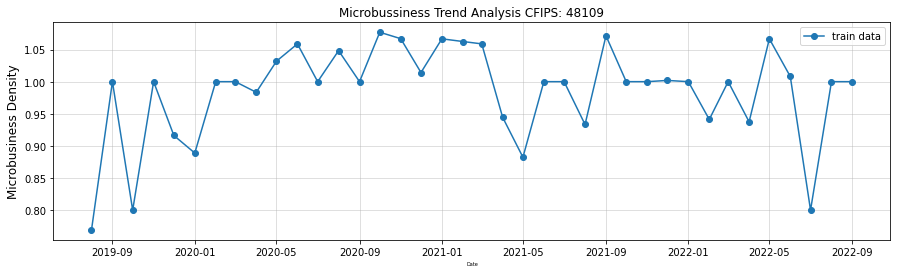

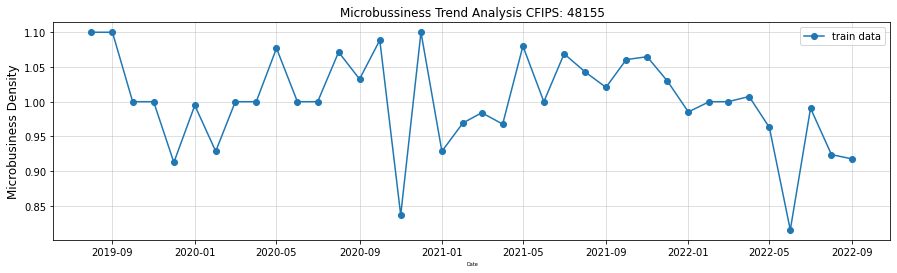

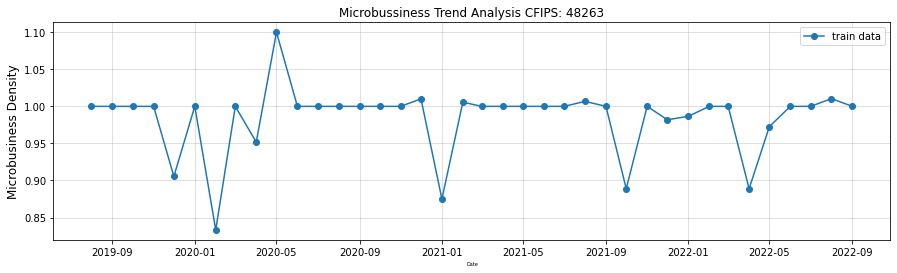

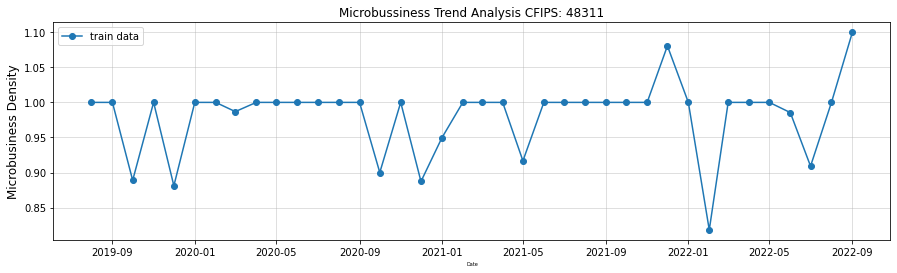

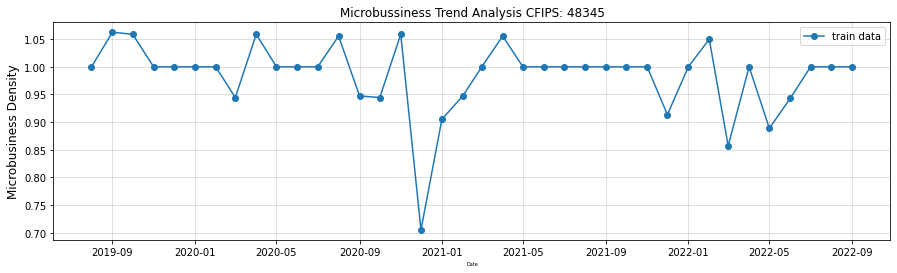

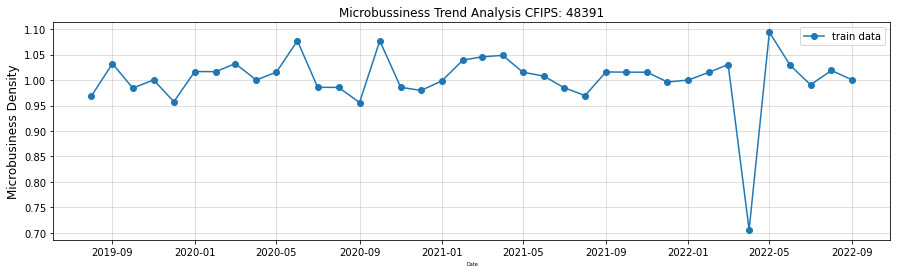

In [ ]:
for cfips in cfips_over5:
  plot_cfips(cfips)

In [ ]:
def factorial(n):
  if n==0:
    print(n)
    return 1
  else:
    print(n)
    return n*factorial(n-1)

In [ ]:
factorial(5)

5
4
3
2
1
0


120